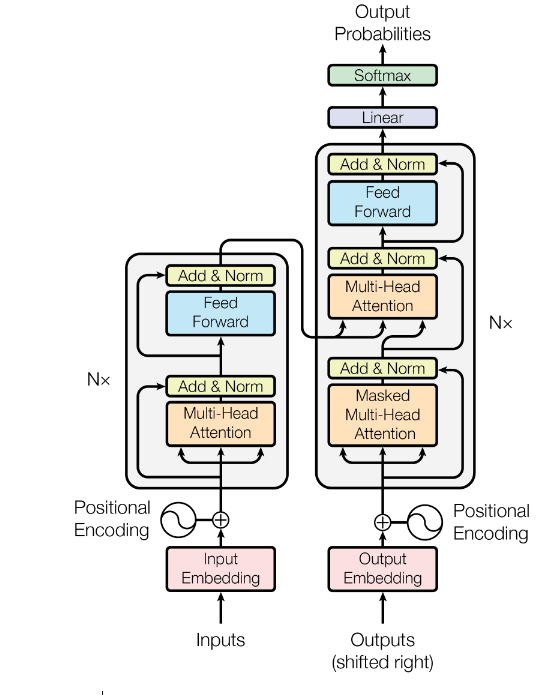


I have to do the following pipeline for encoding

words -> tokenization including for special tokens like start end,or missing padding (left or right) -> unique ids -> embedding (nn.Embedding) -> positional encoding

We need the above pipeline for each language, English and German which explains why there is "src" and "target".

Same for both encoder and decoder but decoder needs to be one right shifted.

I also need to somehow figure out how to mask in decoder in masked multihead attention.

Also somehow fix and resolve parallelism issue of running 8 things for example and then concatenate at end (roughly speaking).

Try to somehow stack it like 6 times the architecture in between before getting final result.

Also need to load data and prepare it to be used for training the transformer

Then focus on in between stuff for architecture like loss function, optimizer, dropout, and some other configs including possibly the hyperparams if any.

Later on, I try to make the transformer fast with flashattention which uses CUDA and/or C/C++.


In [10]:
from torch import nn
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

In [11]:
LOCAL_DIRECTORY = "/kaggle/input/transformer-data"
LOCAL_INPUT = "/kaggle/input/wmt-2014-english-german"
WORKING_DIRECTORY = "/kaggle/working"

In [20]:
# Used when no preprocessed dataset exists so this class is used to preprocess the dataset.
class TextDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file, encoding='utf-8', lineterminator='\n')
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return row["en"], row["de"]
    
# training_dataset = TextDataset(csv_file=LOCAL_INPUT + "/wmt14_translate_de-en_train.csv")
# training_loader = DataLoader(training_dataset, batch_size=16, pin_memory=True)
# validation_dataset = TextDataset(csv_file=LOCAL_INPUT + "/wmt14_translate_de-en_validation.csv")
# validation_loader = DataLoader(validation_dataset, batch_size=16, pin_memory=True)
# testing_dataset = TextDataset(csv_file=LOCAL_INPUT + "/wmt14_translate_de-en_test.csv")
# testing_loader = DataLoader(testing_dataset, batch_size=16, pin_memory=True)

In [12]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders
vocab_size = 10000
def prepare_tokenizer(train_csv_path, val_csv_path, tokenizer_file):
    """
    Create a tokenizer trained on train + validation data
    """
    print("Loading train and validation data for tokenizer...")
    
    train_df = pd.read_csv(LOCAL_INPUT + "/" + train_csv_path, lineterminator='\n')
    val_df = pd.read_csv(LOCAL_INPUT + "/" + val_csv_path, lineterminator='\n')
    
    temp_file = "temp_all_text.txt"
    
    with open(temp_file, "w", encoding="utf-8") as f:
        for _, row in train_df.iterrows():
            f.write(str(row["en"]) + "\n")
            f.write(str(row["de"]) + "\n")
        
        for _, row in val_df.iterrows():
            f.write(str(row["en"]) + "\n")
            f.write(str(row["de"]) + "\n")
    
    print(f"Saved {len(train_df) + len(val_df)} sentences to {temp_file}")
    
    tokenizer = Tokenizer(models.BPE())

    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    
    tokenizer.decoder = decoders.ByteLevel()

    
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=["[BOS]", "[PAD]", "[EOS]"],
    )
    
    tokenizer.train([temp_file], trainer)
    tokenizer.save(WORKING_DIRECTORY + "/" + tokenizer_file)
    
    print(f"Created unified tokenizer with {tokenizer.get_vocab_size()} tokens")
    print(f"Saved to {WORKING_DIRECTORY + "/" +  tokenizer_file}")
    
    import os
    if os.path.exists(temp_file):
        os.remove(temp_file)
    
    return tokenizer

# tokenizer = prepare_tokenizer("wmt14_translate_de-en_train.csv", "wmt14_translate_de-en_validation.csv", "bpe_tokenizer.json")




Created unified tokenizer with 10000 tokens
Saved to /kaggle/working/bpe_tokenizer.json


In [17]:
from tokenizers import Tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"

def load_tokenizer(tokenizer_path):
    """Load a pre-trained tokenizer from a JSON file."""
    tokenizer = Tokenizer.from_file(LOCAL_DIRECTORY + "/" + tokenizer_path)
    return tokenizer

tokenizer = load_tokenizer("bpe_tokenizer.json")

In [21]:
import numpy as np
from tqdm import tqdm

import os

def preprocess_dataset(dataset, tokenizer, output_path, max_len=512, batch_size=1000):
    """Pre-tokenize dataset and save as numpy arrays"""
    pad_id = tokenizer.token_to_id("[PAD]")
    bos_id = tokenizer.token_to_id("[BOS]")
    eos_id = tokenizer.token_to_id("[EOS]") 
    
    total = len(dataset)
    print(f"Preprocessing {total:,} samples...")
    
    src_memmap = np.memmap(output_path + '_src.tmp', dtype=np.int32, 
                          mode='w+', shape=(total, max_len))
    tgt_memmap = np.memmap(output_path + '_tgt.tmp', dtype=np.int32,
                          mode='w+', shape=(total, max_len))
    
    processed = 0
    
    for i in tqdm(range(0, total, batch_size)):
        batch_end = min(i + batch_size, total)
        
        src_batch = []
        tgt_batch = []
        
        for j in range(i, batch_end):
            en_text, de_text = dataset[j]
            
            src_tokens = tokenizer.encode(en_text).ids[:max_len]
            tgt_tokens = tokenizer.encode(de_text).ids[:max_len-2]
            
            src_padded = src_tokens + [pad_id] * (max_len - len(src_tokens))
            tgt_padded = [bos_id] + tgt_tokens + [eos_id] + [pad_id] * (max_len - len(tgt_tokens) - 2)
            
            src_batch.append(src_padded)
            tgt_batch.append(tgt_padded)
        
        src_memmap[i:batch_end] = np.array(src_batch, dtype=np.int32)
        tgt_memmap[i:batch_end] = np.array(tgt_batch, dtype=np.int32)
        
        src_memmap.flush()
        tgt_memmap.flush()
        
        del src_batch, tgt_batch
        
        processed = batch_end
    
    del src_memmap
    del tgt_memmap
    
    print("Saving final .npz file...")
    src_final = np.memmap(output_path + '_src.tmp', dtype=np.int32, 
                         mode='r', shape=(total, max_len))
    tgt_final = np.memmap(output_path + '_tgt.tmp', dtype=np.int32,
                         mode='r', shape=(total, max_len))
    
    np.savez_compressed(output_path, src=src_final, tgt=tgt_final)
    
    os.remove(output_path + '_src.tmp')
    os.remove(output_path + '_tgt.tmp')
    
    print(f"Saved {total:,} samples to {output_path}")
    print(f"  src shape: ({total}, {max_len})")
    print(f"  tgt shape: ({total}, {max_len})")
    
    return total

# print("Preprocessing training data...")
# preprocess_dataset(training_dataset, tokenizer, "train_preprocessed.npz")

# print("Preprocessing validation data...")
# preprocess_dataset(validation_dataset, tokenizer, "val_preprocessed.npz")

# print("Preprocessing test data...")
# preprocess_dataset(testing_dataset, tokenizer, "test_preprocessed.npz")

Preprocessing training data...
Preprocessing 4,508,785 samples...


100%|██████████| 4509/4509 [21:50<00:00,  3.44it/s]


Saving final .npz file...
Saved 4,508,785 samples to train_preprocessed.npz
  src shape: (4508785, 512)
  tgt shape: (4508785, 512)
Preprocessing validation data...
Preprocessing 3,000 samples...


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Saving final .npz file...
Saved 3,000 samples to val_preprocessed.npz
  src shape: (3000, 512)
  tgt shape: (3000, 512)
Preprocessing test data...
Preprocessing 3,003 samples...


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

Saving final .npz file...
Saved 3,003 samples to test_preprocessed.npz
  src shape: (3003, 512)
  tgt shape: (3003, 512)


3003

In [22]:
device = "cuda"
class PreprocessedDataset(Dataset):
    def __init__(self, npz_file, num_samples=float('inf')):
        data = np.load(npz_file, mmap_mode='r')

        num_samples = min(num_samples, len(data['src']))
        self.src = torch.from_numpy(data['src'][:num_samples].copy()).long()
        self.tgt = torch.from_numpy(data['tgt'][:num_samples].copy()).long()
        
        print(f"Loaded {len(self.src):,} samples")
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# This dataset is compressed so num_samples controls how much we can handle here.
training_dataset = PreprocessedDataset(LOCAL_DIRECTORY + "/" + "train_preprocessed.npz", num_samples=10000)
validation_dataset = PreprocessedDataset(LOCAL_DIRECTORY + "/" + "val_preprocessed.npz")
testing_dataset = PreprocessedDataset(LOCAL_DIRECTORY + "/" + "test_preprocessed.npz")

training_loader = DataLoader(training_dataset, batch_size=16)
validation_loader = DataLoader(validation_dataset, batch_size=16)
testing_loader = DataLoader(testing_dataset, batch_size=16)

Loaded 10,000 samples
Loaded 3,000 samples
Loaded 3,003 samples


In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, p, masked = False):
      super().__init__()
      self.q_proj = nn.Linear(d_model, d_model)
      self.k_proj = nn.Linear(d_model, d_model)
      self.v_proj = nn.Linear(d_model, d_model)
      self.linear = nn.Linear(d_model, d_model)
      self.dropout = nn.Dropout(p=p)
      self.h = h
      self.d_head = d_model // h
      self.masked = masked
      # self.attention = ScaledDotProductAttention(self.masked)
      self.d_model = d_model
      if masked:
          self.register_buffer("mask", torch.triu(torch.ones(d_model, d_model), diagonal = 1).bool())
      else:
         self.register_buffer("mask", None)
    def forward(self, x, y = None):
        Q = self.q_proj(x)
        K = self.k_proj(y if y is not None else x)
        V = self.v_proj(y if y is not None else x)
        batch_size, token_size = x.shape[0:2] 
        Q = Q.view(batch_size, token_size, self.h, self.d_head).transpose(1, 2)
        K = K.view(batch_size, token_size, self.h, self.d_head).transpose(1, 2)
        V = V.view(batch_size, token_size, self.h, self.d_head).transpose(1, 2)
        # out = self.attention.forward(Q, K, V)
        out = nn.functional.scaled_dot_product_attention(Q, K, V, self.mask)
        out = out.transpose(1, 2).view(batch_size, token_size, self.d_model)
        return self.dropout(self.linear(out))
        
class ScaledDotProductAttention(nn.Module):
  def __init__(self, masked = False, seq_len = 512):
        super().__init__()
        self.masked = masked
        # Happens for input which has positional encoding applied
        # Diagonal = 1 since we don't want to include the main diagonal so at least the first token is shown.
        if masked:
          self.register_buffer("mask", torch.triu(torch.ones(seq_len, seq_len), diagonal = 1).bool())

    
  def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
      d_k = K.shape[1]
      multiplied = Q @ K.transpose(-2, -1) * (1 / np.sqrt(d_k))
      if self.masked:
          multiplied = multiplied.masked_fill(self.mask, float("-inf"))
      multiplied = torch.softmax(multiplied, dim=-1)
      multiplied = multiplied @ V
      return multiplied
      
class AddNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.norm = nn.LayerNorm(d_model)
    
  def forward(self, x, sublayer_x):
    x = x + sublayer_x
    return self.norm(x)

class FeedForward(nn.Module):
  def __init__(self, d_model, d_inner, p):
    super().__init__()
    self.ffn = nn.Sequential(
        nn.Linear(d_model, d_inner),
        nn.ReLU(),
        nn.Linear(d_inner, d_model),
        nn.Dropout(p=p)
    )
    
  def forward(self, x):
    return self.ffn(x)
        
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, p, seq_len = 512):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=p)

        positional_embeddings = torch.zeros((seq_len, self.d_model))
        pos = torch.arange(seq_len).unsqueeze(1)
        i = torch.arange(self.d_model).unsqueeze(0)
        angles = 1 / torch.pow(10000, (2 * (i // 2)) / self.d_model)
        positional_embeddings[:, 0::2] = torch.sin(pos * angles[:, 0::2])
        positional_embeddings[:, 1::2] = torch.cos(pos * angles[:, 1::2])
        
        self.register_buffer('positional_embeddings', positional_embeddings)
        
    def forward(self, x):
        x = x + self.positional_embeddings.unsqueeze(0)
        return self.dropout(x)
        
class Encoder(nn.Module):
  def __init__(self, d_model, d_inner, h, p):
    super().__init__()
    self.multihead_attention = MultiHeadAttention(h, d_model, p)
    self.fnn = FeedForward(d_model, d_inner, p)
    self.add_norm = AddNorm(d_model)

  def forward(self, src):
      x = self.multihead_attention(src)
      something = self.add_norm(x, src)
      x = self.fnn(something)
      return self.add_norm(x, something)

class Decoder(nn.Module):
  def __init__(self, d_model, d_inner, h, p):
    super().__init__()
    self.masked_multihead_attention = MultiHeadAttention(h, d_model, p, masked=True)
    self.multihead_attention = MultiHeadAttention(h, d_model, p)
    self.fnn = FeedForward(d_model, d_inner, p)
    self.add_norm = AddNorm(d_model)

  def forward(self, tgt, src):
      """
      y is the output of the encoder. 
      """
      x = self.masked_multihead_attention(tgt)
      something = self.add_norm(x, tgt)
      x = self.multihead_attention(something, src)
      something = self.add_norm(x, something)
      x = self.fnn(something)
      return self.add_norm(x, something)

class Transformer(nn.Module):
  def __init__(self, N = 6, d_model = 512, d_inner = 2048, h: int = 8, vocab_size = 37000, p = 0.1):
    super().__init__()
    self.encoders = nn.ModuleList([Encoder(d_model, d_inner, h, p) for _ in range(N)])
    self.decoders = nn.ModuleList([Decoder(d_model, d_inner, h, p) for _ in range(N)])
    self.positional_encoding = PositionalEncoding(d_model, p)
    self.linear = nn.Linear(d_model, vocab_size)
    self.N = N
      
  def forward(self, src, tgt):
      src = self.positional_encoding(src)
      tgt = self.positional_encoding(tgt)

      for encoder in self.encoders:
          src = encoder(src)
        
      for decoder in self.decoders:
          tgt = decoder(tgt, src)
          
      return self.linear(tgt)

In [24]:
import math
from torch.amp import autocast, GradScaler

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/en-de_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.

pad_id = tokenizer.token_to_id("[PAD]")

embedder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=512, padding_idx=pad_id, device=device)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=pad_id)

d_model = 512
model = Transformer(N=3, vocab_size=vocab_size).to(device)
warmup_steps = 4000
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=10e-9)
global_step = 1
scaler = GradScaler()

def batch_to_embedding(src_ids, tgt_ids, embedder):
    src_embeddings = embedder(src_ids) * math.sqrt(d_model)
    tgt_embeddings = embedder(tgt_ids) * math.sqrt(d_model)
    return src_embeddings, tgt_embeddings

        
def train_one_epoch(epoch_index, tb_writer, embedder, loss_fn):
    running_loss = 0.
    last_loss = 0.

    global global_step

    pbar = tqdm(enumerate(training_loader), total=len(training_loader),
                desc=f'Epoch {epoch_index+1}', unit='batch')
    
    for i, data in pbar:
        src_ids, tgt_ids = data
        src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)

        step = global_step
        for param_group in optimizer.param_groups:
            param_group['lr'] = d_model ** (-0.5) * min((step) ** (-0.5), (step) * warmup_steps ** (-1.5))

        optimizer.zero_grad(set_to_none=True)
        
        with autocast(device):
            encoded_embeddings, decoded_embeddings = batch_to_embedding(src_ids, tgt_ids, embedder)  

            outputs = model(encoded_embeddings, decoded_embeddings)

            
            outputs = outputs[:, :-1, :]
            tgt_ids = tgt_ids[:, 1:]
            
            loss = loss_fn(
                outputs.reshape(-1, outputs.size(-1)),
                tgt_ids.reshape(-1)
            )
        
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        
        max_grad_norm = 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
 
        scaler.step(optimizer)
     
        scaler.update()

        global_step += 1
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

2025-12-29 02:42:17.895334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766976138.081518     140 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766976138.133830     140 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766976138.578302     140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766976138.578350     140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766976138.578353     140 computation_placer.cc:177] computation placer alr

In [26]:
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, embedder, loss_fn)


    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vsrc_ids, vtgt_ids = vdata
            vsrc_ids = vsrc_ids.to(device)
            vtgt_ids = vtgt_ids.to(device)

            with autocast(device):
                vencoded_embeddings, vdecoded_embeddings = batch_to_embedding(vsrc_ids, vtgt_ids, embedder) 
                voutputs = model(vencoded_embeddings, vdecoded_embeddings)
    
                voutputs = voutputs[:, :-1, :]
                vtgt_ids = vtgt_ids[:, 1:]
                
                vloss = loss_fn(
                    voutputs.reshape(-1, voutputs.size(-1)),
                    vtgt_ids.reshape(-1)
                )

            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


Epoch 1:   2%|▏         | 11/625 [00:02<01:32,  6.63batch/s]

  batch 10 loss: 9.374024486541748


Epoch 1:   3%|▎         | 21/625 [00:03<01:28,  6.83batch/s]

  batch 20 loss: 9.325024127960205


Epoch 1:   5%|▍         | 31/625 [00:04<01:27,  6.81batch/s]

  batch 30 loss: 9.270489692687988


Epoch 1:   7%|▋         | 41/625 [00:06<01:26,  6.78batch/s]

  batch 40 loss: 9.145788478851319


Epoch 1:   8%|▊         | 51/625 [00:07<01:24,  6.75batch/s]

  batch 50 loss: 8.981604099273682


Epoch 1:  10%|▉         | 61/625 [00:09<01:23,  6.76batch/s]

  batch 60 loss: 8.82728910446167


Epoch 1:  11%|█▏        | 71/625 [00:10<01:22,  6.75batch/s]

  batch 70 loss: 8.689137649536132


Epoch 1:  13%|█▎        | 81/625 [00:12<01:20,  6.76batch/s]

  batch 80 loss: 8.599690055847168


Epoch 1:  15%|█▍        | 91/625 [00:13<01:18,  6.77batch/s]

  batch 90 loss: 8.471650314331054


Epoch 1:  16%|█▌        | 101/625 [00:15<01:17,  6.74batch/s]

  batch 100 loss: 8.436563301086426


Epoch 1:  18%|█▊        | 111/625 [00:16<01:16,  6.72batch/s]

  batch 110 loss: 8.411143970489501


Epoch 1:  19%|█▉        | 121/625 [00:18<01:14,  6.76batch/s]

  batch 120 loss: 8.263012599945068


Epoch 1:  21%|██        | 131/625 [00:19<01:13,  6.73batch/s]

  batch 130 loss: 8.20243673324585


Epoch 1:  23%|██▎       | 141/625 [00:21<01:11,  6.72batch/s]

  batch 140 loss: 8.11575961112976


Epoch 1:  24%|██▍       | 151/625 [00:22<01:10,  6.72batch/s]

  batch 150 loss: 8.079950523376464


Epoch 1:  26%|██▌       | 161/625 [00:24<01:09,  6.71batch/s]

  batch 160 loss: 7.990383672714233


Epoch 1:  27%|██▋       | 171/625 [00:25<01:07,  6.71batch/s]

  batch 170 loss: 7.974449872970581


Epoch 1:  29%|██▉       | 181/625 [00:27<01:06,  6.66batch/s]

  batch 180 loss: 7.972202157974243


Epoch 1:  31%|███       | 191/625 [00:28<01:05,  6.68batch/s]

  batch 190 loss: 7.867672252655029


Epoch 1:  32%|███▏      | 201/625 [00:30<01:03,  6.67batch/s]

  batch 200 loss: 7.803160762786865


Epoch 1:  34%|███▍      | 211/625 [00:31<01:01,  6.68batch/s]

  batch 210 loss: 7.75209150314331


Epoch 1:  35%|███▌      | 221/625 [00:33<01:00,  6.66batch/s]

  batch 220 loss: 7.715925979614258


Epoch 1:  37%|███▋      | 231/625 [00:34<00:59,  6.64batch/s]

  batch 230 loss: 7.699756193161011


Epoch 1:  39%|███▊      | 241/625 [00:36<00:57,  6.66batch/s]

  batch 240 loss: 7.758956098556519


Epoch 1:  40%|████      | 251/625 [00:37<00:56,  6.63batch/s]

  batch 250 loss: 7.630597448348999


Epoch 1:  42%|████▏     | 261/625 [00:39<00:55,  6.59batch/s]

  batch 260 loss: 7.610402631759643


Epoch 1:  43%|████▎     | 271/625 [00:40<00:53,  6.63batch/s]

  batch 270 loss: 7.559490489959717


Epoch 1:  45%|████▍     | 281/625 [00:42<00:52,  6.59batch/s]

  batch 280 loss: 7.5838275909423825


Epoch 1:  47%|████▋     | 291/625 [00:43<00:50,  6.58batch/s]

  batch 290 loss: 7.560004615783692


Epoch 1:  48%|████▊     | 301/625 [00:45<00:49,  6.60batch/s]

  batch 300 loss: 7.474119997024536


Epoch 1:  50%|████▉     | 311/625 [00:46<00:47,  6.58batch/s]

  batch 310 loss: 7.512962770462036


Epoch 1:  51%|█████▏    | 321/625 [00:48<00:46,  6.55batch/s]

  batch 320 loss: 7.498870515823365


Epoch 1:  53%|█████▎    | 331/625 [00:49<00:44,  6.55batch/s]

  batch 330 loss: 7.507187747955323


Epoch 1:  55%|█████▍    | 341/625 [00:51<00:43,  6.55batch/s]

  batch 340 loss: 7.478676891326904


Epoch 1:  56%|█████▌    | 351/625 [00:52<00:42,  6.51batch/s]

  batch 350 loss: 7.49957242012024


Epoch 1:  58%|█████▊    | 361/625 [00:54<00:40,  6.51batch/s]

  batch 360 loss: 7.428545188903809


Epoch 1:  59%|█████▉    | 371/625 [00:56<00:39,  6.51batch/s]

  batch 370 loss: 7.438323163986206


Epoch 1:  61%|██████    | 381/625 [00:57<00:37,  6.51batch/s]

  batch 380 loss: 7.383222770690918


Epoch 1:  63%|██████▎   | 391/625 [00:59<00:35,  6.51batch/s]

  batch 390 loss: 7.422264814376831


Epoch 1:  64%|██████▍   | 401/625 [01:00<00:34,  6.50batch/s]

  batch 400 loss: 7.450358057022095


Epoch 1:  66%|██████▌   | 411/625 [01:02<00:33,  6.47batch/s]

  batch 410 loss: 7.343063879013061


Epoch 1:  67%|██████▋   | 421/625 [01:03<00:31,  6.42batch/s]

  batch 420 loss: 7.359476852416992


Epoch 1:  69%|██████▉   | 431/625 [01:05<00:30,  6.45batch/s]

  batch 430 loss: 7.37689094543457


Epoch 1:  71%|███████   | 441/625 [01:06<00:28,  6.43batch/s]

  batch 440 loss: 7.334039926528931


Epoch 1:  72%|███████▏  | 451/625 [01:08<00:27,  6.42batch/s]

  batch 450 loss: 7.382101154327392


Epoch 1:  74%|███████▍  | 461/625 [01:09<00:25,  6.44batch/s]

  batch 460 loss: 7.350845289230347


Epoch 1:  75%|███████▌  | 471/625 [01:11<00:24,  6.40batch/s]

  batch 470 loss: 7.251742219924926


Epoch 1:  77%|███████▋  | 481/625 [01:13<00:22,  6.42batch/s]

  batch 480 loss: 7.3425922870635985


Epoch 1:  79%|███████▊  | 491/625 [01:14<00:20,  6.41batch/s]

  batch 490 loss: 7.329052972793579


Epoch 1:  80%|████████  | 501/625 [01:16<00:19,  6.37batch/s]

  batch 500 loss: 7.300309467315674


Epoch 1:  82%|████████▏ | 511/625 [01:17<00:17,  6.39batch/s]

  batch 510 loss: 7.33225531578064


Epoch 1:  83%|████████▎ | 521/625 [01:19<00:16,  6.36batch/s]

  batch 520 loss: 7.289247131347656


Epoch 1:  85%|████████▍ | 531/625 [01:20<00:14,  6.36batch/s]

  batch 530 loss: 7.258470058441162


Epoch 1:  87%|████████▋ | 541/625 [01:22<00:13,  6.34batch/s]

  batch 540 loss: 7.211967611312867


Epoch 1:  88%|████████▊ | 551/625 [01:24<00:11,  6.29batch/s]

  batch 550 loss: 7.219401550292969


Epoch 1:  90%|████████▉ | 561/625 [01:25<00:10,  6.30batch/s]

  batch 560 loss: 7.236905813217163


Epoch 1:  91%|█████████▏| 571/625 [01:27<00:08,  6.33batch/s]

  batch 570 loss: 7.242581176757812


Epoch 1:  93%|█████████▎| 581/625 [01:28<00:06,  6.32batch/s]

  batch 580 loss: 7.1864426612854


Epoch 1:  95%|█████████▍| 591/625 [01:30<00:05,  6.30batch/s]

  batch 590 loss: 7.193184471130371


Epoch 1:  96%|█████████▌| 601/625 [01:31<00:03,  6.28batch/s]

  batch 600 loss: 7.200391674041748


Epoch 1:  98%|█████████▊| 611/625 [01:33<00:02,  6.26batch/s]

  batch 610 loss: 7.11993989944458


Epoch 1:  99%|█████████▉| 621/625 [01:35<00:00,  6.26batch/s]

  batch 620 loss: 7.144816112518311


Epoch 1: 100%|██████████| 625/625 [01:35<00:00,  6.52batch/s]


LOSS train 7.144816112518311 valid 7.07487678527832
EPOCH 2:


Epoch 2:   2%|▏         | 11/625 [00:01<01:39,  6.19batch/s]

  batch 10 loss: 7.0764243602752686


Epoch 2:   3%|▎         | 21/625 [00:03<01:37,  6.18batch/s]

  batch 20 loss: 7.039360523223877


Epoch 2:   5%|▍         | 31/625 [00:05<01:35,  6.19batch/s]

  batch 30 loss: 7.159962940216064


Epoch 2:   7%|▋         | 41/625 [00:06<01:35,  6.13batch/s]

  batch 40 loss: 7.064766073226929


Epoch 2:   8%|▊         | 51/625 [00:08<01:34,  6.10batch/s]

  batch 50 loss: 7.023367214202881


Epoch 2:  10%|▉         | 61/625 [00:09<01:32,  6.12batch/s]

  batch 60 loss: 7.048019742965698


Epoch 2:  11%|█▏        | 71/625 [00:11<01:31,  6.08batch/s]

  batch 70 loss: 7.026592063903808


Epoch 2:  13%|█▎        | 81/625 [00:13<01:29,  6.10batch/s]

  batch 80 loss: 7.014591550827026


Epoch 2:  15%|█▍        | 91/625 [00:14<01:28,  6.05batch/s]

  batch 90 loss: 6.959653282165528


Epoch 2:  16%|█▌        | 101/625 [00:16<01:26,  6.06batch/s]

  batch 100 loss: 7.018882751464844


Epoch 2:  18%|█▊        | 111/625 [00:18<01:24,  6.07batch/s]

  batch 110 loss: 7.00865797996521


Epoch 2:  19%|█▉        | 121/625 [00:19<01:23,  6.03batch/s]

  batch 120 loss: 6.85112681388855


Epoch 2:  21%|██        | 131/625 [00:21<01:21,  6.04batch/s]

  batch 130 loss: 6.828615140914917


Epoch 2:  23%|██▎       | 141/625 [00:23<01:19,  6.07batch/s]

  batch 140 loss: 6.800880050659179


Epoch 2:  24%|██▍       | 151/625 [00:24<01:18,  6.05batch/s]

  batch 150 loss: 6.80442361831665


Epoch 2:  26%|██▌       | 161/625 [00:26<01:16,  6.04batch/s]

  batch 160 loss: 6.681271982192993


Epoch 2:  27%|██▋       | 171/625 [00:28<01:15,  6.04batch/s]

  batch 170 loss: 6.742545890808105


Epoch 2:  29%|██▉       | 181/625 [00:29<01:14,  5.97batch/s]

  batch 180 loss: 6.779099082946777


Epoch 2:  31%|███       | 191/625 [00:31<01:12,  6.00batch/s]

  batch 190 loss: 6.617332792282104


Epoch 2:  32%|███▏      | 201/625 [00:33<01:10,  6.00batch/s]

  batch 200 loss: 6.586562156677246


Epoch 2:  34%|███▍      | 211/625 [00:34<01:09,  5.93batch/s]

  batch 210 loss: 6.5397107124328615


Epoch 2:  35%|███▌      | 221/625 [00:36<01:08,  5.92batch/s]

  batch 220 loss: 6.483722257614136


Epoch 2:  37%|███▋      | 231/625 [00:38<01:06,  5.92batch/s]

  batch 230 loss: 6.448327159881591


Epoch 2:  39%|███▊      | 241/625 [00:39<01:05,  5.88batch/s]

  batch 240 loss: 6.5467531204223635


Epoch 2:  40%|████      | 251/625 [00:41<01:03,  5.87batch/s]

  batch 250 loss: 6.379923582077026


Epoch 2:  42%|████▏     | 261/625 [00:43<01:01,  5.87batch/s]

  batch 260 loss: 6.344416761398316


Epoch 2:  43%|████▎     | 271/625 [00:44<01:00,  5.82batch/s]

  batch 270 loss: 6.27205867767334


Epoch 2:  45%|████▍     | 281/625 [00:46<00:59,  5.78batch/s]

  batch 280 loss: 6.280254983901978


Epoch 2:  47%|████▋     | 291/625 [00:48<00:57,  5.78batch/s]

  batch 290 loss: 6.234671640396118


Epoch 2:  48%|████▊     | 301/625 [00:50<00:55,  5.86batch/s]

  batch 300 loss: 6.020779180526733


Epoch 2:  50%|████▉     | 311/625 [00:51<00:54,  5.80batch/s]

  batch 310 loss: 6.182107400894165


Epoch 2:  51%|█████▏    | 321/625 [00:53<00:52,  5.83batch/s]

  batch 320 loss: 6.057378435134888


Epoch 2:  53%|█████▎    | 331/625 [00:55<00:50,  5.77batch/s]

  batch 330 loss: 6.077350664138794


Epoch 2:  55%|█████▍    | 341/625 [00:57<00:48,  5.82batch/s]

  batch 340 loss: 5.955937767028809


Epoch 2:  56%|█████▌    | 351/625 [00:58<00:47,  5.74batch/s]

  batch 350 loss: 5.966545295715332


Epoch 2:  58%|█████▊    | 361/625 [01:00<00:46,  5.74batch/s]

  batch 360 loss: 5.8694556713104244


Epoch 2:  59%|█████▉    | 371/625 [01:02<00:44,  5.73batch/s]

  batch 370 loss: 5.8765379905700685


Epoch 2:  61%|██████    | 381/625 [01:03<00:42,  5.74batch/s]

  batch 380 loss: 5.700193262100219


Epoch 2:  63%|██████▎   | 391/625 [01:05<00:40,  5.77batch/s]

  batch 390 loss: 5.729562664031983


Epoch 2:  64%|██████▍   | 401/625 [01:07<00:38,  5.83batch/s]

  batch 400 loss: 5.7112761497497555


Epoch 2:  66%|██████▌   | 411/625 [01:09<00:36,  5.80batch/s]

  batch 410 loss: 5.570184707641602


Epoch 2:  67%|██████▋   | 421/625 [01:10<00:35,  5.81batch/s]

  batch 420 loss: 5.5114821434021


Epoch 2:  69%|██████▉   | 431/625 [01:12<00:33,  5.82batch/s]

  batch 430 loss: 5.504078769683838


Epoch 2:  71%|███████   | 441/625 [01:14<00:32,  5.74batch/s]

  batch 440 loss: 5.415373086929321


Epoch 2:  72%|███████▏  | 451/625 [01:16<00:29,  5.83batch/s]

  batch 450 loss: 5.4288623332977295


Epoch 2:  74%|███████▍  | 461/625 [01:17<00:27,  5.86batch/s]

  batch 460 loss: 5.340677928924561


Epoch 2:  75%|███████▌  | 471/625 [01:19<00:26,  5.85batch/s]

  batch 470 loss: 5.124354028701783


Epoch 2:  77%|███████▋  | 481/625 [01:21<00:24,  5.86batch/s]

  batch 480 loss: 5.21691312789917


Epoch 2:  79%|███████▊  | 491/625 [01:22<00:22,  5.85batch/s]

  batch 490 loss: 5.258050918579102


Epoch 2:  80%|████████  | 501/625 [01:24<00:21,  5.86batch/s]

  batch 500 loss: 5.13104739189148


Epoch 2:  82%|████████▏ | 511/625 [01:26<00:19,  5.85batch/s]

  batch 510 loss: 5.151206970214844


Epoch 2:  83%|████████▎ | 521/625 [01:27<00:17,  5.90batch/s]

  batch 520 loss: 5.033176517486572


Epoch 2:  85%|████████▍ | 531/625 [01:29<00:15,  5.95batch/s]

  batch 530 loss: 4.955295896530151


Epoch 2:  87%|████████▋ | 541/625 [01:31<00:14,  5.90batch/s]

  batch 540 loss: 4.8371233463287355


Epoch 2:  88%|████████▊ | 551/625 [01:33<00:12,  5.99batch/s]

  batch 550 loss: 4.808123970031739


Epoch 2:  90%|████████▉ | 561/625 [01:34<00:10,  5.99batch/s]

  batch 560 loss: 4.783641672134399


Epoch 2:  91%|█████████▏| 571/625 [01:36<00:09,  5.96batch/s]

  batch 570 loss: 4.804122018814087


Epoch 2:  93%|█████████▎| 581/625 [01:38<00:07,  5.97batch/s]

  batch 580 loss: 4.681331920623779


Epoch 2:  95%|█████████▍| 591/625 [01:39<00:05,  5.90batch/s]

  batch 590 loss: 4.648226594924926


Epoch 2:  96%|█████████▌| 601/625 [01:41<00:04,  5.95batch/s]

  batch 600 loss: 4.678562784194947


Epoch 2:  98%|█████████▊| 611/625 [01:43<00:02,  5.95batch/s]

  batch 610 loss: 4.5139015197753904


Epoch 2:  99%|█████████▉| 621/625 [01:44<00:00,  5.99batch/s]

  batch 620 loss: 4.590867614746093


Epoch 2: 100%|██████████| 625/625 [01:45<00:00,  5.93batch/s]


LOSS train 4.590867614746093 valid 4.156604290008545
EPOCH 3:


Epoch 3:   2%|▏         | 11/625 [00:01<01:42,  5.97batch/s]

  batch 10 loss: 4.340421199798584


Epoch 3:   3%|▎         | 21/625 [00:03<01:42,  5.92batch/s]

  batch 20 loss: 4.271871328353882


Epoch 3:   5%|▍         | 31/625 [00:05<01:40,  5.91batch/s]

  batch 30 loss: 4.393387413024902


Epoch 3:   7%|▋         | 41/625 [00:06<01:38,  5.91batch/s]

  batch 40 loss: 4.200086832046509


Epoch 3:   8%|▊         | 51/625 [00:08<01:36,  5.98batch/s]

  batch 50 loss: 4.193478155136108


Epoch 3:  10%|▉         | 61/625 [00:10<01:34,  5.99batch/s]

  batch 60 loss: 4.290536999702454


Epoch 3:  11%|█▏        | 71/625 [00:11<01:32,  5.97batch/s]

  batch 70 loss: 4.156362724304199


Epoch 3:  13%|█▎        | 81/625 [00:13<01:30,  6.00batch/s]

  batch 80 loss: 4.046661376953125


Epoch 3:  15%|█▍        | 91/625 [00:15<01:29,  5.97batch/s]

  batch 90 loss: 4.15905864238739


Epoch 3:  16%|█▌        | 101/625 [00:16<01:27,  5.98batch/s]

  batch 100 loss: 4.3112411260604855


Epoch 3:  18%|█▊        | 111/625 [00:18<01:26,  5.91batch/s]

  batch 110 loss: 4.236227798461914


Epoch 3:  19%|█▉        | 121/625 [00:20<01:24,  5.97batch/s]

  batch 120 loss: 3.8995880126953124


Epoch 3:  21%|██        | 131/625 [00:21<01:23,  5.94batch/s]

  batch 130 loss: 3.8246261358261107


Epoch 3:  23%|██▎       | 141/625 [00:23<01:21,  5.95batch/s]

  batch 140 loss: 3.772413420677185


Epoch 3:  24%|██▍       | 151/625 [00:25<01:20,  5.92batch/s]

  batch 150 loss: 3.8467159986495973


Epoch 3:  26%|██▌       | 161/625 [00:27<01:17,  5.96batch/s]

  batch 160 loss: 3.6802697658538817


Epoch 3:  27%|██▋       | 171/625 [00:28<01:16,  5.96batch/s]

  batch 170 loss: 3.8399739265441895


Epoch 3:  29%|██▉       | 181/625 [00:30<01:15,  5.91batch/s]

  batch 180 loss: 3.7143227815628053


Epoch 3:  31%|███       | 191/625 [00:32<01:13,  5.94batch/s]

  batch 190 loss: 3.662098002433777


Epoch 3:  32%|███▏      | 201/625 [00:33<01:11,  5.97batch/s]

  batch 200 loss: 3.50583963394165


Epoch 3:  34%|███▍      | 211/625 [00:35<01:09,  5.95batch/s]

  batch 210 loss: 3.5207343339920043


Epoch 3:  35%|███▌      | 221/625 [00:37<01:08,  5.94batch/s]

  batch 220 loss: 3.4485280990600584


Epoch 3:  37%|███▋      | 231/625 [00:38<01:06,  5.94batch/s]

  batch 230 loss: 3.4259238243103027


Epoch 3:  39%|███▊      | 241/625 [00:40<01:04,  5.92batch/s]

  batch 240 loss: 3.686856245994568


Epoch 3:  40%|████      | 251/625 [00:42<01:03,  5.93batch/s]

  batch 250 loss: 3.4360665798187258


Epoch 3:  42%|████▏     | 261/625 [00:43<01:02,  5.86batch/s]

  batch 260 loss: 3.3585914373397827


Epoch 3:  43%|████▎     | 271/625 [00:45<00:59,  5.93batch/s]

  batch 270 loss: 3.3072574615478514


Epoch 3:  45%|████▍     | 281/625 [00:47<00:58,  5.92batch/s]

  batch 280 loss: 3.2096567153930664


Epoch 3:  47%|████▋     | 291/625 [00:48<00:56,  5.89batch/s]

  batch 290 loss: 3.224207282066345


Epoch 3:  48%|████▊     | 301/625 [00:50<00:54,  5.94batch/s]

  batch 300 loss: 3.002714824676514


Epoch 3:  50%|████▉     | 311/625 [00:52<00:53,  5.90batch/s]

  batch 310 loss: 3.2017929792404174


Epoch 3:  51%|█████▏    | 321/625 [00:54<00:51,  5.95batch/s]

  batch 320 loss: 3.0191238164901733


Epoch 3:  53%|█████▎    | 331/625 [00:55<00:49,  5.95batch/s]

  batch 330 loss: 3.211413288116455


Epoch 3:  55%|█████▍    | 341/625 [00:57<00:48,  5.91batch/s]

  batch 340 loss: 3.0655412673950195


Epoch 3:  56%|█████▌    | 351/625 [00:59<00:46,  5.92batch/s]

  batch 350 loss: 3.046712327003479


Epoch 3:  58%|█████▊    | 361/625 [01:00<00:44,  5.96batch/s]

  batch 360 loss: 2.9693459033966065


Epoch 3:  59%|█████▉    | 371/625 [01:02<00:42,  5.93batch/s]

  batch 370 loss: 2.9184340238571167


Epoch 3:  61%|██████    | 381/625 [01:04<00:41,  5.94batch/s]

  batch 380 loss: 2.831172060966492


Epoch 3:  63%|██████▎   | 391/625 [01:05<00:39,  5.97batch/s]

  batch 390 loss: 2.8144733190536497


Epoch 3:  64%|██████▍   | 401/625 [01:07<00:37,  5.93batch/s]

  batch 400 loss: 2.9218544483184816


Epoch 3:  66%|██████▌   | 411/625 [01:09<00:36,  5.91batch/s]

  batch 410 loss: 2.6799607992172243


Epoch 3:  67%|██████▋   | 421/625 [01:10<00:34,  5.93batch/s]

  batch 420 loss: 2.7348114252090454


Epoch 3:  69%|██████▉   | 431/625 [01:12<00:32,  5.94batch/s]

  batch 430 loss: 2.7369220495224


Epoch 3:  71%|███████   | 441/625 [01:14<00:30,  5.95batch/s]

  batch 440 loss: 2.6943822860717774


Epoch 3:  72%|███████▏  | 451/625 [01:15<00:28,  6.01batch/s]

  batch 450 loss: 2.623252034187317


Epoch 3:  74%|███████▍  | 461/625 [01:17<00:27,  5.97batch/s]

  batch 460 loss: 2.627751898765564


Epoch 3:  75%|███████▌  | 471/625 [01:19<00:25,  5.94batch/s]

  batch 470 loss: 2.5303174018859864


Epoch 3:  77%|███████▋  | 481/625 [01:20<00:24,  5.94batch/s]

  batch 480 loss: 2.594163727760315


Epoch 3:  79%|███████▊  | 491/625 [01:22<00:22,  5.92batch/s]

  batch 490 loss: 2.6891855716705324


Epoch 3:  80%|████████  | 501/625 [01:24<00:20,  5.99batch/s]

  batch 500 loss: 2.601944184303284


Epoch 3:  82%|████████▏ | 511/625 [01:25<00:19,  5.97batch/s]

  batch 510 loss: 2.6422733545303343


Epoch 3:  83%|████████▎ | 521/625 [01:27<00:17,  5.96batch/s]

  batch 520 loss: 2.559978222846985


Epoch 3:  85%|████████▍ | 531/625 [01:29<00:15,  5.96batch/s]

  batch 530 loss: 2.493759775161743


Epoch 3:  87%|████████▋ | 541/625 [01:30<00:14,  5.96batch/s]

  batch 540 loss: 2.3951953649520874


Epoch 3:  88%|████████▊ | 551/625 [01:32<00:12,  5.94batch/s]

  batch 550 loss: 2.440913462638855


Epoch 3:  90%|████████▉ | 561/625 [01:34<00:10,  5.96batch/s]

  batch 560 loss: 2.4250566244125364


Epoch 3:  91%|█████████▏| 571/625 [01:36<00:09,  5.98batch/s]

  batch 570 loss: 2.482934308052063


Epoch 3:  93%|█████████▎| 581/625 [01:37<00:07,  5.97batch/s]

  batch 580 loss: 2.329517674446106


Epoch 3:  95%|█████████▍| 591/625 [01:39<00:05,  5.93batch/s]

  batch 590 loss: 2.299658012390137


Epoch 3:  96%|█████████▌| 601/625 [01:41<00:04,  5.96batch/s]

  batch 600 loss: 2.434894490242004


Epoch 3:  98%|█████████▊| 611/625 [01:42<00:02,  5.99batch/s]

  batch 610 loss: 2.3336090803146363


Epoch 3:  99%|█████████▉| 621/625 [01:44<00:00,  5.94batch/s]

  batch 620 loss: 2.4807991981506348


Epoch 3: 100%|██████████| 625/625 [01:45<00:00,  5.95batch/s]


LOSS train 2.4807991981506348 valid 2.004697799682617
EPOCH 4:


Epoch 4:   2%|▏         | 11/625 [00:01<01:43,  5.95batch/s]

  batch 10 loss: 2.1944928646087645


Epoch 4:   3%|▎         | 21/625 [00:03<01:42,  5.92batch/s]

  batch 20 loss: 2.135901391506195


Epoch 4:   5%|▍         | 31/625 [00:05<01:39,  5.97batch/s]

  batch 30 loss: 2.314917540550232


Epoch 4:   7%|▋         | 41/625 [00:06<01:38,  5.94batch/s]

  batch 40 loss: 2.115700566768646


Epoch 4:   8%|▊         | 51/625 [00:08<01:36,  5.96batch/s]

  batch 50 loss: 2.1242029786109926


Epoch 4:  10%|▉         | 61/625 [00:10<01:33,  6.01batch/s]

  batch 60 loss: 2.2937348604202272


Epoch 4:  11%|█▏        | 71/625 [00:11<01:32,  5.99batch/s]

  batch 70 loss: 2.1872318029403686


Epoch 4:  13%|█▎        | 81/625 [00:13<01:31,  5.98batch/s]

  batch 80 loss: 2.1171262741088865


Epoch 4:  15%|█▍        | 91/625 [00:15<01:29,  5.97batch/s]

  batch 90 loss: 2.2827509880065917


Epoch 4:  16%|█▌        | 101/625 [00:16<01:28,  5.95batch/s]

  batch 100 loss: 2.513599133491516


Epoch 4:  18%|█▊        | 111/625 [00:18<01:26,  5.93batch/s]

  batch 110 loss: 2.283127009868622


Epoch 4:  19%|█▉        | 121/625 [00:20<01:23,  6.00batch/s]

  batch 120 loss: 2.037235474586487


Epoch 4:  21%|██        | 131/625 [00:21<01:22,  5.99batch/s]

  batch 130 loss: 1.9876176476478578


Epoch 4:  23%|██▎       | 141/625 [00:23<01:20,  6.01batch/s]

  batch 140 loss: 2.0660479187965395


Epoch 4:  24%|██▍       | 151/625 [00:25<01:18,  6.01batch/s]

  batch 150 loss: 2.1171361207962036


Epoch 4:  26%|██▌       | 161/625 [00:26<01:18,  5.95batch/s]

  batch 160 loss: 1.998699700832367


Epoch 4:  27%|██▋       | 171/625 [00:28<01:16,  5.97batch/s]

  batch 170 loss: 2.1549827337265013


Epoch 4:  29%|██▉       | 181/625 [00:30<01:13,  6.00batch/s]

  batch 180 loss: 2.0062529683113097


Epoch 4:  31%|███       | 191/625 [00:31<01:12,  6.00batch/s]

  batch 190 loss: 2.0198859214782714


Epoch 4:  32%|███▏      | 201/625 [00:33<01:11,  5.95batch/s]

  batch 200 loss: 1.9588979482650757


Epoch 4:  34%|███▍      | 211/625 [00:35<01:08,  6.04batch/s]

  batch 210 loss: 1.9912999868392944


Epoch 4:  35%|███▌      | 221/625 [00:36<01:07,  6.01batch/s]

  batch 220 loss: 1.9753592014312744


Epoch 4:  37%|███▋      | 231/625 [00:38<01:05,  6.04batch/s]

  batch 230 loss: 2.030645322799683


Epoch 4:  39%|███▊      | 241/625 [00:40<01:04,  5.99batch/s]

  batch 240 loss: 2.163920271396637


Epoch 4:  40%|████      | 251/625 [00:41<01:02,  6.01batch/s]

  batch 250 loss: 1.939798903465271


Epoch 4:  42%|████▏     | 261/625 [00:43<01:00,  6.04batch/s]

  batch 260 loss: 1.9227536201477051


Epoch 4:  43%|████▎     | 271/625 [00:45<00:58,  6.05batch/s]

  batch 270 loss: 2.0170119524002077


Epoch 4:  45%|████▍     | 281/625 [00:46<00:57,  6.00batch/s]

  batch 280 loss: 1.8436459064483643


Epoch 4:  47%|████▋     | 291/625 [00:48<00:55,  6.01batch/s]

  batch 290 loss: 1.9166748523712158


Epoch 4:  48%|████▊     | 301/625 [00:50<00:54,  6.00batch/s]

  batch 300 loss: 1.7408480525016785


Epoch 4:  50%|████▉     | 311/625 [00:51<00:52,  6.01batch/s]

  batch 310 loss: 1.9350904464721679


Epoch 4:  51%|█████▏    | 321/625 [00:53<00:50,  6.02batch/s]

  batch 320 loss: 1.749779760837555


Epoch 4:  53%|█████▎    | 331/625 [00:55<00:48,  6.06batch/s]

  batch 330 loss: 1.9526939988136292


Epoch 4:  55%|█████▍    | 341/625 [00:56<00:47,  6.03batch/s]

  batch 340 loss: 1.8344532012939454


Epoch 4:  56%|█████▌    | 351/625 [00:58<00:45,  6.01batch/s]

  batch 350 loss: 1.7880579590797425


Epoch 4:  58%|█████▊    | 361/625 [01:00<00:43,  6.01batch/s]

  batch 360 loss: 1.7925918817520141


Epoch 4:  59%|█████▉    | 371/625 [01:01<00:42,  6.00batch/s]

  batch 370 loss: 1.8319440603256225


Epoch 4:  61%|██████    | 381/625 [01:03<00:40,  6.08batch/s]

  batch 380 loss: 1.7496643304824828


Epoch 4:  63%|██████▎   | 391/625 [01:05<00:38,  6.03batch/s]

  batch 390 loss: 1.7441460728645324


Epoch 4:  64%|██████▍   | 401/625 [01:06<00:36,  6.09batch/s]

  batch 400 loss: 1.8160228848457336


Epoch 4:  66%|██████▌   | 411/625 [01:08<00:35,  6.00batch/s]

  batch 410 loss: 1.7406936049461366


Epoch 4:  67%|██████▋   | 421/625 [01:10<00:34,  6.00batch/s]

  batch 420 loss: 1.7573041200637818


Epoch 4:  69%|██████▉   | 431/625 [01:11<00:31,  6.07batch/s]

  batch 430 loss: 1.781098771095276


Epoch 4:  71%|███████   | 441/625 [01:13<00:30,  6.05batch/s]

  batch 440 loss: 1.7476286172866822


Epoch 4:  72%|███████▏  | 451/625 [01:15<00:28,  6.02batch/s]

  batch 450 loss: 1.7226739287376405


Epoch 4:  74%|███████▍  | 461/625 [01:16<00:27,  6.07batch/s]

  batch 460 loss: 1.7254875540733337


Epoch 4:  75%|███████▌  | 471/625 [01:18<00:25,  6.04batch/s]

  batch 470 loss: 1.658760702610016


Epoch 4:  77%|███████▋  | 481/625 [01:20<00:23,  6.07batch/s]

  batch 480 loss: 1.7301767349243165


Epoch 4:  79%|███████▊  | 491/625 [01:21<00:22,  6.00batch/s]

  batch 490 loss: 1.841833484172821


Epoch 4:  80%|████████  | 501/625 [01:23<00:20,  6.05batch/s]

  batch 500 loss: 1.8262163639068603


Epoch 4:  82%|████████▏ | 511/625 [01:25<00:18,  6.06batch/s]

  batch 510 loss: 1.8369457602500916


Epoch 4:  83%|████████▎ | 521/625 [01:26<00:17,  6.06batch/s]

  batch 520 loss: 1.752542495727539


Epoch 4:  85%|████████▍ | 531/625 [01:28<00:15,  6.03batch/s]

  batch 530 loss: 1.6656859636306762


Epoch 4:  87%|████████▋ | 541/625 [01:30<00:13,  6.06batch/s]

  batch 540 loss: 1.6528894066810609


Epoch 4:  88%|████████▊ | 551/625 [01:31<00:12,  6.06batch/s]

  batch 550 loss: 1.7411444783210754


Epoch 4:  90%|████████▉ | 561/625 [01:33<00:10,  6.03batch/s]

  batch 560 loss: 1.6767062902450562


Epoch 4:  91%|█████████▏| 571/625 [01:34<00:08,  6.01batch/s]

  batch 570 loss: 1.729788851737976


Epoch 4:  93%|█████████▎| 581/625 [01:36<00:07,  6.09batch/s]

  batch 580 loss: 1.6252153038978576


Epoch 4:  95%|█████████▍| 591/625 [01:38<00:05,  6.08batch/s]

  batch 590 loss: 1.666122317314148


Epoch 4:  96%|█████████▌| 601/625 [01:39<00:03,  6.07batch/s]

  batch 600 loss: 1.7173123478889465


Epoch 4:  98%|█████████▊| 611/625 [01:41<00:02,  6.07batch/s]

  batch 610 loss: 1.8776111125946044


Epoch 4:  99%|█████████▉| 621/625 [01:43<00:00,  6.10batch/s]

  batch 620 loss: 1.898348367214203


Epoch 4: 100%|██████████| 625/625 [01:43<00:00,  6.02batch/s]


LOSS train 1.898348367214203 valid 1.578599214553833
EPOCH 5:


Epoch 5:   2%|▏         | 11/625 [00:01<01:40,  6.09batch/s]

  batch 10 loss: 1.63199622631073


Epoch 5:   3%|▎         | 21/625 [00:03<01:39,  6.04batch/s]

  batch 20 loss: 1.6020445346832275


Epoch 5:   5%|▍         | 31/625 [00:05<01:37,  6.08batch/s]

  batch 30 loss: 1.8354344487190246


Epoch 5:   7%|▋         | 41/625 [00:06<01:35,  6.10batch/s]

  batch 40 loss: 1.634344220161438


Epoch 5:   8%|▊         | 51/625 [00:08<01:34,  6.04batch/s]

  batch 50 loss: 1.6725718140602113


Epoch 5:  10%|▉         | 61/625 [00:10<01:32,  6.08batch/s]

  batch 60 loss: 1.8481045246124268


Epoch 5:  11%|█▏        | 71/625 [00:11<01:31,  6.06batch/s]

  batch 70 loss: 1.7209555387496949


Epoch 5:  13%|█▎        | 81/625 [00:13<01:29,  6.05batch/s]

  batch 80 loss: 1.6547308444976807


Epoch 5:  15%|█▍        | 91/625 [00:15<01:27,  6.08batch/s]

  batch 90 loss: 1.8319480299949646


Epoch 5:  16%|█▌        | 101/625 [00:16<01:26,  6.07batch/s]

  batch 100 loss: 1.9792924046516418


Epoch 5:  18%|█▊        | 111/625 [00:18<01:24,  6.05batch/s]

  batch 110 loss: 1.8114660024642943


Epoch 5:  19%|█▉        | 121/625 [00:19<01:22,  6.07batch/s]

  batch 120 loss: 1.6098228693008423


Epoch 5:  21%|██        | 131/625 [00:21<01:21,  6.06batch/s]

  batch 130 loss: 1.5645424723625183


Epoch 5:  23%|██▎       | 141/625 [00:23<01:19,  6.07batch/s]

  batch 140 loss: 1.6341464877128602


Epoch 5:  24%|██▍       | 151/625 [00:24<01:17,  6.13batch/s]

  batch 150 loss: 1.7612144112586976


Epoch 5:  26%|██▌       | 161/625 [00:26<01:16,  6.05batch/s]

  batch 160 loss: 1.6543145060539246


Epoch 5:  27%|██▋       | 171/625 [00:28<01:15,  6.04batch/s]

  batch 170 loss: 1.7837977647781371


Epoch 5:  29%|██▉       | 181/625 [00:29<01:13,  6.02batch/s]

  batch 180 loss: 1.6606627106666565


Epoch 5:  31%|███       | 191/625 [00:31<01:11,  6.04batch/s]

  batch 190 loss: 1.6938664436340332


Epoch 5:  32%|███▏      | 201/625 [00:33<01:09,  6.08batch/s]

  batch 200 loss: 1.6405499458312989


Epoch 5:  34%|███▍      | 211/625 [00:34<01:08,  6.05batch/s]

  batch 210 loss: 1.6183167338371276


Epoch 5:  35%|███▌      | 221/625 [00:36<01:06,  6.04batch/s]

  batch 220 loss: 1.6597365617752076


Epoch 5:  37%|███▋      | 231/625 [00:38<01:05,  6.06batch/s]

  batch 230 loss: 1.6487098217010498


Epoch 5:  39%|███▊      | 241/625 [00:39<01:03,  6.02batch/s]

  batch 240 loss: 1.8572177648544312


Epoch 5:  40%|████      | 251/625 [00:41<01:01,  6.07batch/s]

  batch 250 loss: 1.6583138704299927


Epoch 5:  42%|████▏     | 261/625 [00:43<01:00,  6.06batch/s]

  batch 260 loss: 1.6091358423233033


Epoch 5:  43%|████▎     | 271/625 [00:44<00:58,  6.07batch/s]

  batch 270 loss: 1.6618466973304749


Epoch 5:  45%|████▍     | 281/625 [00:46<00:56,  6.06batch/s]

  batch 280 loss: 1.5776105403900147


Epoch 5:  47%|████▋     | 291/625 [00:47<00:55,  6.04batch/s]

  batch 290 loss: 1.6626983165740967


Epoch 5:  48%|████▊     | 301/625 [00:49<00:53,  6.02batch/s]

  batch 300 loss: 1.5459620833396912


Epoch 5:  50%|████▉     | 311/625 [00:51<00:52,  6.03batch/s]

  batch 310 loss: 1.711121964454651


Epoch 5:  51%|█████▏    | 321/625 [00:52<00:50,  6.06batch/s]

  batch 320 loss: 1.5908048391342162


Epoch 5:  53%|█████▎    | 331/625 [00:54<00:48,  6.03batch/s]

  batch 330 loss: 1.7069430947303772


Epoch 5:  55%|█████▍    | 341/625 [00:56<00:46,  6.10batch/s]

  batch 340 loss: 1.6226964235305785


Epoch 5:  56%|█████▌    | 351/625 [00:57<00:45,  6.04batch/s]

  batch 350 loss: 1.6059311866760253


Epoch 5:  58%|█████▊    | 361/625 [00:59<00:43,  6.04batch/s]

  batch 360 loss: 1.5903199911117554


Epoch 5:  59%|█████▉    | 371/625 [01:01<00:41,  6.09batch/s]

  batch 370 loss: 1.5961516141891479


Epoch 5:  61%|██████    | 381/625 [01:02<00:40,  6.07batch/s]

  batch 380 loss: 1.5401825070381165


Epoch 5:  63%|██████▎   | 391/625 [01:04<00:38,  6.00batch/s]

  batch 390 loss: 1.5690596461296082


Epoch 5:  64%|██████▍   | 401/625 [01:06<00:37,  6.05batch/s]

  batch 400 loss: 1.673617148399353


Epoch 5:  66%|██████▌   | 411/625 [01:07<00:35,  6.07batch/s]

  batch 410 loss: 1.6117499709129333


Epoch 5:  67%|██████▋   | 421/625 [01:09<00:33,  6.09batch/s]

  batch 420 loss: 1.6006311058998108


Epoch 5:  69%|██████▉   | 431/625 [01:11<00:31,  6.06batch/s]

  batch 430 loss: 1.6754992127418518


Epoch 5:  71%|███████   | 441/625 [01:12<00:30,  6.06batch/s]

  batch 440 loss: 1.6367435455322266


Epoch 5:  72%|███████▏  | 451/625 [01:14<00:28,  6.07batch/s]

  batch 450 loss: 1.5868314862251283


Epoch 5:  74%|███████▍  | 461/625 [01:16<00:26,  6.09batch/s]

  batch 460 loss: 1.5499991178512573


Epoch 5:  75%|███████▌  | 471/625 [01:17<00:25,  6.08batch/s]

  batch 470 loss: 1.506482720375061


Epoch 5:  77%|███████▋  | 481/625 [01:19<00:23,  6.04batch/s]

  batch 480 loss: 1.5936707258224487


Epoch 5:  79%|███████▊  | 491/625 [01:21<00:22,  6.04batch/s]

  batch 490 loss: 1.6718994617462157


Epoch 5:  80%|████████  | 501/625 [01:22<00:20,  6.05batch/s]

  batch 500 loss: 1.6491211891174316


Epoch 5:  82%|████████▏ | 511/625 [01:24<00:18,  6.06batch/s]

  batch 510 loss: 1.7085620164871216


Epoch 5:  83%|████████▎ | 521/625 [01:25<00:17,  6.06batch/s]

  batch 520 loss: 1.652280604839325


Epoch 5:  85%|████████▍ | 531/625 [01:27<00:15,  6.10batch/s]

  batch 530 loss: 1.6338943123817444


Epoch 5:  87%|████████▋ | 541/625 [01:29<00:13,  6.01batch/s]

  batch 540 loss: 1.5758379817008972


Epoch 5:  88%|████████▊ | 551/625 [01:30<00:12,  6.05batch/s]

  batch 550 loss: 1.6392567038536072


Epoch 5:  90%|████████▉ | 561/625 [01:32<00:10,  6.05batch/s]

  batch 560 loss: 1.6134555101394654


Epoch 5:  91%|█████████▏| 571/625 [01:34<00:08,  6.05batch/s]

  batch 570 loss: 1.6188454627990723


Epoch 5:  93%|█████████▎| 581/625 [01:35<00:07,  6.08batch/s]

  batch 580 loss: 1.5253229022026062


Epoch 5:  95%|█████████▍| 591/625 [01:37<00:05,  6.08batch/s]

  batch 590 loss: 1.5871124982833862


Epoch 5:  96%|█████████▌| 601/625 [01:39<00:03,  6.07batch/s]

  batch 600 loss: 1.589781606197357


Epoch 5:  98%|█████████▊| 611/625 [01:40<00:02,  6.05batch/s]

  batch 610 loss: 1.6716267585754394


Epoch 5:  99%|█████████▉| 621/625 [01:42<00:00,  6.06batch/s]

  batch 620 loss: 1.8426318645477295


Epoch 5: 100%|██████████| 625/625 [01:43<00:00,  6.06batch/s]


LOSS train 1.8426318645477295 valid 1.4756923913955688
EPOCH 6:


Epoch 6:   2%|▏         | 11/625 [00:01<01:40,  6.08batch/s]

  batch 10 loss: 1.5353026509284973


Epoch 6:   3%|▎         | 21/625 [00:03<01:39,  6.07batch/s]

  batch 20 loss: 1.5201151013374328


Epoch 6:   5%|▍         | 31/625 [00:05<01:38,  6.05batch/s]

  batch 30 loss: 1.7304864048957824


Epoch 6:   7%|▋         | 41/625 [00:06<01:36,  6.04batch/s]

  batch 40 loss: 1.583663558959961


Epoch 6:   8%|▊         | 51/625 [00:08<01:34,  6.06batch/s]

  batch 50 loss: 1.645305597782135


Epoch 6:  10%|▉         | 61/625 [00:10<01:33,  6.06batch/s]

  batch 60 loss: 1.7047526717185975


Epoch 6:  11%|█▏        | 71/625 [00:11<01:31,  6.04batch/s]

  batch 70 loss: 1.63585706949234


Epoch 6:  13%|█▎        | 81/625 [00:13<01:30,  6.03batch/s]

  batch 80 loss: 1.5516225457191468


Epoch 6:  15%|█▍        | 91/625 [00:15<01:28,  6.05batch/s]

  batch 90 loss: 1.7792566418647766


Epoch 6:  16%|█▌        | 101/625 [00:16<01:26,  6.04batch/s]

  batch 100 loss: 1.9307645916938783


Epoch 6:  18%|█▊        | 111/625 [00:18<01:25,  6.04batch/s]

  batch 110 loss: 1.7333645701408387


Epoch 6:  19%|█▉        | 121/625 [00:19<01:23,  6.07batch/s]

  batch 120 loss: 1.5760549783706665


Epoch 6:  21%|██        | 131/625 [00:21<01:21,  6.04batch/s]

  batch 130 loss: 1.5191621780395508


Epoch 6:  23%|██▎       | 141/625 [00:23<01:19,  6.07batch/s]

  batch 140 loss: 1.5962164998054504


Epoch 6:  24%|██▍       | 151/625 [00:24<01:18,  6.05batch/s]

  batch 150 loss: 1.7370890736579896


Epoch 6:  26%|██▌       | 161/625 [00:26<01:16,  6.04batch/s]

  batch 160 loss: 1.6618433713912963


Epoch 6:  27%|██▋       | 171/625 [00:28<01:15,  6.02batch/s]

  batch 170 loss: 1.7264498710632323


Epoch 6:  29%|██▉       | 181/625 [00:29<01:13,  6.07batch/s]

  batch 180 loss: 1.992793345451355


Epoch 6:  31%|███       | 191/625 [00:31<01:11,  6.05batch/s]

  batch 190 loss: 1.6446743845939635


Epoch 6:  32%|███▏      | 201/625 [00:33<01:09,  6.06batch/s]

  batch 200 loss: 1.623157525062561


Epoch 6:  34%|███▍      | 211/625 [00:34<01:08,  6.06batch/s]

  batch 210 loss: 1.5893055081367493


Epoch 6:  35%|███▌      | 221/625 [00:36<01:06,  6.04batch/s]

  batch 220 loss: 1.6344041705131531


Epoch 6:  37%|███▋      | 231/625 [00:38<01:05,  6.04batch/s]

  batch 230 loss: 1.675111985206604


Epoch 6:  39%|███▊      | 241/625 [00:39<01:03,  6.06batch/s]

  batch 240 loss: 1.7317505836486817


Epoch 6:  40%|████      | 251/625 [00:41<01:01,  6.05batch/s]

  batch 250 loss: 1.5896114945411681


Epoch 6:  42%|████▏     | 261/625 [00:43<01:00,  6.01batch/s]

  batch 260 loss: 1.5859896898269654


Epoch 6:  43%|████▎     | 271/625 [00:44<00:58,  6.05batch/s]

  batch 270 loss: 1.6291192293167114


Epoch 6:  45%|████▍     | 281/625 [00:46<00:56,  6.09batch/s]

  batch 280 loss: 1.529862880706787


Epoch 6:  47%|████▋     | 291/625 [00:48<00:54,  6.10batch/s]

  batch 290 loss: 1.6489295363426208


Epoch 6:  48%|████▊     | 301/625 [00:49<00:53,  6.03batch/s]

  batch 300 loss: 1.5282683491706848


Epoch 6:  50%|████▉     | 311/625 [00:51<00:51,  6.09batch/s]

  batch 310 loss: 1.6768840670585632


Epoch 6:  51%|█████▏    | 321/625 [00:53<00:49,  6.08batch/s]

  batch 320 loss: 1.527990424633026


Epoch 6:  53%|█████▎    | 331/625 [00:54<00:48,  6.03batch/s]

  batch 330 loss: 1.7166058540344238


Epoch 6:  55%|█████▍    | 341/625 [00:56<00:46,  6.06batch/s]

  batch 340 loss: 1.5947976231575012


Epoch 6:  56%|█████▌    | 351/625 [00:57<00:45,  6.06batch/s]

  batch 350 loss: 1.6356436967849732


Epoch 6:  58%|█████▊    | 361/625 [00:59<00:43,  6.07batch/s]

  batch 360 loss: 1.5668308973312377


Epoch 6:  59%|█████▉    | 371/625 [01:01<00:41,  6.07batch/s]

  batch 370 loss: 1.5740002512931823


Epoch 6:  61%|██████    | 381/625 [01:02<00:40,  6.10batch/s]

  batch 380 loss: 1.5125808119773865


Epoch 6:  63%|██████▎   | 391/625 [01:04<00:38,  6.07batch/s]

  batch 390 loss: 1.6176958322525024


Epoch 6:  64%|██████▍   | 401/625 [01:06<00:37,  6.04batch/s]

  batch 400 loss: 1.684123122692108


Epoch 6:  66%|██████▌   | 411/625 [01:07<00:35,  6.10batch/s]

  batch 410 loss: 1.556790578365326


Epoch 6:  67%|██████▋   | 421/625 [01:09<00:33,  6.08batch/s]

  batch 420 loss: 1.5513171911239625


Epoch 6:  69%|██████▉   | 431/625 [01:11<00:32,  6.06batch/s]

  batch 430 loss: 1.646097755432129


Epoch 6:  71%|███████   | 441/625 [01:12<00:30,  6.07batch/s]

  batch 440 loss: 1.5960469722747803


Epoch 6:  72%|███████▏  | 451/625 [01:14<00:28,  6.05batch/s]

  batch 450 loss: 1.530931007862091


Epoch 6:  74%|███████▍  | 461/625 [01:16<00:27,  6.06batch/s]

  batch 460 loss: 1.5537412524223329


Epoch 6:  75%|███████▌  | 471/625 [01:17<00:25,  6.06batch/s]

  batch 470 loss: 1.4851087093353272


Epoch 6:  77%|███████▋  | 481/625 [01:19<00:23,  6.11batch/s]

  batch 480 loss: 1.5583154678344726


Epoch 6:  79%|███████▊  | 491/625 [01:21<00:21,  6.11batch/s]

  batch 490 loss: 1.7799166679382323


Epoch 6:  80%|████████  | 501/625 [01:22<00:20,  6.05batch/s]

  batch 500 loss: 1.7040607213974


Epoch 6:  82%|████████▏ | 511/625 [01:24<00:18,  6.10batch/s]

  batch 510 loss: 1.8066370010375976


Epoch 6:  83%|████████▎ | 521/625 [01:25<00:17,  6.07batch/s]

  batch 520 loss: 1.6542528986930847


Epoch 6:  85%|████████▍ | 531/625 [01:27<00:15,  6.14batch/s]

  batch 530 loss: 1.5449643731117249


Epoch 6:  87%|████████▋ | 541/625 [01:29<00:13,  6.13batch/s]

  batch 540 loss: 1.5226483583450316


Epoch 6:  88%|████████▊ | 551/625 [01:30<00:12,  6.11batch/s]

  batch 550 loss: 1.6259562492370605


Epoch 6:  90%|████████▉ | 561/625 [01:32<00:10,  6.15batch/s]

  batch 560 loss: 1.6163395643234253


Epoch 6:  91%|█████████▏| 571/625 [01:34<00:08,  6.10batch/s]

  batch 570 loss: 1.6173170328140258


Epoch 6:  93%|█████████▎| 581/625 [01:35<00:07,  6.09batch/s]

  batch 580 loss: 1.5396100401878356


Epoch 6:  95%|█████████▍| 591/625 [01:37<00:05,  6.10batch/s]

  batch 590 loss: 1.5476109504699707


Epoch 6:  96%|█████████▌| 601/625 [01:39<00:03,  6.09batch/s]

  batch 600 loss: 1.5668505787849427


Epoch 6:  98%|█████████▊| 611/625 [01:40<00:02,  6.12batch/s]

  batch 610 loss: 1.6460420131683349


Epoch 6:  99%|█████████▉| 621/625 [01:42<00:00,  6.09batch/s]

  batch 620 loss: 1.768707811832428


Epoch 6: 100%|██████████| 625/625 [01:43<00:00,  6.07batch/s]


LOSS train 1.768707811832428 valid 1.4977266788482666
EPOCH 7:


Epoch 7:   2%|▏         | 11/625 [00:01<01:40,  6.09batch/s]

  batch 10 loss: 1.5590390682220459


Epoch 7:   3%|▎         | 21/625 [00:03<01:38,  6.15batch/s]

  batch 20 loss: 1.5568875551223755


Epoch 7:   5%|▍         | 31/625 [00:05<01:36,  6.15batch/s]

  batch 30 loss: 1.709255540370941


Epoch 7:   7%|▋         | 41/625 [00:06<01:35,  6.12batch/s]

  batch 40 loss: 1.5913022756576538


Epoch 7:   8%|▊         | 51/625 [00:08<01:34,  6.08batch/s]

  batch 50 loss: 1.6471467018127441


Epoch 7:  10%|▉         | 61/625 [00:09<01:32,  6.08batch/s]

  batch 60 loss: 1.7134920239448548


Epoch 7:  11%|█▏        | 71/625 [00:11<01:30,  6.15batch/s]

  batch 70 loss: 1.6443513751029968


Epoch 7:  13%|█▎        | 81/625 [00:13<01:29,  6.11batch/s]

  batch 80 loss: 1.5440814733505248


Epoch 7:  15%|█▍        | 91/625 [00:14<01:27,  6.09batch/s]

  batch 90 loss: 1.760999870300293


Epoch 7:  16%|█▌        | 101/625 [00:16<01:26,  6.08batch/s]

  batch 100 loss: 1.9523102641105652


Epoch 7:  18%|█▊        | 111/625 [00:18<01:24,  6.10batch/s]

  batch 110 loss: 1.7007707715034486


Epoch 7:  19%|█▉        | 121/625 [00:19<01:22,  6.13batch/s]

  batch 120 loss: 1.5963749647140504


Epoch 7:  21%|██        | 131/625 [00:21<01:20,  6.11batch/s]

  batch 130 loss: 1.501618230342865


Epoch 7:  23%|██▎       | 141/625 [00:23<01:19,  6.09batch/s]

  batch 140 loss: 1.5711152315139771


Epoch 7:  24%|██▍       | 151/625 [00:24<01:17,  6.13batch/s]

  batch 150 loss: 1.6908798217773438


Epoch 7:  26%|██▌       | 161/625 [00:26<01:16,  6.08batch/s]

  batch 160 loss: 1.5922094941139222


Epoch 7:  27%|██▋       | 171/625 [00:27<01:14,  6.10batch/s]

  batch 170 loss: 1.7177151083946227


Epoch 7:  29%|██▉       | 181/625 [00:29<01:13,  6.08batch/s]

  batch 180 loss: 1.5954098463058473


Epoch 7:  31%|███       | 191/625 [00:31<01:10,  6.13batch/s]

  batch 190 loss: 1.6095328688621522


Epoch 7:  32%|███▏      | 201/625 [00:32<01:08,  6.15batch/s]

  batch 200 loss: 1.588243007659912


Epoch 7:  34%|███▍      | 211/625 [00:34<01:07,  6.10batch/s]

  batch 210 loss: 1.5722604632377624


Epoch 7:  35%|███▌      | 221/625 [00:36<01:06,  6.11batch/s]

  batch 220 loss: 1.5902644991874695


Epoch 7:  37%|███▋      | 231/625 [00:37<01:04,  6.11batch/s]

  batch 230 loss: 1.5869060635566712


Epoch 7:  39%|███▊      | 241/625 [00:39<01:03,  6.09batch/s]

  batch 240 loss: 1.735365891456604


Epoch 7:  40%|████      | 251/625 [00:41<01:00,  6.15batch/s]

  batch 250 loss: 1.6136164546012879


Epoch 7:  42%|████▏     | 261/625 [00:42<00:59,  6.09batch/s]

  batch 260 loss: 1.5444626331329345


Epoch 7:  43%|████▎     | 271/625 [00:44<00:57,  6.13batch/s]

  batch 270 loss: 1.5963481068611145


Epoch 7:  45%|████▍     | 281/625 [00:45<00:55,  6.15batch/s]

  batch 280 loss: 1.5058013796806335


Epoch 7:  47%|████▋     | 291/625 [00:47<00:54,  6.11batch/s]

  batch 290 loss: 1.6174747467041015


Epoch 7:  48%|████▊     | 301/625 [00:49<00:53,  6.09batch/s]

  batch 300 loss: 1.5018840312957764


Epoch 7:  50%|████▉     | 311/625 [00:50<00:50,  6.16batch/s]

  batch 310 loss: 1.647487759590149


Epoch 7:  51%|█████▏    | 321/625 [00:52<00:49,  6.14batch/s]

  batch 320 loss: 1.5275221467018127


Epoch 7:  53%|█████▎    | 331/625 [00:54<00:48,  6.12batch/s]

  batch 330 loss: 1.6694382309913636


Epoch 7:  55%|█████▍    | 341/625 [00:55<00:46,  6.09batch/s]

  batch 340 loss: 1.5510412096977233


Epoch 7:  56%|█████▌    | 351/625 [00:57<00:44,  6.12batch/s]

  batch 350 loss: 1.5725207090377809


Epoch 7:  58%|█████▊    | 361/625 [00:59<00:43,  6.09batch/s]

  batch 360 loss: 1.5805129528045654


Epoch 7:  59%|█████▉    | 371/625 [01:00<00:41,  6.12batch/s]

  batch 370 loss: 1.5572983145713806


Epoch 7:  61%|██████    | 381/625 [01:02<00:39,  6.17batch/s]

  batch 380 loss: 1.4713233351707458


Epoch 7:  63%|██████▎   | 391/625 [01:03<00:38,  6.12batch/s]

  batch 390 loss: 1.5069350004196167


Epoch 7:  64%|██████▍   | 401/625 [01:05<00:36,  6.08batch/s]

  batch 400 loss: 1.5853681325912476


Epoch 7:  66%|██████▌   | 411/625 [01:07<00:34,  6.16batch/s]

  batch 410 loss: 1.549268662929535


Epoch 7:  67%|██████▋   | 421/625 [01:08<00:33,  6.15batch/s]

  batch 420 loss: 1.4948460102081298


Epoch 7:  69%|██████▉   | 431/625 [01:10<00:31,  6.10batch/s]

  batch 430 loss: 1.5922855973243712


Epoch 7:  71%|███████   | 441/625 [01:12<00:30,  6.12batch/s]

  batch 440 loss: 1.5413699626922608


Epoch 7:  72%|███████▏  | 451/625 [01:13<00:28,  6.12batch/s]

  batch 450 loss: 1.5662144899368287


Epoch 7:  74%|███████▍  | 461/625 [01:15<00:26,  6.17batch/s]

  batch 460 loss: 1.53205863237381


Epoch 7:  75%|███████▌  | 471/625 [01:16<00:24,  6.20batch/s]

  batch 470 loss: 1.4985369324684144


Epoch 7:  77%|███████▋  | 481/625 [01:18<00:23,  6.12batch/s]

  batch 480 loss: 1.5367309689521789


Epoch 7:  79%|███████▊  | 491/625 [01:20<00:21,  6.12batch/s]

  batch 490 loss: 1.633968758583069


Epoch 7:  80%|████████  | 501/625 [01:21<00:20,  6.08batch/s]

  batch 500 loss: 1.563774871826172


Epoch 7:  82%|████████▏ | 511/625 [01:23<00:18,  6.13batch/s]

  batch 510 loss: 1.6104363083839417


Epoch 7:  83%|████████▎ | 521/625 [01:25<00:17,  6.12batch/s]

  batch 520 loss: 1.5743196129798889


Epoch 7:  85%|████████▍ | 531/625 [01:26<00:15,  6.11batch/s]

  batch 530 loss: 1.5285590887069702


Epoch 7:  87%|████████▋ | 541/625 [01:28<00:13,  6.16batch/s]

  batch 540 loss: 1.4869949340820312


Epoch 7:  88%|████████▊ | 551/625 [01:30<00:12,  6.14batch/s]

  batch 550 loss: 1.5177119255065918


Epoch 7:  90%|████████▉ | 561/625 [01:31<00:10,  6.12batch/s]

  batch 560 loss: 1.5085001349449159


Epoch 7:  91%|█████████▏| 571/625 [01:33<00:08,  6.14batch/s]

  batch 570 loss: 1.5234511852264405


Epoch 7:  93%|█████████▎| 581/625 [01:34<00:07,  6.11batch/s]

  batch 580 loss: 1.5083321809768677


Epoch 7:  95%|█████████▍| 591/625 [01:36<00:05,  6.14batch/s]

  batch 590 loss: 1.5015758872032166


Epoch 7:  96%|█████████▌| 601/625 [01:38<00:03,  6.09batch/s]

  batch 600 loss: 1.5331743359565735


Epoch 7:  98%|█████████▊| 611/625 [01:39<00:02,  6.13batch/s]

  batch 610 loss: 1.5769989252090455


Epoch 7:  99%|█████████▉| 621/625 [01:41<00:00,  6.14batch/s]

  batch 620 loss: 1.6726315498352051


Epoch 7: 100%|██████████| 625/625 [01:42<00:00,  6.12batch/s]


LOSS train 1.6726315498352051 valid 1.4483250379562378
EPOCH 8:


Epoch 8:   2%|▏         | 11/625 [00:01<01:40,  6.10batch/s]

  batch 10 loss: 1.497800850868225


Epoch 8:   3%|▎         | 21/625 [00:03<01:38,  6.12batch/s]

  batch 20 loss: 1.4389532804489136


Epoch 8:   5%|▍         | 31/625 [00:05<01:37,  6.11batch/s]

  batch 30 loss: 1.633560347557068


Epoch 8:   7%|▋         | 41/625 [00:06<01:35,  6.10batch/s]

  batch 40 loss: 1.5338141441345214


Epoch 8:   8%|▊         | 51/625 [00:08<01:34,  6.10batch/s]

  batch 50 loss: 1.545908510684967


Epoch 8:  10%|▉         | 61/625 [00:09<01:31,  6.15batch/s]

  batch 60 loss: 1.6518086314201355


Epoch 8:  11%|█▏        | 71/625 [00:11<01:30,  6.15batch/s]

  batch 70 loss: 1.5538852572441102


Epoch 8:  13%|█▎        | 81/625 [00:13<01:28,  6.14batch/s]

  batch 80 loss: 1.4890297532081604


Epoch 8:  15%|█▍        | 91/625 [00:14<01:27,  6.11batch/s]

  batch 90 loss: 1.8068144559860229


Epoch 8:  16%|█▌        | 101/625 [00:16<01:25,  6.10batch/s]

  batch 100 loss: 1.8439843297004699


Epoch 8:  18%|█▊        | 111/625 [00:18<01:24,  6.11batch/s]

  batch 110 loss: 1.6349968314170837


Epoch 8:  19%|█▉        | 121/625 [00:19<01:21,  6.16batch/s]

  batch 120 loss: 1.4947699546813964


Epoch 8:  21%|██        | 131/625 [00:21<01:20,  6.15batch/s]

  batch 130 loss: 1.4833126306533813


Epoch 8:  23%|██▎       | 141/625 [00:23<01:18,  6.13batch/s]

  batch 140 loss: 1.5023511886596679


Epoch 8:  24%|██▍       | 151/625 [00:24<01:17,  6.15batch/s]

  batch 150 loss: 1.617198657989502


Epoch 8:  26%|██▌       | 161/625 [00:26<01:15,  6.17batch/s]

  batch 160 loss: 1.5031378030776978


Epoch 8:  27%|██▋       | 171/625 [00:27<01:13,  6.14batch/s]

  batch 170 loss: 1.6158892035484314


Epoch 8:  29%|██▉       | 181/625 [00:29<01:12,  6.11batch/s]

  batch 180 loss: 1.5921788454055785


Epoch 8:  31%|███       | 191/625 [00:31<01:10,  6.13batch/s]

  batch 190 loss: 1.5521540880203246


Epoch 8:  32%|███▏      | 201/625 [00:32<01:09,  6.12batch/s]

  batch 200 loss: 1.5238794326782226


Epoch 8:  34%|███▍      | 211/625 [00:34<01:07,  6.17batch/s]

  batch 210 loss: 1.5098825573921204


Epoch 8:  35%|███▌      | 221/625 [00:36<01:05,  6.15batch/s]

  batch 220 loss: 1.5174383163452148


Epoch 8:  37%|███▋      | 231/625 [00:37<01:04,  6.14batch/s]

  batch 230 loss: 1.5285701394081115


Epoch 8:  39%|███▊      | 241/625 [00:39<01:02,  6.13batch/s]

  batch 240 loss: 1.630060088634491


Epoch 8:  40%|████      | 251/625 [00:40<01:00,  6.19batch/s]

  batch 250 loss: 1.4887623071670533


Epoch 8:  42%|████▏     | 261/625 [00:42<00:59,  6.15batch/s]

  batch 260 loss: 1.5001931548118592


Epoch 8:  43%|████▎     | 271/625 [00:44<00:57,  6.11batch/s]

  batch 270 loss: 1.5206759572029114


Epoch 8:  45%|████▍     | 281/625 [00:45<00:56,  6.13batch/s]

  batch 280 loss: 1.4756692171096801


Epoch 8:  47%|████▋     | 291/625 [00:47<00:54,  6.13batch/s]

  batch 290 loss: 1.5527423739433288


Epoch 8:  48%|████▊     | 301/625 [00:49<00:52,  6.17batch/s]

  batch 300 loss: 1.4560989260673523


Epoch 8:  50%|████▉     | 311/625 [00:50<00:51,  6.12batch/s]

  batch 310 loss: 1.6023510694503784


Epoch 8:  51%|█████▏    | 321/625 [00:52<00:49,  6.15batch/s]

  batch 320 loss: 1.481389844417572


Epoch 8:  53%|█████▎    | 331/625 [00:53<00:47,  6.16batch/s]

  batch 330 loss: 1.6137816190719605


Epoch 8:  55%|█████▍    | 341/625 [00:55<00:46,  6.12batch/s]

  batch 340 loss: 1.5313351154327393


Epoch 8:  56%|█████▌    | 351/625 [00:57<00:44,  6.17batch/s]

  batch 350 loss: 1.488463854789734


Epoch 8:  58%|█████▊    | 361/625 [00:58<00:43,  6.13batch/s]

  batch 360 loss: 1.4927749633789062


Epoch 8:  59%|█████▉    | 371/625 [01:00<00:41,  6.15batch/s]

  batch 370 loss: 1.50768301486969


Epoch 8:  61%|██████    | 381/625 [01:02<00:39,  6.19batch/s]

  batch 380 loss: 1.443165624141693


Epoch 8:  63%|██████▎   | 391/625 [01:03<00:37,  6.17batch/s]

  batch 390 loss: 1.4931686520576477


Epoch 8:  64%|██████▍   | 401/625 [01:05<00:36,  6.17batch/s]

  batch 400 loss: 1.5546364665031434


Epoch 8:  66%|██████▌   | 411/625 [01:06<00:34,  6.18batch/s]

  batch 410 loss: 1.48529109954834


Epoch 8:  67%|██████▋   | 421/625 [01:08<00:33,  6.16batch/s]

  batch 420 loss: 1.475012981891632


Epoch 8:  69%|██████▉   | 431/625 [01:10<00:31,  6.14batch/s]

  batch 430 loss: 1.5149619460105896


Epoch 8:  71%|███████   | 441/625 [01:11<00:29,  6.15batch/s]

  batch 440 loss: 1.4961484789848327


Epoch 8:  72%|███████▏  | 451/625 [01:13<00:28,  6.15batch/s]

  batch 450 loss: 1.4757345199584961


Epoch 8:  74%|███████▍  | 461/625 [01:15<00:26,  6.17batch/s]

  batch 460 loss: 1.517510449886322


Epoch 8:  75%|███████▌  | 471/625 [01:16<00:25,  6.14batch/s]

  batch 470 loss: 1.4641581535339356


Epoch 8:  77%|███████▋  | 481/625 [01:18<00:23,  6.16batch/s]

  batch 480 loss: 1.509106945991516


Epoch 8:  79%|███████▊  | 491/625 [01:19<00:21,  6.16batch/s]

  batch 490 loss: 1.5839890599250794


Epoch 8:  80%|████████  | 501/625 [01:21<00:20,  6.16batch/s]

  batch 500 loss: 1.5245994448661804


Epoch 8:  82%|████████▏ | 511/625 [01:23<00:18,  6.14batch/s]

  batch 510 loss: 1.5654267430305482


Epoch 8:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.5352617025375366


Epoch 8:  85%|████████▍ | 531/625 [01:26<00:15,  6.15batch/s]

  batch 530 loss: 1.4836766839027404


Epoch 8:  87%|████████▋ | 541/625 [01:28<00:13,  6.13batch/s]

  batch 540 loss: 1.4400275826454163


Epoch 8:  88%|████████▊ | 551/625 [01:29<00:11,  6.18batch/s]

  batch 550 loss: 1.4905434846878052


Epoch 8:  90%|████████▉ | 561/625 [01:31<00:10,  6.18batch/s]

  batch 560 loss: 1.483629584312439


Epoch 8:  91%|█████████▏| 571/625 [01:32<00:08,  6.12batch/s]

  batch 570 loss: 1.5100619912147522


Epoch 8:  93%|█████████▎| 581/625 [01:34<00:07,  6.15batch/s]

  batch 580 loss: 1.4456841111183167


Epoch 8:  95%|█████████▍| 591/625 [01:36<00:05,  6.14batch/s]

  batch 590 loss: 1.465172255039215


Epoch 8:  96%|█████████▌| 601/625 [01:37<00:03,  6.18batch/s]

  batch 600 loss: 1.5102102041244507


Epoch 8:  98%|█████████▊| 611/625 [01:39<00:02,  6.15batch/s]

  batch 610 loss: 1.5120534420013427


Epoch 8:  99%|█████████▉| 621/625 [01:41<00:00,  6.12batch/s]

  batch 620 loss: 1.6696930408477784


Epoch 8: 100%|██████████| 625/625 [01:41<00:00,  6.15batch/s]


LOSS train 1.6696930408477784 valid 1.4409332275390625
EPOCH 9:


Epoch 9:   2%|▏         | 11/625 [00:01<01:39,  6.14batch/s]

  batch 10 loss: 1.4519314765930176


Epoch 9:   3%|▎         | 21/625 [00:03<01:38,  6.14batch/s]

  batch 20 loss: 1.4580049395561219


Epoch 9:   5%|▍         | 31/625 [00:05<01:36,  6.14batch/s]

  batch 30 loss: 1.5630169987678528


Epoch 9:   7%|▋         | 41/625 [00:06<01:35,  6.11batch/s]

  batch 40 loss: 1.431937313079834


Epoch 9:   8%|▊         | 51/625 [00:08<01:33,  6.12batch/s]

  batch 50 loss: 1.5218017458915711


Epoch 9:  10%|▉         | 61/625 [00:09<01:32,  6.11batch/s]

  batch 60 loss: 1.611957573890686


Epoch 9:  11%|█▏        | 71/625 [00:11<01:30,  6.13batch/s]

  batch 70 loss: 1.5455419540405273


Epoch 9:  13%|█▎        | 81/625 [00:13<01:29,  6.11batch/s]

  batch 80 loss: 1.4637622356414794


Epoch 9:  15%|█▍        | 91/625 [00:14<01:26,  6.16batch/s]

  batch 90 loss: 1.6405834317207337


Epoch 9:  16%|█▌        | 101/625 [00:16<01:25,  6.16batch/s]

  batch 100 loss: 1.7331909894943238


Epoch 9:  18%|█▊        | 111/625 [00:18<01:23,  6.16batch/s]

  batch 110 loss: 1.5502851128578186


Epoch 9:  19%|█▉        | 121/625 [00:19<01:22,  6.13batch/s]

  batch 120 loss: 1.4730045199394226


Epoch 9:  21%|██        | 131/625 [00:21<01:20,  6.15batch/s]

  batch 130 loss: 1.4603853821754456


Epoch 9:  23%|██▎       | 141/625 [00:22<01:18,  6.14batch/s]

  batch 140 loss: 1.4888459682464599


Epoch 9:  24%|██▍       | 151/625 [00:24<01:17,  6.10batch/s]

  batch 150 loss: 1.5797464728355408


Epoch 9:  26%|██▌       | 161/625 [00:26<01:15,  6.15batch/s]

  batch 160 loss: 1.489622449874878


Epoch 9:  27%|██▋       | 171/625 [00:27<01:14,  6.11batch/s]

  batch 170 loss: 1.5692981719970702


Epoch 9:  29%|██▉       | 181/625 [00:29<01:12,  6.16batch/s]

  batch 180 loss: 1.5128283262252809


Epoch 9:  31%|███       | 191/625 [00:31<01:11,  6.11batch/s]

  batch 190 loss: 1.4997897744178772


Epoch 9:  32%|███▏      | 201/625 [00:32<01:09,  6.12batch/s]

  batch 200 loss: 1.4852582216262817


Epoch 9:  34%|███▍      | 211/625 [00:34<01:07,  6.15batch/s]

  batch 210 loss: 1.470075285434723


Epoch 9:  35%|███▌      | 221/625 [00:36<01:05,  6.16batch/s]

  batch 220 loss: 1.4890684247016908


Epoch 9:  37%|███▋      | 231/625 [00:37<01:04,  6.12batch/s]

  batch 230 loss: 1.4957369804382323


Epoch 9:  39%|███▊      | 241/625 [00:39<01:02,  6.12batch/s]

  batch 240 loss: 1.530762505531311


Epoch 9:  40%|████      | 251/625 [00:40<01:00,  6.14batch/s]

  batch 250 loss: 1.5313306331634522


Epoch 9:  42%|████▏     | 261/625 [00:42<00:59,  6.11batch/s]

  batch 260 loss: 1.482296872138977


Epoch 9:  43%|████▎     | 271/625 [00:44<00:58,  6.10batch/s]

  batch 270 loss: 1.506514799594879


Epoch 9:  45%|████▍     | 281/625 [00:45<00:56,  6.12batch/s]

  batch 280 loss: 1.4166569471359254


Epoch 9:  47%|████▋     | 291/625 [00:47<00:54,  6.10batch/s]

  batch 290 loss: 1.5383623719215394


Epoch 9:  48%|████▊     | 301/625 [00:49<00:53,  6.10batch/s]

  batch 300 loss: 1.4170084476470948


Epoch 9:  50%|████▉     | 311/625 [00:50<00:51,  6.10batch/s]

  batch 310 loss: 1.5465360164642334


Epoch 9:  51%|█████▏    | 321/625 [00:52<00:49,  6.15batch/s]

  batch 320 loss: 1.4577932596206664


Epoch 9:  53%|█████▎    | 331/625 [00:53<00:48,  6.11batch/s]

  batch 330 loss: 1.586695671081543


Epoch 9:  55%|█████▍    | 341/625 [00:55<00:46,  6.12batch/s]

  batch 340 loss: 1.4735347151756286


Epoch 9:  56%|█████▌    | 351/625 [00:57<00:44,  6.17batch/s]

  batch 350 loss: 1.4721593499183654


Epoch 9:  58%|█████▊    | 361/625 [00:58<00:43,  6.14batch/s]

  batch 360 loss: 1.454948329925537


Epoch 9:  59%|█████▉    | 371/625 [01:00<00:41,  6.12batch/s]

  batch 370 loss: 1.4753547191619873


Epoch 9:  61%|██████    | 381/625 [01:02<00:39,  6.13batch/s]

  batch 380 loss: 1.409550130367279


Epoch 9:  63%|██████▎   | 391/625 [01:03<00:38,  6.09batch/s]

  batch 390 loss: 1.4369166016578674


Epoch 9:  64%|██████▍   | 401/625 [01:05<00:36,  6.10batch/s]

  batch 400 loss: 1.5180328607559204


Epoch 9:  66%|██████▌   | 411/625 [01:07<00:34,  6.13batch/s]

  batch 410 loss: 1.475895071029663


Epoch 9:  67%|██████▋   | 421/625 [01:08<00:33,  6.16batch/s]

  batch 420 loss: 1.4351007342338562


Epoch 9:  69%|██████▉   | 431/625 [01:10<00:31,  6.14batch/s]

  batch 430 loss: 1.497611939907074


Epoch 9:  71%|███████   | 441/625 [01:11<00:30,  6.12batch/s]

  batch 440 loss: 1.4540388345718385


Epoch 9:  72%|███████▏  | 451/625 [01:13<00:28,  6.15batch/s]

  batch 450 loss: 1.4550949335098267


Epoch 9:  74%|███████▍  | 461/625 [01:15<00:26,  6.17batch/s]

  batch 460 loss: 1.4613972783088685


Epoch 9:  75%|███████▌  | 471/625 [01:16<00:25,  6.10batch/s]

  batch 470 loss: 1.4092897057533265


Epoch 9:  77%|███████▋  | 481/625 [01:18<00:23,  6.12batch/s]

  batch 480 loss: 1.4786595463752747


Epoch 9:  79%|███████▊  | 491/625 [01:20<00:21,  6.13batch/s]

  batch 490 loss: 1.5424444437026978


Epoch 9:  80%|████████  | 501/625 [01:21<00:20,  6.13batch/s]

  batch 500 loss: 1.5284476161003113


Epoch 9:  82%|████████▏ | 511/625 [01:23<00:18,  6.11batch/s]

  batch 510 loss: 1.519507074356079


Epoch 9:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.5161900997161866


Epoch 9:  85%|████████▍ | 531/625 [01:26<00:15,  6.12batch/s]

  batch 530 loss: 1.4328167915344239


Epoch 9:  87%|████████▋ | 541/625 [01:28<00:13,  6.16batch/s]

  batch 540 loss: 1.424545955657959


Epoch 9:  88%|████████▊ | 551/625 [01:29<00:12,  6.09batch/s]

  batch 550 loss: 1.455415093898773


Epoch 9:  90%|████████▉ | 561/625 [01:31<00:10,  6.11batch/s]

  batch 560 loss: 1.4820370435714723


Epoch 9:  91%|█████████▏| 571/625 [01:33<00:08,  6.10batch/s]

  batch 570 loss: 1.4844932436943055


Epoch 9:  93%|█████████▎| 581/625 [01:34<00:07,  6.15batch/s]

  batch 580 loss: 1.417469358444214


Epoch 9:  95%|█████████▍| 591/625 [01:36<00:05,  6.10batch/s]

  batch 590 loss: 1.4489942073822022


Epoch 9:  96%|█████████▌| 601/625 [01:37<00:03,  6.13batch/s]

  batch 600 loss: 1.4703503608703614


Epoch 9:  98%|█████████▊| 611/625 [01:39<00:02,  6.12batch/s]

  batch 610 loss: 1.4637650966644287


Epoch 9:  99%|█████████▉| 621/625 [01:41<00:00,  6.18batch/s]

  batch 620 loss: 1.6235602617263794


Epoch 9: 100%|██████████| 625/625 [01:41<00:00,  6.13batch/s]


LOSS train 1.6235602617263794 valid 1.4162501096725464
EPOCH 10:


Epoch 10:   2%|▏         | 11/625 [00:01<01:39,  6.17batch/s]

  batch 10 loss: 1.4069916367530824


Epoch 10:   3%|▎         | 21/625 [00:03<01:38,  6.10batch/s]

  batch 20 loss: 1.3963728070259094


Epoch 10:   5%|▍         | 31/625 [00:05<01:37,  6.11batch/s]

  batch 30 loss: 1.5741863965988159


Epoch 10:   7%|▋         | 41/625 [00:06<01:35,  6.13batch/s]

  batch 40 loss: 1.4497950077056885


Epoch 10:   8%|▊         | 51/625 [00:08<01:33,  6.12batch/s]

  batch 50 loss: 1.4784966826438903


Epoch 10:  10%|▉         | 61/625 [00:09<01:32,  6.12batch/s]

  batch 60 loss: 1.5638656258583068


Epoch 10:  11%|█▏        | 71/625 [00:11<01:29,  6.16batch/s]

  batch 70 loss: 1.5120845675468444


Epoch 10:  13%|█▎        | 81/625 [00:13<01:28,  6.14batch/s]

  batch 80 loss: 1.4136414408683777


Epoch 10:  15%|█▍        | 91/625 [00:14<01:27,  6.11batch/s]

  batch 90 loss: 1.6162402629852295


Epoch 10:  16%|█▌        | 101/625 [00:16<01:25,  6.09batch/s]

  batch 100 loss: 1.7009721517562866


Epoch 10:  18%|█▊        | 111/625 [00:18<01:23,  6.17batch/s]

  batch 110 loss: 1.566753101348877


Epoch 10:  19%|█▉        | 121/625 [00:19<01:21,  6.16batch/s]

  batch 120 loss: 1.453363335132599


Epoch 10:  21%|██        | 131/625 [00:21<01:20,  6.16batch/s]

  batch 130 loss: 1.405005395412445


Epoch 10:  23%|██▎       | 141/625 [00:22<01:18,  6.15batch/s]

  batch 140 loss: 1.4509206414222717


Epoch 10:  24%|██▍       | 151/625 [00:24<01:16,  6.18batch/s]

  batch 150 loss: 1.5620213270187377


Epoch 10:  26%|██▌       | 161/625 [00:26<01:15,  6.16batch/s]

  batch 160 loss: 1.4825181126594544


Epoch 10:  27%|██▋       | 171/625 [00:27<01:13,  6.16batch/s]

  batch 170 loss: 1.5120114088058472


Epoch 10:  29%|██▉       | 181/625 [00:29<01:12,  6.14batch/s]

  batch 180 loss: 1.4415721774101258


Epoch 10:  31%|███       | 191/625 [00:31<01:10,  6.17batch/s]

  batch 190 loss: 1.4780701518058776


Epoch 10:  32%|███▏      | 201/625 [00:32<01:08,  6.17batch/s]

  batch 200 loss: 1.463469111919403


Epoch 10:  34%|███▍      | 211/625 [00:34<01:07,  6.16batch/s]

  batch 210 loss: 1.43851181268692


Epoch 10:  35%|███▌      | 221/625 [00:35<01:05,  6.15batch/s]

  batch 220 loss: 1.4810202360153197


Epoch 10:  37%|███▋      | 231/625 [00:37<01:04,  6.14batch/s]

  batch 230 loss: 1.456330144405365


Epoch 10:  39%|███▊      | 241/625 [00:39<01:02,  6.16batch/s]

  batch 240 loss: 1.560590398311615


Epoch 10:  40%|████      | 251/625 [00:40<01:00,  6.17batch/s]

  batch 250 loss: 1.5099316120147706


Epoch 10:  42%|████▏     | 261/625 [00:42<00:59,  6.16batch/s]

  batch 260 loss: 1.4707797765731812


Epoch 10:  43%|████▎     | 271/625 [00:44<00:57,  6.15batch/s]

  batch 270 loss: 1.4725356101989746


Epoch 10:  45%|████▍     | 281/625 [00:45<00:55,  6.16batch/s]

  batch 280 loss: 1.4300155282020568


Epoch 10:  47%|████▋     | 291/625 [00:47<00:54,  6.15batch/s]

  batch 290 loss: 1.490035605430603


Epoch 10:  48%|████▊     | 301/625 [00:48<00:52,  6.16batch/s]

  batch 300 loss: 1.394676649570465


Epoch 10:  50%|████▉     | 311/625 [00:50<00:51,  6.14batch/s]

  batch 310 loss: 1.542676818370819


Epoch 10:  51%|█████▏    | 321/625 [00:52<00:49,  6.14batch/s]

  batch 320 loss: 1.4354859113693237


Epoch 10:  53%|█████▎    | 331/625 [00:53<00:47,  6.19batch/s]

  batch 330 loss: 1.5583499908447265


Epoch 10:  55%|█████▍    | 341/625 [00:55<00:46,  6.12batch/s]

  batch 340 loss: 1.457518720626831


Epoch 10:  56%|█████▌    | 351/625 [00:57<00:44,  6.14batch/s]

  batch 350 loss: 1.4498839139938355


Epoch 10:  58%|█████▊    | 361/625 [00:58<00:42,  6.16batch/s]

  batch 360 loss: 1.436866784095764


Epoch 10:  59%|█████▉    | 371/625 [01:00<00:41,  6.17batch/s]

  batch 370 loss: 1.4373449683189392


Epoch 10:  61%|██████    | 381/625 [01:01<00:39,  6.15batch/s]

  batch 380 loss: 1.3892969846725465


Epoch 10:  63%|██████▎   | 391/625 [01:03<00:37,  6.16batch/s]

  batch 390 loss: 1.427536165714264


Epoch 10:  64%|██████▍   | 401/625 [01:05<00:36,  6.14batch/s]

  batch 400 loss: 1.4989848732948303


Epoch 10:  66%|██████▌   | 411/625 [01:06<00:34,  6.18batch/s]

  batch 410 loss: 1.4734968662261962


Epoch 10:  67%|██████▋   | 421/625 [01:08<00:33,  6.17batch/s]

  batch 420 loss: 1.4210914015769958


Epoch 10:  69%|██████▉   | 431/625 [01:10<00:31,  6.17batch/s]

  batch 430 loss: 1.4803462862968444


Epoch 10:  71%|███████   | 441/625 [01:11<00:29,  6.17batch/s]

  batch 440 loss: 1.4503411650657654


Epoch 10:  72%|███████▏  | 451/625 [01:13<00:28,  6.13batch/s]

  batch 450 loss: 1.4379839181900025


Epoch 10:  74%|███████▍  | 461/625 [01:14<00:26,  6.18batch/s]

  batch 460 loss: 1.4357573628425597


Epoch 10:  75%|███████▌  | 471/625 [01:16<00:25,  6.14batch/s]

  batch 470 loss: 1.4100526690483093


Epoch 10:  77%|███████▋  | 481/625 [01:18<00:23,  6.13batch/s]

  batch 480 loss: 1.447368049621582


Epoch 10:  79%|███████▊  | 491/625 [01:19<00:21,  6.16batch/s]

  batch 490 loss: 1.5470107316970825


Epoch 10:  80%|████████  | 501/625 [01:21<00:20,  6.15batch/s]

  batch 500 loss: 1.5258132576942445


Epoch 10:  82%|████████▏ | 511/625 [01:23<00:18,  6.14batch/s]

  batch 510 loss: 1.5126608848571776


Epoch 10:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.4793500185012818


Epoch 10:  85%|████████▍ | 531/625 [01:26<00:15,  6.14batch/s]

  batch 530 loss: 1.4176358342170716


Epoch 10:  87%|████████▋ | 541/625 [01:27<00:13,  6.13batch/s]

  batch 540 loss: 1.4135879516601562


Epoch 10:  88%|████████▊ | 551/625 [01:29<00:11,  6.17batch/s]

  batch 550 loss: 1.4414912223815919


Epoch 10:  90%|████████▉ | 561/625 [01:31<00:10,  6.19batch/s]

  batch 560 loss: 1.446135437488556


Epoch 10:  91%|█████████▏| 571/625 [01:32<00:08,  6.14batch/s]

  batch 570 loss: 1.4546499490737914


Epoch 10:  93%|█████████▎| 581/625 [01:34<00:07,  6.18batch/s]

  batch 580 loss: 1.400041115283966


Epoch 10:  95%|█████████▍| 591/625 [01:36<00:05,  6.16batch/s]

  batch 590 loss: 1.4267454743385315


Epoch 10:  96%|█████████▌| 601/625 [01:37<00:03,  6.16batch/s]

  batch 600 loss: 1.4544066071510315


Epoch 10:  98%|█████████▊| 611/625 [01:39<00:02,  6.16batch/s]

  batch 610 loss: 1.4789109110832215


Epoch 10:  99%|█████████▉| 621/625 [01:40<00:00,  6.19batch/s]

  batch 620 loss: 1.5944892525672913


Epoch 10: 100%|██████████| 625/625 [01:41<00:00,  6.15batch/s]


LOSS train 1.5944892525672913 valid 1.430610179901123
EPOCH 11:


Epoch 11:   2%|▏         | 11/625 [00:01<01:40,  6.13batch/s]

  batch 10 loss: 1.418396234512329


Epoch 11:   3%|▎         | 21/625 [00:03<01:38,  6.16batch/s]

  batch 20 loss: 1.3874023318290711


Epoch 11:   5%|▍         | 31/625 [00:05<01:36,  6.14batch/s]

  batch 30 loss: 1.4692176699638366


Epoch 11:   7%|▋         | 41/625 [00:06<01:35,  6.14batch/s]

  batch 40 loss: 1.4238674998283387


Epoch 11:   8%|▊         | 51/625 [00:08<01:32,  6.19batch/s]

  batch 50 loss: 1.4496002197265625


Epoch 11:  10%|▉         | 61/625 [00:09<01:31,  6.15batch/s]

  batch 60 loss: 1.5656680822372437


Epoch 11:  11%|█▏        | 71/625 [00:11<01:29,  6.18batch/s]

  batch 70 loss: 1.482789981365204


Epoch 11:  13%|█▎        | 81/625 [00:13<01:28,  6.17batch/s]

  batch 80 loss: 1.4239919662475586


Epoch 11:  15%|█▍        | 91/625 [00:14<01:26,  6.17batch/s]

  batch 90 loss: 1.6202468752861023


Epoch 11:  16%|█▌        | 101/625 [00:16<01:25,  6.14batch/s]

  batch 100 loss: 1.683107578754425


Epoch 11:  18%|█▊        | 111/625 [00:18<01:23,  6.12batch/s]

  batch 110 loss: 1.5276872992515564


Epoch 11:  19%|█▉        | 121/625 [00:19<01:21,  6.16batch/s]

  batch 120 loss: 1.4332515001296997


Epoch 11:  21%|██        | 131/625 [00:21<01:20,  6.15batch/s]

  batch 130 loss: 1.4005024433135986


Epoch 11:  23%|██▎       | 141/625 [00:22<01:18,  6.15batch/s]

  batch 140 loss: 1.4216702580451965


Epoch 11:  24%|██▍       | 151/625 [00:24<01:16,  6.16batch/s]

  batch 150 loss: 1.54616619348526


Epoch 11:  26%|██▌       | 161/625 [00:26<01:15,  6.15batch/s]

  batch 160 loss: 1.4689681768417358


Epoch 11:  27%|██▋       | 171/625 [00:27<01:13,  6.16batch/s]

  batch 170 loss: 1.5181254744529724


Epoch 11:  29%|██▉       | 181/625 [00:29<01:11,  6.20batch/s]

  batch 180 loss: 1.4618068099021913


Epoch 11:  31%|███       | 191/625 [00:31<01:10,  6.13batch/s]

  batch 190 loss: 1.4499849796295166


Epoch 11:  32%|███▏      | 201/625 [00:32<01:08,  6.15batch/s]

  batch 200 loss: 1.4593976616859436


Epoch 11:  34%|███▍      | 211/625 [00:34<01:07,  6.18batch/s]

  batch 210 loss: 1.442166006565094


Epoch 11:  35%|███▌      | 221/625 [00:35<01:05,  6.15batch/s]

  batch 220 loss: 1.450778591632843


Epoch 11:  37%|███▋      | 231/625 [00:37<01:03,  6.16batch/s]

  batch 230 loss: 1.4515025615692139


Epoch 11:  39%|███▊      | 241/625 [00:39<01:02,  6.17batch/s]

  batch 240 loss: 1.5154008507728576


Epoch 11:  40%|████      | 251/625 [00:40<01:00,  6.16batch/s]

  batch 250 loss: 1.4510070919990539


Epoch 11:  42%|████▏     | 261/625 [00:42<00:58,  6.17batch/s]

  batch 260 loss: 1.4288487195968629


Epoch 11:  43%|████▎     | 271/625 [00:43<00:57,  6.17batch/s]

  batch 270 loss: 1.4396610617637635


Epoch 11:  45%|████▍     | 281/625 [00:45<00:55,  6.17batch/s]

  batch 280 loss: 1.4018674612045288


Epoch 11:  47%|████▋     | 291/625 [00:47<00:54,  6.14batch/s]

  batch 290 loss: 1.486857295036316


Epoch 11:  48%|████▊     | 301/625 [00:48<00:52,  6.16batch/s]

  batch 300 loss: 1.3986530900001526


Epoch 11:  50%|████▉     | 311/625 [00:50<00:50,  6.18batch/s]

  batch 310 loss: 1.5024569869041442


Epoch 11:  51%|█████▏    | 321/625 [00:52<00:49,  6.15batch/s]

  batch 320 loss: 1.415629518032074


Epoch 11:  53%|█████▎    | 331/625 [00:53<00:47,  6.18batch/s]

  batch 330 loss: 1.5142779350280762


Epoch 11:  55%|█████▍    | 341/625 [00:55<00:46,  6.16batch/s]

  batch 340 loss: 1.45930255651474


Epoch 11:  56%|█████▌    | 351/625 [00:56<00:44,  6.15batch/s]

  batch 350 loss: 1.4575982689857483


Epoch 11:  58%|█████▊    | 361/625 [00:58<00:43,  6.14batch/s]

  batch 360 loss: 1.4156644105911256


Epoch 11:  59%|█████▉    | 371/625 [01:00<00:41,  6.14batch/s]

  batch 370 loss: 1.441198480129242


Epoch 11:  61%|██████    | 381/625 [01:01<00:39,  6.17batch/s]

  batch 380 loss: 1.3840576887130738


Epoch 11:  63%|██████▎   | 391/625 [01:03<00:38,  6.16batch/s]

  batch 390 loss: 1.4141001939773559


Epoch 11:  64%|██████▍   | 401/625 [01:05<00:36,  6.11batch/s]

  batch 400 loss: 1.4953835964202882


Epoch 11:  66%|██████▌   | 411/625 [01:06<00:34,  6.14batch/s]

  batch 410 loss: 1.4223183512687683


Epoch 11:  67%|██████▋   | 421/625 [01:08<00:33,  6.14batch/s]

  batch 420 loss: 1.4126208305358887


Epoch 11:  69%|██████▉   | 431/625 [01:10<00:31,  6.15batch/s]

  batch 430 loss: 1.4660717129707337


Epoch 11:  71%|███████   | 441/625 [01:11<00:29,  6.17batch/s]

  batch 440 loss: 1.4383228182792664


Epoch 11:  72%|███████▏  | 451/625 [01:13<00:28,  6.16batch/s]

  batch 450 loss: 1.407578134536743


Epoch 11:  74%|███████▍  | 461/625 [01:14<00:26,  6.15batch/s]

  batch 460 loss: 1.4128012895584106


Epoch 11:  75%|███████▌  | 471/625 [01:16<00:25,  6.12batch/s]

  batch 470 loss: 1.3816736459732055


Epoch 11:  77%|███████▋  | 481/625 [01:18<00:23,  6.17batch/s]

  batch 480 loss: 1.4305487036705018


Epoch 11:  79%|███████▊  | 491/625 [01:19<00:21,  6.17batch/s]

  batch 490 loss: 1.5168387293815613


Epoch 11:  80%|████████  | 501/625 [01:21<00:20,  6.14batch/s]

  batch 500 loss: 1.481717312335968


Epoch 11:  82%|████████▏ | 511/625 [01:23<00:18,  6.11batch/s]

  batch 510 loss: 1.4689170002937317


Epoch 11:  83%|████████▎ | 521/625 [01:24<00:16,  6.16batch/s]

  batch 520 loss: 1.4533630967140199


Epoch 11:  85%|████████▍ | 531/625 [01:26<00:15,  6.16batch/s]

  batch 530 loss: 1.4132591009140014


Epoch 11:  87%|████████▋ | 541/625 [01:27<00:13,  6.18batch/s]

  batch 540 loss: 1.37811381816864


Epoch 11:  88%|████████▊ | 551/625 [01:29<00:11,  6.17batch/s]

  batch 550 loss: 1.4301798701286317


Epoch 11:  90%|████████▉ | 561/625 [01:31<00:10,  6.15batch/s]

  batch 560 loss: 1.460605835914612


Epoch 11:  91%|█████████▏| 571/625 [01:32<00:08,  6.12batch/s]

  batch 570 loss: 1.4704720973968506


Epoch 11:  93%|█████████▎| 581/625 [01:34<00:07,  6.13batch/s]

  batch 580 loss: 1.392217993736267


Epoch 11:  95%|█████████▍| 591/625 [01:36<00:05,  6.14batch/s]

  batch 590 loss: 1.4028687000274658


Epoch 11:  96%|█████████▌| 601/625 [01:37<00:03,  6.14batch/s]

  batch 600 loss: 1.4056107997894287


Epoch 11:  98%|█████████▊| 611/625 [01:39<00:02,  6.16batch/s]

  batch 610 loss: 1.4429747819900514


Epoch 11:  99%|█████████▉| 621/625 [01:40<00:00,  6.16batch/s]

  batch 620 loss: 1.6114317655563355


Epoch 11: 100%|██████████| 625/625 [01:41<00:00,  6.15batch/s]


LOSS train 1.6114317655563355 valid 1.4256980419158936
EPOCH 12:


Epoch 12:   2%|▏         | 11/625 [00:01<01:40,  6.12batch/s]

  batch 10 loss: 1.3921398758888244


Epoch 12:   3%|▎         | 21/625 [00:03<01:38,  6.12batch/s]

  batch 20 loss: 1.379351842403412


Epoch 12:   5%|▍         | 31/625 [00:05<01:37,  6.10batch/s]

  batch 30 loss: 1.4688114643096923


Epoch 12:   7%|▋         | 41/625 [00:06<01:34,  6.16batch/s]

  batch 40 loss: 1.3895495891571046


Epoch 12:   8%|▊         | 51/625 [00:08<01:33,  6.12batch/s]

  batch 50 loss: 1.4155723333358765


Epoch 12:  10%|▉         | 61/625 [00:09<01:31,  6.14batch/s]

  batch 60 loss: 1.6005401611328125


Epoch 12:  11%|█▏        | 71/625 [00:11<01:30,  6.15batch/s]

  batch 70 loss: 1.4588417410850525


Epoch 12:  13%|█▎        | 81/625 [00:13<01:28,  6.15batch/s]

  batch 80 loss: 1.3988643288612366


Epoch 12:  15%|█▍        | 91/625 [00:14<01:26,  6.15batch/s]

  batch 90 loss: 1.566632342338562


Epoch 12:  16%|█▌        | 101/625 [00:16<01:24,  6.18batch/s]

  batch 100 loss: 1.662550687789917


Epoch 12:  18%|█▊        | 111/625 [00:18<01:23,  6.19batch/s]

  batch 110 loss: 1.4825405955314637


Epoch 12:  19%|█▉        | 121/625 [00:19<01:22,  6.14batch/s]

  batch 120 loss: 1.4083807945251465


Epoch 12:  21%|██        | 131/625 [00:21<01:20,  6.16batch/s]

  batch 130 loss: 1.3894235253334046


Epoch 12:  23%|██▎       | 141/625 [00:22<01:19,  6.11batch/s]

  batch 140 loss: 1.421019399166107


Epoch 12:  24%|██▍       | 151/625 [00:24<01:17,  6.13batch/s]

  batch 150 loss: 1.5404311776161195


Epoch 12:  26%|██▌       | 161/625 [00:26<01:15,  6.11batch/s]

  batch 160 loss: 1.4552377223968507


Epoch 12:  27%|██▋       | 171/625 [00:27<01:13,  6.16batch/s]

  batch 170 loss: 1.5311070680618286


Epoch 12:  29%|██▉       | 181/625 [00:29<01:12,  6.16batch/s]

  batch 180 loss: 1.4248448610305786


Epoch 12:  31%|███       | 191/625 [00:31<01:10,  6.17batch/s]

  batch 190 loss: 1.4424946784973145


Epoch 12:  32%|███▏      | 201/625 [00:32<01:09,  6.11batch/s]

  batch 200 loss: 1.413012683391571


Epoch 12:  34%|███▍      | 211/625 [00:34<01:07,  6.14batch/s]

  batch 210 loss: 1.4131975054740906


Epoch 12:  35%|███▌      | 221/625 [00:35<01:05,  6.14batch/s]

  batch 220 loss: 1.4639536619186402


Epoch 12:  37%|███▋      | 231/625 [00:37<01:04,  6.11batch/s]

  batch 230 loss: 1.4320473432540894


Epoch 12:  39%|███▊      | 241/625 [00:39<01:02,  6.14batch/s]

  batch 240 loss: 1.5507142901420594


Epoch 12:  40%|████      | 251/625 [00:40<01:00,  6.16batch/s]

  batch 250 loss: 1.4152756571769713


Epoch 12:  42%|████▏     | 261/625 [00:42<00:59,  6.13batch/s]

  batch 260 loss: 1.4143775820732116


Epoch 12:  43%|████▎     | 271/625 [00:44<00:57,  6.14batch/s]

  batch 270 loss: 1.4198922634124755


Epoch 12:  45%|████▍     | 281/625 [00:45<00:56,  6.12batch/s]

  batch 280 loss: 1.3914079666137695


Epoch 12:  47%|████▋     | 291/625 [00:47<00:54,  6.11batch/s]

  batch 290 loss: 1.47664053440094


Epoch 12:  48%|████▊     | 301/625 [00:49<00:52,  6.15batch/s]

  batch 300 loss: 1.383262848854065


Epoch 12:  50%|████▉     | 311/625 [00:50<00:50,  6.17batch/s]

  batch 310 loss: 1.4656982421875


Epoch 12:  51%|█████▏    | 321/625 [00:52<00:49,  6.12batch/s]

  batch 320 loss: 1.382216787338257


Epoch 12:  53%|█████▎    | 331/625 [00:53<00:47,  6.15batch/s]

  batch 330 loss: 1.4865200877189637


Epoch 12:  55%|█████▍    | 341/625 [00:55<00:46,  6.12batch/s]

  batch 340 loss: 1.4349191188812256


Epoch 12:  56%|█████▌    | 351/625 [00:57<00:44,  6.16batch/s]

  batch 350 loss: 1.436167573928833


Epoch 12:  58%|█████▊    | 361/625 [00:58<00:42,  6.15batch/s]

  batch 360 loss: 1.4222535610198974


Epoch 12:  59%|█████▉    | 371/625 [01:00<00:41,  6.14batch/s]

  batch 370 loss: 1.3907121300697327


Epoch 12:  61%|██████    | 381/625 [01:02<00:39,  6.13batch/s]

  batch 380 loss: 1.3699719309806824


Epoch 12:  63%|██████▎   | 391/625 [01:03<00:38,  6.15batch/s]

  batch 390 loss: 1.388331651687622


Epoch 12:  64%|██████▍   | 401/625 [01:05<00:36,  6.15batch/s]

  batch 400 loss: 1.4613276600837708


Epoch 12:  66%|██████▌   | 411/625 [01:06<00:34,  6.14batch/s]

  batch 410 loss: 1.4084386110305787


Epoch 12:  67%|██████▋   | 421/625 [01:08<00:33,  6.16batch/s]

  batch 420 loss: 1.402799165248871


Epoch 12:  69%|██████▉   | 431/625 [01:10<00:31,  6.13batch/s]

  batch 430 loss: 1.433756709098816


Epoch 12:  71%|███████   | 441/625 [01:11<00:29,  6.14batch/s]

  batch 440 loss: 1.413054060935974


Epoch 12:  72%|███████▏  | 451/625 [01:13<00:28,  6.14batch/s]

  batch 450 loss: 1.4102635979652405


Epoch 12:  74%|███████▍  | 461/625 [01:15<00:26,  6.17batch/s]

  batch 460 loss: 1.4076090097427367


Epoch 12:  75%|███████▌  | 471/625 [01:16<00:24,  6.16batch/s]

  batch 470 loss: 1.3637152433395385


Epoch 12:  77%|███████▋  | 481/625 [01:18<00:23,  6.12batch/s]

  batch 480 loss: 1.412609589099884


Epoch 12:  79%|███████▊  | 491/625 [01:19<00:21,  6.15batch/s]

  batch 490 loss: 1.4804659008979797


Epoch 12:  80%|████████  | 501/625 [01:21<00:20,  6.13batch/s]

  batch 500 loss: 1.4562015891075135


Epoch 12:  82%|████████▏ | 511/625 [01:23<00:18,  6.16batch/s]

  batch 510 loss: 1.47477730512619


Epoch 12:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.4743804931640625


Epoch 12:  85%|████████▍ | 531/625 [01:26<00:15,  6.13batch/s]

  batch 530 loss: 1.404846441745758


Epoch 12:  87%|████████▋ | 541/625 [01:28<00:13,  6.15batch/s]

  batch 540 loss: 1.3744190692901612


Epoch 12:  88%|████████▊ | 551/625 [01:29<00:12,  6.15batch/s]

  batch 550 loss: 1.396745228767395


Epoch 12:  90%|████████▉ | 561/625 [01:31<00:10,  6.14batch/s]

  batch 560 loss: 1.4148268818855285


Epoch 12:  91%|█████████▏| 571/625 [01:32<00:08,  6.11batch/s]

  batch 570 loss: 1.4390033960342408


Epoch 12:  93%|█████████▎| 581/625 [01:34<00:07,  6.15batch/s]

  batch 580 loss: 1.3751730918884277


Epoch 12:  95%|█████████▍| 591/625 [01:36<00:05,  6.12batch/s]

  batch 590 loss: 1.4273563742637634


Epoch 12:  96%|█████████▌| 601/625 [01:37<00:03,  6.12batch/s]

  batch 600 loss: 1.3976613759994507


Epoch 12:  98%|█████████▊| 611/625 [01:39<00:02,  6.16batch/s]

  batch 610 loss: 1.4295128226280212


Epoch 12:  99%|█████████▉| 621/625 [01:41<00:00,  6.12batch/s]

  batch 620 loss: 1.5555957555770874


Epoch 12: 100%|██████████| 625/625 [01:41<00:00,  6.14batch/s]


LOSS train 1.5555957555770874 valid 1.4034334421157837
EPOCH 13:


Epoch 13:   2%|▏         | 11/625 [00:01<01:40,  6.12batch/s]

  batch 10 loss: 1.3826462030410767


Epoch 13:   3%|▎         | 21/625 [00:03<01:38,  6.12batch/s]

  batch 20 loss: 1.3697973370552063


Epoch 13:   5%|▍         | 31/625 [00:05<01:36,  6.18batch/s]

  batch 30 loss: 1.4512827515602111


Epoch 13:   7%|▋         | 41/625 [00:06<01:34,  6.16batch/s]

  batch 40 loss: 1.3857121586799621


Epoch 13:   8%|▊         | 51/625 [00:08<01:33,  6.15batch/s]

  batch 50 loss: 1.4197055459022523


Epoch 13:  10%|▉         | 61/625 [00:09<01:31,  6.16batch/s]

  batch 60 loss: 1.5335627436637878


Epoch 13:  11%|█▏        | 71/625 [00:11<01:29,  6.18batch/s]

  batch 70 loss: 1.4516628503799438


Epoch 13:  13%|█▎        | 81/625 [00:13<01:28,  6.12batch/s]

  batch 80 loss: 1.410864818096161


Epoch 13:  15%|█▍        | 91/625 [00:14<01:26,  6.19batch/s]

  batch 90 loss: 1.5804190635681152


Epoch 13:  16%|█▌        | 101/625 [00:16<01:25,  6.15batch/s]

  batch 100 loss: 1.6473593235015869


Epoch 13:  18%|█▊        | 111/625 [00:18<01:23,  6.16batch/s]

  batch 110 loss: 1.5036359190940858


Epoch 13:  19%|█▉        | 121/625 [00:19<01:21,  6.18batch/s]

  batch 120 loss: 1.408362329006195


Epoch 13:  21%|██        | 131/625 [00:21<01:20,  6.17batch/s]

  batch 130 loss: 1.365292251110077


Epoch 13:  23%|██▎       | 141/625 [00:22<01:18,  6.15batch/s]

  batch 140 loss: 1.3873911499977112


Epoch 13:  24%|██▍       | 151/625 [00:24<01:17,  6.15batch/s]

  batch 150 loss: 1.4986085534095763


Epoch 13:  26%|██▌       | 161/625 [00:26<01:15,  6.14batch/s]

  batch 160 loss: 1.4147502183914185


Epoch 13:  27%|██▋       | 171/625 [00:27<01:13,  6.15batch/s]

  batch 170 loss: 1.4656524896621703


Epoch 13:  29%|██▉       | 181/625 [00:29<01:11,  6.17batch/s]

  batch 180 loss: 1.4184558510780334


Epoch 13:  31%|███       | 191/625 [00:31<01:10,  6.16batch/s]

  batch 190 loss: 1.4144103169441222


Epoch 13:  32%|███▏      | 201/625 [00:32<01:09,  6.14batch/s]

  batch 200 loss: 1.422345805168152


Epoch 13:  34%|███▍      | 211/625 [00:34<01:07,  6.13batch/s]

  batch 210 loss: 1.4090167760849


Epoch 13:  35%|███▌      | 221/625 [00:35<01:05,  6.15batch/s]

  batch 220 loss: 1.4389538884162902


Epoch 13:  37%|███▋      | 231/625 [00:37<01:04,  6.16batch/s]

  batch 230 loss: 1.4384105801582336


Epoch 13:  39%|███▊      | 241/625 [00:39<01:02,  6.17batch/s]

  batch 240 loss: 1.5442211151123046


Epoch 13:  40%|████      | 251/625 [00:40<01:00,  6.15batch/s]

  batch 250 loss: 1.4057745814323426


Epoch 13:  42%|████▏     | 261/625 [00:42<00:59,  6.13batch/s]

  batch 260 loss: 1.4124343514442443


Epoch 13:  43%|████▎     | 271/625 [00:44<00:57,  6.17batch/s]

  batch 270 loss: 1.4093596935272217


Epoch 13:  45%|████▍     | 281/625 [00:45<00:55,  6.15batch/s]

  batch 280 loss: 1.3910045504570008


Epoch 13:  47%|████▋     | 291/625 [00:47<00:54,  6.15batch/s]

  batch 290 loss: 1.442923104763031


Epoch 13:  48%|████▊     | 301/625 [00:48<00:52,  6.17batch/s]

  batch 300 loss: 1.3647295832633972


Epoch 13:  50%|████▉     | 311/625 [00:50<00:50,  6.17batch/s]

  batch 310 loss: 1.4504209518432618


Epoch 13:  51%|█████▏    | 321/625 [00:52<00:49,  6.17batch/s]

  batch 320 loss: 1.3952786207199097


Epoch 13:  53%|█████▎    | 331/625 [00:53<00:47,  6.16batch/s]

  batch 330 loss: 1.4736952424049377


Epoch 13:  55%|█████▍    | 341/625 [00:55<00:46,  6.13batch/s]

  batch 340 loss: 1.4184797167778016


Epoch 13:  56%|█████▌    | 351/625 [00:57<00:44,  6.15batch/s]

  batch 350 loss: 1.4191779017448425


Epoch 13:  58%|█████▊    | 361/625 [00:58<00:42,  6.15batch/s]

  batch 360 loss: 1.3910442233085631


Epoch 13:  59%|█████▉    | 371/625 [01:00<00:41,  6.15batch/s]

  batch 370 loss: 1.3950220108032227


Epoch 13:  61%|██████    | 381/625 [01:01<00:39,  6.17batch/s]

  batch 380 loss: 1.3546708226203918


Epoch 13:  63%|██████▎   | 391/625 [01:03<00:38,  6.14batch/s]

  batch 390 loss: 1.3858641266822815


Epoch 13:  64%|██████▍   | 401/625 [01:05<00:36,  6.17batch/s]

  batch 400 loss: 1.4597844362258912


Epoch 13:  66%|██████▌   | 411/625 [01:06<00:34,  6.16batch/s]

  batch 410 loss: 1.3921557545661927


Epoch 13:  67%|██████▋   | 421/625 [01:08<00:33,  6.15batch/s]

  batch 420 loss: 1.372505795955658


Epoch 13:  69%|██████▉   | 431/625 [01:09<00:31,  6.18batch/s]

  batch 430 loss: 1.4376917481422424


Epoch 13:  71%|███████   | 441/625 [01:11<00:29,  6.18batch/s]

  batch 440 loss: 1.3977691531181335


Epoch 13:  72%|███████▏  | 451/625 [01:13<00:28,  6.14batch/s]

  batch 450 loss: 1.3965258717536926


Epoch 13:  74%|███████▍  | 461/625 [01:14<00:26,  6.14batch/s]

  batch 460 loss: 1.4041444897651671


Epoch 13:  75%|███████▌  | 471/625 [01:16<00:25,  6.16batch/s]

  batch 470 loss: 1.3676566362380982


Epoch 13:  77%|███████▋  | 481/625 [01:18<00:23,  6.13batch/s]

  batch 480 loss: 1.4140818119049072


Epoch 13:  79%|███████▊  | 491/625 [01:19<00:21,  6.16batch/s]

  batch 490 loss: 1.4719056248664857


Epoch 13:  80%|████████  | 501/625 [01:21<00:20,  6.20batch/s]

  batch 500 loss: 1.4372348189353943


Epoch 13:  82%|████████▏ | 511/625 [01:22<00:18,  6.15batch/s]

  batch 510 loss: 1.4400100231170654


Epoch 13:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.44588463306427


Epoch 13:  85%|████████▍ | 531/625 [01:26<00:15,  6.17batch/s]

  batch 530 loss: 1.3894695162773132


Epoch 13:  87%|████████▋ | 541/625 [01:27<00:13,  6.15batch/s]

  batch 540 loss: 1.3634107828140258


Epoch 13:  88%|████████▊ | 551/625 [01:29<00:11,  6.17batch/s]

  batch 550 loss: 1.400305151939392


Epoch 13:  90%|████████▉ | 561/625 [01:31<00:10,  6.17batch/s]

  batch 560 loss: 1.405884826183319


Epoch 13:  91%|█████████▏| 571/625 [01:32<00:08,  6.15batch/s]

  batch 570 loss: 1.412949514389038


Epoch 13:  93%|█████████▎| 581/625 [01:34<00:07,  6.16batch/s]

  batch 580 loss: 1.3802557826042174


Epoch 13:  95%|█████████▍| 591/625 [01:35<00:05,  6.14batch/s]

  batch 590 loss: 1.3967412829399108


Epoch 13:  96%|█████████▌| 601/625 [01:37<00:03,  6.14batch/s]

  batch 600 loss: 1.4087164998054504


Epoch 13:  98%|█████████▊| 611/625 [01:39<00:02,  6.15batch/s]

  batch 610 loss: 1.4195712804794312


Epoch 13:  99%|█████████▉| 621/625 [01:40<00:00,  6.16batch/s]

  batch 620 loss: 1.5463436603546143


Epoch 13: 100%|██████████| 625/625 [01:41<00:00,  6.16batch/s]


LOSS train 1.5463436603546143 valid 1.4037221670150757
EPOCH 14:


Epoch 14:   2%|▏         | 11/625 [00:01<01:39,  6.15batch/s]

  batch 10 loss: 1.4036046385765075


Epoch 14:   3%|▎         | 21/625 [00:03<01:38,  6.15batch/s]

  batch 20 loss: 1.3588937759399413


Epoch 14:   5%|▍         | 31/625 [00:05<01:36,  6.18batch/s]

  batch 30 loss: 1.4301174521446227


Epoch 14:   7%|▋         | 41/625 [00:06<01:34,  6.16batch/s]

  batch 40 loss: 1.3816152691841126


Epoch 14:   8%|▊         | 51/625 [00:08<01:32,  6.19batch/s]

  batch 50 loss: 1.4017570734024047


Epoch 14:  10%|▉         | 61/625 [00:09<01:31,  6.18batch/s]

  batch 60 loss: 1.5107197523117066


Epoch 14:  11%|█▏        | 71/625 [00:11<01:30,  6.14batch/s]

  batch 70 loss: 1.4273083686828614


Epoch 14:  13%|█▎        | 81/625 [00:13<01:28,  6.16batch/s]

  batch 80 loss: 1.3690761089324952


Epoch 14:  15%|█▍        | 91/625 [00:14<01:26,  6.16batch/s]

  batch 90 loss: 1.5373600602149964


Epoch 14:  16%|█▌        | 101/625 [00:16<01:25,  6.15batch/s]

  batch 100 loss: 1.5932244539260865


Epoch 14:  18%|█▊        | 111/625 [00:18<01:22,  6.20batch/s]

  batch 110 loss: 1.506321620941162


Epoch 14:  19%|█▉        | 121/625 [00:19<01:22,  6.13batch/s]

  batch 120 loss: 1.3903712153434753


Epoch 14:  21%|██        | 131/625 [00:21<01:20,  6.14batch/s]

  batch 130 loss: 1.3659935593605042


Epoch 14:  23%|██▎       | 141/625 [00:22<01:18,  6.15batch/s]

  batch 140 loss: 1.3987967729568482


Epoch 14:  24%|██▍       | 151/625 [00:24<01:17,  6.14batch/s]

  batch 150 loss: 1.510607373714447


Epoch 14:  26%|██▌       | 161/625 [00:26<01:15,  6.15batch/s]

  batch 160 loss: 1.3976757407188416


Epoch 14:  27%|██▋       | 171/625 [00:27<01:14,  6.12batch/s]

  batch 170 loss: 1.4770487427711487


Epoch 14:  29%|██▉       | 181/625 [00:29<01:11,  6.17batch/s]

  batch 180 loss: 1.4044126510620116


Epoch 14:  31%|███       | 191/625 [00:31<01:10,  6.16batch/s]

  batch 190 loss: 1.4308881878852844


Epoch 14:  32%|███▏      | 201/625 [00:32<01:08,  6.17batch/s]

  batch 200 loss: 1.3964168071746825


Epoch 14:  34%|███▍      | 211/625 [00:34<01:07,  6.14batch/s]

  batch 210 loss: 1.4024605751037598


Epoch 14:  35%|███▌      | 221/625 [00:35<01:05,  6.17batch/s]

  batch 220 loss: 1.4289735078811645


Epoch 14:  37%|███▋      | 231/625 [00:37<01:04,  6.13batch/s]

  batch 230 loss: 1.4151270151138307


Epoch 14:  39%|███▊      | 241/625 [00:39<01:02,  6.12batch/s]

  batch 240 loss: 1.4939762830734253


Epoch 14:  40%|████      | 251/625 [00:40<01:00,  6.14batch/s]

  batch 250 loss: 1.3845947980880737


Epoch 14:  42%|████▏     | 261/625 [00:42<00:59,  6.14batch/s]

  batch 260 loss: 1.3972548604011537


Epoch 14:  43%|████▎     | 271/625 [00:44<00:57,  6.13batch/s]

  batch 270 loss: 1.39557843208313


Epoch 14:  45%|████▍     | 281/625 [00:45<00:55,  6.16batch/s]

  batch 280 loss: 1.3789928078651428


Epoch 14:  47%|████▋     | 291/625 [00:47<00:54,  6.17batch/s]

  batch 290 loss: 1.4543622255325317


Epoch 14:  48%|████▊     | 301/625 [00:48<00:52,  6.16batch/s]

  batch 300 loss: 1.3652809500694274


Epoch 14:  50%|████▉     | 311/625 [00:50<00:51,  6.11batch/s]

  batch 310 loss: 1.4457914352416992


Epoch 14:  51%|█████▏    | 321/625 [00:52<00:49,  6.16batch/s]

  batch 320 loss: 1.3902137398719787


Epoch 14:  53%|█████▎    | 331/625 [00:53<00:47,  6.13batch/s]

  batch 330 loss: 1.4620613932609559


Epoch 14:  55%|█████▍    | 341/625 [00:55<00:46,  6.17batch/s]

  batch 340 loss: 1.4066090822219848


Epoch 14:  56%|█████▌    | 351/625 [00:57<00:44,  6.16batch/s]

  batch 350 loss: 1.3816962361335754


Epoch 14:  58%|█████▊    | 361/625 [00:58<00:43,  6.14batch/s]

  batch 360 loss: 1.4030864834785461


Epoch 14:  59%|█████▉    | 371/625 [01:00<00:41,  6.17batch/s]

  batch 370 loss: 1.384306216239929


Epoch 14:  61%|██████    | 381/625 [01:01<00:39,  6.14batch/s]

  batch 380 loss: 1.3516458034515382


Epoch 14:  63%|██████▎   | 391/625 [01:03<00:38,  6.13batch/s]

  batch 390 loss: 1.3857748985290528


Epoch 14:  64%|██████▍   | 401/625 [01:05<00:36,  6.17batch/s]

  batch 400 loss: 1.4515824437141418


Epoch 14:  66%|██████▌   | 411/625 [01:06<00:34,  6.14batch/s]

  batch 410 loss: 1.390198254585266


Epoch 14:  67%|██████▋   | 421/625 [01:08<00:33,  6.16batch/s]

  batch 420 loss: 1.3912732124328613


Epoch 14:  69%|██████▉   | 431/625 [01:10<00:31,  6.15batch/s]

  batch 430 loss: 1.427155601978302


Epoch 14:  71%|███████   | 441/625 [01:11<00:29,  6.18batch/s]

  batch 440 loss: 1.407817304134369


Epoch 14:  72%|███████▏  | 451/625 [01:13<00:28,  6.16batch/s]

  batch 450 loss: 1.3724693775177002


Epoch 14:  74%|███████▍  | 461/625 [01:14<00:26,  6.18batch/s]

  batch 460 loss: 1.377203595638275


Epoch 14:  75%|███████▌  | 471/625 [01:16<00:24,  6.18batch/s]

  batch 470 loss: 1.3485131859779358


Epoch 14:  77%|███████▋  | 481/625 [01:18<00:23,  6.18batch/s]

  batch 480 loss: 1.3886112689971923


Epoch 14:  79%|███████▊  | 491/625 [01:19<00:21,  6.15batch/s]

  batch 490 loss: 1.4955817580223083


Epoch 14:  80%|████████  | 501/625 [01:21<00:20,  6.17batch/s]

  batch 500 loss: 1.4237157225608825


Epoch 14:  82%|████████▏ | 511/625 [01:23<00:18,  6.19batch/s]

  batch 510 loss: 1.4427428245544434


Epoch 14:  83%|████████▎ | 521/625 [01:24<00:16,  6.14batch/s]

  batch 520 loss: 1.4501427173614503


Epoch 14:  85%|████████▍ | 531/625 [01:26<00:15,  6.15batch/s]

  batch 530 loss: 1.4045370221138


Epoch 14:  87%|████████▋ | 541/625 [01:27<00:13,  6.17batch/s]

  batch 540 loss: 1.3682277202606201


Epoch 14:  88%|████████▊ | 551/625 [01:29<00:12,  6.14batch/s]

  batch 550 loss: 1.3854260444641113


Epoch 14:  90%|████████▉ | 561/625 [01:31<00:10,  6.16batch/s]

  batch 560 loss: 1.3973348736763


Epoch 14:  91%|█████████▏| 571/625 [01:32<00:08,  6.15batch/s]

  batch 570 loss: 1.4193594217300416


Epoch 14:  93%|█████████▎| 581/625 [01:34<00:07,  6.14batch/s]

  batch 580 loss: 1.3767950177192687


Epoch 14:  95%|█████████▍| 591/625 [01:36<00:05,  6.16batch/s]

  batch 590 loss: 1.393542468547821


Epoch 14:  96%|█████████▌| 601/625 [01:37<00:03,  6.18batch/s]

  batch 600 loss: 1.3745432853698731


Epoch 14:  98%|█████████▊| 611/625 [01:39<00:02,  6.16batch/s]

  batch 610 loss: 1.4126408696174622


Epoch 14:  99%|█████████▉| 621/625 [01:40<00:00,  6.15batch/s]

  batch 620 loss: 1.4985747575759887


Epoch 14: 100%|██████████| 625/625 [01:41<00:00,  6.16batch/s]


LOSS train 1.4985747575759887 valid 1.3879821300506592
EPOCH 15:


Epoch 15:   2%|▏         | 11/625 [00:01<01:39,  6.16batch/s]

  batch 10 loss: 1.3796470880508422


Epoch 15:   3%|▎         | 21/625 [00:03<01:38,  6.16batch/s]

  batch 20 loss: 1.3539678454399109


Epoch 15:   5%|▍         | 31/625 [00:05<01:36,  6.14batch/s]

  batch 30 loss: 1.4237240195274352


Epoch 15:   7%|▋         | 41/625 [00:06<01:34,  6.17batch/s]

  batch 40 loss: 1.3699264526367188


Epoch 15:   8%|▊         | 51/625 [00:08<01:33,  6.15batch/s]

  batch 50 loss: 1.389234232902527


Epoch 15:  10%|▉         | 61/625 [00:09<01:31,  6.15batch/s]

  batch 60 loss: 1.486979901790619


Epoch 15:  11%|█▏        | 71/625 [00:11<01:30,  6.13batch/s]

  batch 70 loss: 1.4407962560653687


Epoch 15:  13%|█▎        | 81/625 [00:13<01:28,  6.18batch/s]

  batch 80 loss: 1.4148146390914917


Epoch 15:  15%|█▍        | 91/625 [00:14<01:27,  6.13batch/s]

  batch 90 loss: 1.5225406527519225


Epoch 15:  16%|█▌        | 101/625 [00:16<01:25,  6.14batch/s]

  batch 100 loss: 1.5971083760261535


Epoch 15:  18%|█▊        | 111/625 [00:18<01:23,  6.19batch/s]

  batch 110 loss: 1.4574465990066527


Epoch 15:  19%|█▉        | 121/625 [00:19<01:21,  6.16batch/s]

  batch 120 loss: 1.3792322874069214


Epoch 15:  21%|██        | 131/625 [00:21<01:20,  6.16batch/s]

  batch 130 loss: 1.3566349387168883


Epoch 15:  23%|██▎       | 141/625 [00:22<01:18,  6.16batch/s]

  batch 140 loss: 1.3850255370140077


Epoch 15:  24%|██▍       | 151/625 [00:24<01:16,  6.17batch/s]

  batch 150 loss: 1.502483606338501


Epoch 15:  26%|██▌       | 161/625 [00:26<01:15,  6.17batch/s]

  batch 160 loss: 1.4177977681159972


Epoch 15:  27%|██▋       | 171/625 [00:27<01:13,  6.15batch/s]

  batch 170 loss: 1.461205744743347


Epoch 15:  29%|██▉       | 181/625 [00:29<01:12,  6.15batch/s]

  batch 180 loss: 1.3786761999130248


Epoch 15:  31%|███       | 191/625 [00:31<01:10,  6.16batch/s]

  batch 190 loss: 1.4116695165634154


Epoch 15:  32%|███▏      | 201/625 [00:32<01:08,  6.17batch/s]

  batch 200 loss: 1.3992405652999877


Epoch 15:  34%|███▍      | 211/625 [00:34<01:07,  6.15batch/s]

  batch 210 loss: 1.3925202369689942


Epoch 15:  35%|███▌      | 221/625 [00:35<01:05,  6.17batch/s]

  batch 220 loss: 1.429738712310791


Epoch 15:  37%|███▋      | 231/625 [00:37<01:03,  6.18batch/s]

  batch 230 loss: 1.4155444741249084


Epoch 15:  39%|███▊      | 241/625 [00:39<01:02,  6.17batch/s]

  batch 240 loss: 1.4577813744544983


Epoch 15:  40%|████      | 251/625 [00:40<01:00,  6.19batch/s]

  batch 250 loss: 1.383840024471283


Epoch 15:  42%|████▏     | 261/625 [00:42<00:59,  6.16batch/s]

  batch 260 loss: 1.4010992527008057


Epoch 15:  43%|████▎     | 271/625 [00:43<00:57,  6.17batch/s]

  batch 270 loss: 1.3929890632629394


Epoch 15:  45%|████▍     | 281/625 [00:45<00:55,  6.18batch/s]

  batch 280 loss: 1.3718158960342408


Epoch 15:  47%|████▋     | 291/625 [00:47<00:54,  6.15batch/s]

  batch 290 loss: 1.4252952694892884


Epoch 15:  48%|████▊     | 301/625 [00:48<00:52,  6.15batch/s]

  batch 300 loss: 1.3584776520729065


Epoch 15:  50%|████▉     | 311/625 [00:50<00:50,  6.16batch/s]

  batch 310 loss: 1.4432948112487793


Epoch 15:  51%|█████▏    | 321/625 [00:52<00:49,  6.15batch/s]

  batch 320 loss: 1.37626873254776


Epoch 15:  53%|█████▎    | 331/625 [00:53<00:47,  6.15batch/s]

  batch 330 loss: 1.4740755915641786


Epoch 15:  55%|█████▍    | 341/625 [00:55<00:46,  6.16batch/s]

  batch 340 loss: 1.4066152215003966


Epoch 15:  56%|█████▌    | 351/625 [00:56<00:44,  6.13batch/s]

  batch 350 loss: 1.3981939792633056


Epoch 15:  58%|█████▊    | 361/625 [00:58<00:42,  6.18batch/s]

  batch 360 loss: 1.3908352613449098


Epoch 15:  59%|█████▉    | 371/625 [01:00<00:41,  6.16batch/s]

  batch 370 loss: 1.3783538103103639


Epoch 15:  61%|██████    | 381/625 [01:01<00:39,  6.14batch/s]

  batch 380 loss: 1.3405118227005004


Epoch 15:  63%|██████▎   | 391/625 [01:03<00:38,  6.14batch/s]

  batch 390 loss: 1.3831336736679076


Epoch 15:  64%|██████▍   | 401/625 [01:05<00:36,  6.15batch/s]

  batch 400 loss: 1.4305052638053894


Epoch 15:  66%|██████▌   | 411/625 [01:06<00:34,  6.14batch/s]

  batch 410 loss: 1.3896676421165466


Epoch 15:  67%|██████▋   | 421/625 [01:08<00:33,  6.17batch/s]

  batch 420 loss: 1.3773603677749633


Epoch 15:  69%|██████▉   | 431/625 [01:09<00:31,  6.16batch/s]

  batch 430 loss: 1.3980462074279785


Epoch 15:  71%|███████   | 441/625 [01:11<00:30,  6.13batch/s]

  batch 440 loss: 1.3853728532791139


Epoch 15:  72%|███████▏  | 451/625 [01:13<00:28,  6.16batch/s]

  batch 450 loss: 1.3755453467369079


Epoch 15:  74%|███████▍  | 461/625 [01:14<00:26,  6.18batch/s]

  batch 460 loss: 1.3831209778785705


Epoch 15:  75%|███████▌  | 471/625 [01:16<00:24,  6.17batch/s]

  batch 470 loss: 1.342154622077942


Epoch 15:  77%|███████▋  | 481/625 [01:18<00:23,  6.14batch/s]

  batch 480 loss: 1.3831137418746948


Epoch 15:  79%|███████▊  | 491/625 [01:19<00:21,  6.14batch/s]

  batch 490 loss: 1.4775341272354126


Epoch 15:  80%|████████  | 501/625 [01:21<00:20,  6.15batch/s]

  batch 500 loss: 1.4247269034385681


Epoch 15:  82%|████████▏ | 511/625 [01:22<00:18,  6.17batch/s]

  batch 510 loss: 1.4385021209716797


Epoch 15:  83%|████████▎ | 521/625 [01:24<00:16,  6.16batch/s]

  batch 520 loss: 1.406800138950348


Epoch 15:  85%|████████▍ | 531/625 [01:26<00:15,  6.14batch/s]

  batch 530 loss: 1.375653123855591


Epoch 15:  87%|████████▋ | 541/625 [01:27<00:13,  6.11batch/s]

  batch 540 loss: 1.3604860782623291


Epoch 15:  88%|████████▊ | 551/625 [01:29<00:11,  6.18batch/s]

  batch 550 loss: 1.3891276717185974


Epoch 15:  90%|████████▉ | 561/625 [01:31<00:10,  6.10batch/s]

  batch 560 loss: 1.3993206739425659


Epoch 15:  91%|█████████▏| 571/625 [01:32<00:08,  6.16batch/s]

  batch 570 loss: 1.3880845427513122


Epoch 15:  93%|█████████▎| 581/625 [01:34<00:07,  6.16batch/s]

  batch 580 loss: 1.3681527018547057


Epoch 15:  95%|█████████▍| 591/625 [01:36<00:05,  6.16batch/s]

  batch 590 loss: 1.3804570078849792


Epoch 15:  96%|█████████▌| 601/625 [01:37<00:03,  6.16batch/s]

  batch 600 loss: 1.389372968673706


Epoch 15:  98%|█████████▊| 611/625 [01:39<00:02,  6.15batch/s]

  batch 610 loss: 1.4125531911849976


Epoch 15:  99%|█████████▉| 621/625 [01:40<00:00,  6.12batch/s]

  batch 620 loss: 1.5111382007598877


Epoch 15: 100%|██████████| 625/625 [01:41<00:00,  6.16batch/s]


LOSS train 1.5111382007598877 valid 1.378623604774475
EPOCH 16:


Epoch 16:   2%|▏         | 11/625 [00:01<01:40,  6.14batch/s]

  batch 10 loss: 1.3495078086853027


Epoch 16:   3%|▎         | 21/625 [00:03<01:38,  6.13batch/s]

  batch 20 loss: 1.3409600615501405


Epoch 16:   5%|▍         | 31/625 [00:05<01:36,  6.13batch/s]

  batch 30 loss: 1.4186548829078673


Epoch 16:   7%|▋         | 41/625 [00:06<01:34,  6.16batch/s]

  batch 40 loss: 1.3716634035110473


Epoch 16:   8%|▊         | 51/625 [00:08<01:33,  6.14batch/s]

  batch 50 loss: 1.3716058015823365


Epoch 16:  10%|▉         | 61/625 [00:09<01:31,  6.14batch/s]

  batch 60 loss: 1.4669221997261048


Epoch 16:  11%|█▏        | 71/625 [00:11<01:30,  6.12batch/s]

  batch 70 loss: 1.402736747264862


Epoch 16:  13%|█▎        | 81/625 [00:13<01:28,  6.13batch/s]

  batch 80 loss: 1.3841280579566955


Epoch 16:  15%|█▍        | 91/625 [00:14<01:27,  6.12batch/s]

  batch 90 loss: 1.5150462865829468


Epoch 16:  16%|█▌        | 101/625 [00:16<01:24,  6.17batch/s]

  batch 100 loss: 1.612524402141571


Epoch 16:  18%|█▊        | 111/625 [00:18<01:23,  6.13batch/s]

  batch 110 loss: 1.4638209104537965


Epoch 16:  19%|█▉        | 121/625 [00:19<01:21,  6.15batch/s]

  batch 120 loss: 1.3782378077507018


Epoch 16:  21%|██        | 131/625 [00:21<01:21,  6.09batch/s]

  batch 130 loss: 1.3629743933677674


Epoch 16:  23%|██▎       | 141/625 [00:22<01:18,  6.14batch/s]

  batch 140 loss: 1.3809587359428406


Epoch 16:  24%|██▍       | 151/625 [00:24<01:17,  6.15batch/s]

  batch 150 loss: 1.4468078017234802


Epoch 16:  26%|██▌       | 161/625 [00:26<01:15,  6.13batch/s]

  batch 160 loss: 1.3945708274841309


Epoch 16:  27%|██▋       | 171/625 [00:27<01:14,  6.13batch/s]

  batch 170 loss: 1.443527388572693


Epoch 16:  29%|██▉       | 181/625 [00:29<01:12,  6.11batch/s]

  batch 180 loss: 1.3741309642791748


Epoch 16:  31%|███       | 191/625 [00:31<01:10,  6.13batch/s]

  batch 190 loss: 1.4270001649856567


Epoch 16:  32%|███▏      | 201/625 [00:32<01:09,  6.12batch/s]

  batch 200 loss: 1.398824894428253


Epoch 16:  34%|███▍      | 211/625 [00:34<01:06,  6.18batch/s]

  batch 210 loss: 1.3776841282844543


Epoch 16:  35%|███▌      | 221/625 [00:36<01:05,  6.14batch/s]

  batch 220 loss: 1.3998148083686828


Epoch 16:  37%|███▋      | 231/625 [00:37<01:04,  6.14batch/s]

  batch 230 loss: 1.3892811298370362


Epoch 16:  39%|███▊      | 241/625 [00:39<01:02,  6.18batch/s]

  batch 240 loss: 1.4479087829589843


Epoch 16:  40%|████      | 251/625 [00:40<01:00,  6.17batch/s]

  batch 250 loss: 1.3759310483932494


Epoch 16:  42%|████▏     | 261/625 [00:42<00:59,  6.16batch/s]

  batch 260 loss: 1.373511755466461


Epoch 16:  43%|████▎     | 271/625 [00:44<00:57,  6.16batch/s]

  batch 270 loss: 1.3771116018295289


Epoch 16:  45%|████▍     | 281/625 [00:45<00:55,  6.17batch/s]

  batch 280 loss: 1.3576383471488953


Epoch 16:  47%|████▋     | 291/625 [00:47<00:54,  6.16batch/s]

  batch 290 loss: 1.419262421131134


Epoch 16:  48%|████▊     | 301/625 [00:48<00:52,  6.13batch/s]

  batch 300 loss: 1.3355247974395752


Epoch 16:  50%|████▉     | 311/625 [00:50<00:51,  6.12batch/s]

  batch 310 loss: 1.4400365710258485


Epoch 16:  51%|█████▏    | 321/625 [00:52<00:49,  6.16batch/s]

  batch 320 loss: 1.3826253294944764


Epoch 16:  53%|█████▎    | 331/625 [00:53<00:47,  6.18batch/s]

  batch 330 loss: 1.4397615432739257


Epoch 16:  55%|█████▍    | 341/625 [00:55<00:46,  6.13batch/s]

  batch 340 loss: 1.4005542278289795


Epoch 16:  56%|█████▌    | 351/625 [00:57<00:44,  6.13batch/s]

  batch 350 loss: 1.4045727849006653


Epoch 16:  58%|█████▊    | 361/625 [00:58<00:42,  6.16batch/s]

  batch 360 loss: 1.3866201043128967


Epoch 16:  59%|█████▉    | 371/625 [01:00<00:41,  6.09batch/s]

  batch 370 loss: 1.3890867710113526


Epoch 16:  61%|██████    | 381/625 [01:02<00:39,  6.12batch/s]

  batch 380 loss: 1.3512171506881714


Epoch 16:  63%|██████▎   | 391/625 [01:03<00:38,  6.11batch/s]

  batch 390 loss: 1.3657199621200562


Epoch 16:  64%|██████▍   | 401/625 [01:05<00:36,  6.12batch/s]

  batch 400 loss: 1.4050917267799377


Epoch 16:  66%|██████▌   | 411/625 [01:06<00:34,  6.12batch/s]

  batch 410 loss: 1.3711333274841309


Epoch 16:  67%|██████▋   | 421/625 [01:08<00:33,  6.13batch/s]

  batch 420 loss: 1.367513620853424


Epoch 16:  69%|██████▉   | 431/625 [01:10<00:31,  6.15batch/s]

  batch 430 loss: 1.401932144165039


Epoch 16:  71%|███████   | 441/625 [01:11<00:30,  6.12batch/s]

  batch 440 loss: 1.3746319651603698


Epoch 16:  72%|███████▏  | 451/625 [01:13<00:28,  6.12batch/s]

  batch 450 loss: 1.365859603881836


Epoch 16:  74%|███████▍  | 461/625 [01:15<00:26,  6.14batch/s]

  batch 460 loss: 1.379783606529236


Epoch 16:  75%|███████▌  | 471/625 [01:16<00:24,  6.17batch/s]

  batch 470 loss: 1.3442389607429504


Epoch 16:  77%|███████▋  | 481/625 [01:18<00:23,  6.18batch/s]

  batch 480 loss: 1.3765297055244445


Epoch 16:  79%|███████▊  | 491/625 [01:19<00:21,  6.17batch/s]

  batch 490 loss: 1.4602344989776612


Epoch 16:  80%|████████  | 501/625 [01:21<00:20,  6.18batch/s]

  batch 500 loss: 1.4100951552391052


Epoch 16:  82%|████████▏ | 511/625 [01:23<00:18,  6.13batch/s]

  batch 510 loss: 1.4202354669570922


Epoch 16:  83%|████████▎ | 521/625 [01:24<00:16,  6.13batch/s]

  batch 520 loss: 1.4098450064659118


Epoch 16:  85%|████████▍ | 531/625 [01:26<00:15,  6.12batch/s]

  batch 530 loss: 1.373242151737213


Epoch 16:  87%|████████▋ | 541/625 [01:28<00:13,  6.14batch/s]

  batch 540 loss: 1.3498496413230896


Epoch 16:  88%|████████▊ | 551/625 [01:29<00:12,  6.14batch/s]

  batch 550 loss: 1.3730537295341492


Epoch 16:  90%|████████▉ | 561/625 [01:31<00:10,  6.13batch/s]

  batch 560 loss: 1.3778908252716064


Epoch 16:  91%|█████████▏| 571/625 [01:32<00:08,  6.16batch/s]

  batch 570 loss: 1.3837305307388306


Epoch 16:  93%|█████████▎| 581/625 [01:34<00:07,  6.12batch/s]

  batch 580 loss: 1.3558589696884156


Epoch 16:  95%|█████████▍| 591/625 [01:36<00:05,  6.10batch/s]

  batch 590 loss: 1.370918047428131


Epoch 16:  96%|█████████▌| 601/625 [01:37<00:03,  6.18batch/s]

  batch 600 loss: 1.3837852597236633


Epoch 16:  98%|█████████▊| 611/625 [01:39<00:02,  6.14batch/s]

  batch 610 loss: 1.3988730669021607


Epoch 16:  99%|█████████▉| 621/625 [01:41<00:00,  6.13batch/s]

  batch 620 loss: 1.4804742097854615


Epoch 16: 100%|██████████| 625/625 [01:41<00:00,  6.14batch/s]


LOSS train 1.4804742097854615 valid 1.3899955749511719
EPOCH 17:


Epoch 17:   2%|▏         | 11/625 [00:01<01:39,  6.17batch/s]

  batch 10 loss: 1.3481653690338136


Epoch 17:   3%|▎         | 21/625 [00:03<01:38,  6.13batch/s]

  batch 20 loss: 1.3380972504615785


Epoch 17:   5%|▍         | 31/625 [00:05<01:36,  6.15batch/s]

  batch 30 loss: 1.415916335582733


Epoch 17:   7%|▋         | 41/625 [00:06<01:35,  6.13batch/s]

  batch 40 loss: 1.3517515420913697


Epoch 17:   8%|▊         | 51/625 [00:08<01:34,  6.10batch/s]

  batch 50 loss: 1.3666577696800233


Epoch 17:  10%|▉         | 61/625 [00:09<01:32,  6.11batch/s]

  batch 60 loss: 1.4596507787704467


Epoch 17:  11%|█▏        | 71/625 [00:11<01:30,  6.15batch/s]

  batch 70 loss: 1.4265408635139465


Epoch 17:  13%|█▎        | 81/625 [00:13<01:29,  6.09batch/s]

  batch 80 loss: 1.3777481675148011


Epoch 17:  15%|█▍        | 91/625 [00:14<01:26,  6.16batch/s]

  batch 90 loss: 1.5121259927749633


Epoch 17:  16%|█▌        | 101/625 [00:16<01:25,  6.13batch/s]

  batch 100 loss: 1.562165105342865


Epoch 17:  18%|█▊        | 111/625 [00:18<01:24,  6.10batch/s]

  batch 110 loss: 1.4531185150146484


Epoch 17:  19%|█▉        | 121/625 [00:19<01:22,  6.12batch/s]

  batch 120 loss: 1.3561401963233948


Epoch 17:  21%|██        | 131/625 [00:21<01:21,  6.09batch/s]

  batch 130 loss: 1.347478711605072


Epoch 17:  23%|██▎       | 141/625 [00:23<01:18,  6.14batch/s]

  batch 140 loss: 1.362216293811798


Epoch 17:  24%|██▍       | 151/625 [00:24<01:17,  6.11batch/s]

  batch 150 loss: 1.462723708152771


Epoch 17:  26%|██▌       | 161/625 [00:26<01:15,  6.13batch/s]

  batch 160 loss: 1.3986138105392456


Epoch 17:  27%|██▋       | 171/625 [00:27<01:14,  6.11batch/s]

  batch 170 loss: 1.4383537411689757


Epoch 17:  29%|██▉       | 181/625 [00:29<01:12,  6.13batch/s]

  batch 180 loss: 1.376528549194336


Epoch 17:  31%|███       | 191/625 [00:31<01:11,  6.11batch/s]

  batch 190 loss: 1.392161738872528


Epoch 17:  32%|███▏      | 201/625 [00:32<01:08,  6.15batch/s]

  batch 200 loss: 1.391538631916046


Epoch 17:  34%|███▍      | 211/625 [00:34<01:07,  6.12batch/s]

  batch 210 loss: 1.369497549533844


Epoch 17:  35%|███▌      | 221/625 [00:36<01:05,  6.16batch/s]

  batch 220 loss: 1.3938904881477356


Epoch 17:  37%|███▋      | 231/625 [00:37<01:04,  6.09batch/s]

  batch 230 loss: 1.3800865054130553


Epoch 17:  39%|███▊      | 241/625 [00:39<01:02,  6.18batch/s]

  batch 240 loss: 1.4436830878257751


Epoch 17:  40%|████      | 251/625 [00:40<01:01,  6.13batch/s]

  batch 250 loss: 1.370849621295929


Epoch 17:  42%|████▏     | 261/625 [00:42<00:59,  6.11batch/s]

  batch 260 loss: 1.3735197186470032


Epoch 17:  43%|████▎     | 271/625 [00:44<00:58,  6.09batch/s]

  batch 270 loss: 1.378650462627411


Epoch 17:  45%|████▍     | 281/625 [00:45<00:56,  6.14batch/s]

  batch 280 loss: 1.3541247725486756


Epoch 17:  47%|████▋     | 291/625 [00:47<00:54,  6.13batch/s]

  batch 290 loss: 1.4143733501434326


Epoch 17:  48%|████▊     | 301/625 [00:49<00:52,  6.15batch/s]

  batch 300 loss: 1.3349623799324035


Epoch 17:  50%|████▉     | 311/625 [00:50<00:51,  6.14batch/s]

  batch 310 loss: 1.4208973407745362


Epoch 17:  51%|█████▏    | 321/625 [00:52<00:49,  6.14batch/s]

  batch 320 loss: 1.3685134172439575


Epoch 17:  53%|█████▎    | 331/625 [00:54<00:48,  6.11batch/s]

  batch 330 loss: 1.445724105834961


Epoch 17:  55%|█████▍    | 341/625 [00:55<00:46,  6.12batch/s]

  batch 340 loss: 1.4028952479362489


Epoch 17:  56%|█████▌    | 351/625 [00:57<00:44,  6.12batch/s]

  batch 350 loss: 1.388236141204834


Epoch 17:  58%|█████▊    | 361/625 [00:58<00:43,  6.13batch/s]

  batch 360 loss: 1.370063602924347


Epoch 17:  59%|█████▉    | 371/625 [01:00<00:41,  6.13batch/s]

  batch 370 loss: 1.3614502787590026


Epoch 17:  61%|██████    | 381/625 [01:02<00:39,  6.13batch/s]

  batch 380 loss: 1.3513091325759887


Epoch 17:  63%|██████▎   | 391/625 [01:03<00:38,  6.09batch/s]

  batch 390 loss: 1.3728818058967591


Epoch 17:  64%|██████▍   | 401/625 [01:05<00:36,  6.14batch/s]

  batch 400 loss: 1.4084601879119873


Epoch 17:  66%|██████▌   | 411/625 [01:07<00:34,  6.17batch/s]

  batch 410 loss: 1.3716864943504334


Epoch 17:  67%|██████▋   | 421/625 [01:08<00:33,  6.11batch/s]

  batch 420 loss: 1.369504487514496


Epoch 17:  69%|██████▉   | 431/625 [01:10<00:31,  6.14batch/s]

  batch 430 loss: 1.4111403584480287


Epoch 17:  71%|███████   | 441/625 [01:11<00:29,  6.15batch/s]

  batch 440 loss: 1.3727926015853882


Epoch 17:  72%|███████▏  | 451/625 [01:13<00:28,  6.13batch/s]

  batch 450 loss: 1.3729339480400085


Epoch 17:  74%|███████▍  | 461/625 [01:15<00:26,  6.10batch/s]

  batch 460 loss: 1.3754679203033446


Epoch 17:  75%|███████▌  | 471/625 [01:16<00:25,  6.13batch/s]

  batch 470 loss: 1.340386939048767


Epoch 17:  77%|███████▋  | 481/625 [01:18<00:23,  6.15batch/s]

  batch 480 loss: 1.3727417826652526


Epoch 17:  79%|███████▊  | 491/625 [01:20<00:21,  6.15batch/s]

  batch 490 loss: 1.4692521929740905


Epoch 17:  80%|████████  | 501/625 [01:21<00:20,  6.12batch/s]

  batch 500 loss: 1.3880744934082032


Epoch 17:  82%|████████▏ | 511/625 [01:23<00:18,  6.16batch/s]

  batch 510 loss: 1.4267481565475464


Epoch 17:  83%|████████▎ | 521/625 [01:25<00:16,  6.13batch/s]

  batch 520 loss: 1.3989503026008605


Epoch 17:  85%|████████▍ | 531/625 [01:26<00:15,  6.12batch/s]

  batch 530 loss: 1.361765193939209


Epoch 17:  87%|████████▋ | 541/625 [01:28<00:13,  6.11batch/s]

  batch 540 loss: 1.3591959834098817


Epoch 17:  88%|████████▊ | 551/625 [01:29<00:12,  6.16batch/s]

  batch 550 loss: 1.3555052638053895


Epoch 17:  90%|████████▉ | 561/625 [01:31<00:10,  6.15batch/s]

  batch 560 loss: 1.3841081857681274


Epoch 17:  91%|█████████▏| 571/625 [01:33<00:08,  6.12batch/s]

  batch 570 loss: 1.3878652453422546


Epoch 17:  93%|█████████▎| 581/625 [01:34<00:07,  6.15batch/s]

  batch 580 loss: 1.346712863445282


Epoch 17:  95%|█████████▍| 591/625 [01:36<00:05,  6.12batch/s]

  batch 590 loss: 1.378472590446472


Epoch 17:  96%|█████████▌| 601/625 [01:38<00:03,  6.13batch/s]

  batch 600 loss: 1.3719084978103637


Epoch 17:  98%|█████████▊| 611/625 [01:39<00:02,  6.15batch/s]

  batch 610 loss: 1.406311821937561


Epoch 17:  99%|█████████▉| 621/625 [01:41<00:00,  6.11batch/s]

  batch 620 loss: 1.4995421528816224


Epoch 17: 100%|██████████| 625/625 [01:41<00:00,  6.13batch/s]


LOSS train 1.4995421528816224 valid 1.3775420188903809
EPOCH 18:


Epoch 18:   2%|▏         | 11/625 [00:01<01:40,  6.10batch/s]

  batch 10 loss: 1.3349644660949707


Epoch 18:   3%|▎         | 21/625 [00:03<01:38,  6.12batch/s]

  batch 20 loss: 1.3383264303207398


Epoch 18:   5%|▍         | 31/625 [00:05<01:37,  6.11batch/s]

  batch 30 loss: 1.4081468462944031


Epoch 18:   7%|▋         | 41/625 [00:06<01:34,  6.15batch/s]

  batch 40 loss: 1.3495060324668884


Epoch 18:   8%|▊         | 51/625 [00:08<01:34,  6.11batch/s]

  batch 50 loss: 1.3687282800674438


Epoch 18:  10%|▉         | 61/625 [00:09<01:32,  6.09batch/s]

  batch 60 loss: 1.4700182318687438


Epoch 18:  11%|█▏        | 71/625 [00:11<01:30,  6.10batch/s]

  batch 70 loss: 1.4299836874008178


Epoch 18:  13%|█▎        | 81/625 [00:13<01:29,  6.11batch/s]

  batch 80 loss: 1.3551381349563598


Epoch 18:  15%|█▍        | 91/625 [00:14<01:27,  6.13batch/s]

  batch 90 loss: 1.4717353224754333


Epoch 18:  16%|█▌        | 101/625 [00:16<01:25,  6.12batch/s]

  batch 100 loss: 1.5551955580711365


Epoch 18:  18%|█▊        | 111/625 [00:18<01:23,  6.13batch/s]

  batch 110 loss: 1.4243767738342286


Epoch 18:  19%|█▉        | 121/625 [00:19<01:21,  6.15batch/s]

  batch 120 loss: 1.3757445454597472


Epoch 18:  21%|██        | 131/625 [00:21<01:20,  6.13batch/s]

  batch 130 loss: 1.3417251586914063


Epoch 18:  23%|██▎       | 141/625 [00:23<01:18,  6.15batch/s]

  batch 140 loss: 1.3582033514976501


Epoch 18:  24%|██▍       | 151/625 [00:24<01:17,  6.14batch/s]

  batch 150 loss: 1.446612012386322


Epoch 18:  26%|██▌       | 161/625 [00:26<01:15,  6.14batch/s]

  batch 160 loss: 1.3861719131469727


Epoch 18:  27%|██▋       | 171/625 [00:27<01:13,  6.18batch/s]

  batch 170 loss: 1.437034273147583


Epoch 18:  29%|██▉       | 181/625 [00:29<01:12,  6.16batch/s]

  batch 180 loss: 1.3770971179008484


Epoch 18:  31%|███       | 191/625 [00:31<01:10,  6.15batch/s]

  batch 190 loss: 1.3911742568016052


Epoch 18:  32%|███▏      | 201/625 [00:32<01:08,  6.15batch/s]

  batch 200 loss: 1.3873082637786864


Epoch 18:  34%|███▍      | 211/625 [00:34<01:07,  6.12batch/s]

  batch 210 loss: 1.374757421016693


Epoch 18:  35%|███▌      | 221/625 [00:36<01:05,  6.15batch/s]

  batch 220 loss: 1.3980177402496339


Epoch 18:  37%|███▋      | 231/625 [00:37<01:03,  6.17batch/s]

  batch 230 loss: 1.373833429813385


Epoch 18:  39%|███▊      | 241/625 [00:39<01:02,  6.18batch/s]

  batch 240 loss: 1.4258523344993592


Epoch 18:  40%|████      | 251/625 [00:40<01:01,  6.11batch/s]

  batch 250 loss: 1.3680582284927367


Epoch 18:  42%|████▏     | 261/625 [00:42<00:59,  6.16batch/s]

  batch 260 loss: 1.3876911997795105


Epoch 18:  43%|████▎     | 271/625 [00:44<00:57,  6.11batch/s]

  batch 270 loss: 1.3773372292518615


Epoch 18:  45%|████▍     | 281/625 [00:45<00:56,  6.14batch/s]

  batch 280 loss: 1.3500055909156798


Epoch 18:  47%|████▋     | 291/625 [00:47<00:54,  6.12batch/s]

  batch 290 loss: 1.4077402472496032


Epoch 18:  48%|████▊     | 301/625 [00:49<00:52,  6.13batch/s]

  batch 300 loss: 1.3359238147735595


Epoch 18:  50%|████▉     | 311/625 [00:50<00:51,  6.10batch/s]

  batch 310 loss: 1.4231812477111816


Epoch 18:  51%|█████▏    | 321/625 [00:52<00:49,  6.13batch/s]

  batch 320 loss: 1.3554601430892945


Epoch 18:  53%|█████▎    | 331/625 [00:53<00:47,  6.17batch/s]

  batch 330 loss: 1.4199187517166139


Epoch 18:  55%|█████▍    | 341/625 [00:55<00:46,  6.13batch/s]

  batch 340 loss: 1.3706391334533692


Epoch 18:  56%|█████▌    | 351/625 [00:57<00:44,  6.17batch/s]

  batch 350 loss: 1.3861411213874817


Epoch 18:  58%|█████▊    | 361/625 [00:58<00:42,  6.14batch/s]

  batch 360 loss: 1.3616023659706116


Epoch 18:  59%|█████▉    | 371/625 [01:00<00:41,  6.14batch/s]

  batch 370 loss: 1.3618847012519837


Epoch 18:  61%|██████    | 381/625 [01:02<00:39,  6.14batch/s]

  batch 380 loss: 1.3250059962272644


Epoch 18:  63%|██████▎   | 391/625 [01:03<00:38,  6.13batch/s]

  batch 390 loss: 1.3604838371276855


Epoch 18:  64%|██████▍   | 401/625 [01:05<00:36,  6.13batch/s]

  batch 400 loss: 1.4113889575004577


Epoch 18:  66%|██████▌   | 411/625 [01:07<00:34,  6.13batch/s]

  batch 410 loss: 1.3637136101722718


Epoch 18:  67%|██████▋   | 421/625 [01:08<00:33,  6.15batch/s]

  batch 420 loss: 1.3610225796699524


Epoch 18:  69%|██████▉   | 431/625 [01:10<00:31,  6.13batch/s]

  batch 430 loss: 1.3897946357727051


Epoch 18:  71%|███████   | 441/625 [01:11<00:30,  6.13batch/s]

  batch 440 loss: 1.3588950395584107


Epoch 18:  72%|███████▏  | 451/625 [01:13<00:28,  6.17batch/s]

  batch 450 loss: 1.3623387455940246


Epoch 18:  74%|███████▍  | 461/625 [01:15<00:26,  6.14batch/s]

  batch 460 loss: 1.375117790699005


Epoch 18:  75%|███████▌  | 471/625 [01:16<00:25,  6.16batch/s]

  batch 470 loss: 1.3302526116371154


Epoch 18:  77%|███████▋  | 481/625 [01:18<00:23,  6.11batch/s]

  batch 480 loss: 1.3666498184204101


Epoch 18:  79%|███████▊  | 491/625 [01:20<00:21,  6.12batch/s]

  batch 490 loss: 1.4400569438934325


Epoch 18:  80%|████████  | 501/625 [01:21<00:20,  6.17batch/s]

  batch 500 loss: 1.3966966271400452


Epoch 18:  82%|████████▏ | 511/625 [01:23<00:18,  6.14batch/s]

  batch 510 loss: 1.4141192197799684


Epoch 18:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.389217984676361


Epoch 18:  85%|████████▍ | 531/625 [01:26<00:15,  6.15batch/s]

  batch 530 loss: 1.3682771801948548


Epoch 18:  87%|████████▋ | 541/625 [01:28<00:13,  6.13batch/s]

  batch 540 loss: 1.3601591825485229


Epoch 18:  88%|████████▊ | 551/625 [01:29<00:12,  6.14batch/s]

  batch 550 loss: 1.364182221889496


Epoch 18:  90%|████████▉ | 561/625 [01:31<00:10,  6.16batch/s]

  batch 560 loss: 1.3635031938552857


Epoch 18:  91%|█████████▏| 571/625 [01:33<00:08,  6.13batch/s]

  batch 570 loss: 1.37410569190979


Epoch 18:  93%|█████████▎| 581/625 [01:34<00:07,  6.13batch/s]

  batch 580 loss: 1.3606936812400818


Epoch 18:  95%|█████████▍| 591/625 [01:36<00:05,  6.11batch/s]

  batch 590 loss: 1.3826596975326537


Epoch 18:  96%|█████████▌| 601/625 [01:37<00:03,  6.14batch/s]

  batch 600 loss: 1.370935845375061


Epoch 18:  98%|█████████▊| 611/625 [01:39<00:02,  6.14batch/s]

  batch 610 loss: 1.3795032858848573


Epoch 18:  99%|█████████▉| 621/625 [01:41<00:00,  6.14batch/s]

  batch 620 loss: 1.478602361679077


Epoch 18: 100%|██████████| 625/625 [01:41<00:00,  6.14batch/s]


LOSS train 1.478602361679077 valid 1.3640803098678589
EPOCH 19:


Epoch 19:   2%|▏         | 11/625 [00:01<01:39,  6.15batch/s]

  batch 10 loss: 1.3353610157966613


Epoch 19:   3%|▎         | 21/625 [00:03<01:37,  6.16batch/s]

  batch 20 loss: 1.3354166746139526


Epoch 19:   5%|▍         | 31/625 [00:05<01:36,  6.15batch/s]

  batch 30 loss: 1.3947073578834535


Epoch 19:   7%|▋         | 41/625 [00:06<01:35,  6.13batch/s]

  batch 40 loss: 1.3701534390449523


Epoch 19:   8%|▊         | 51/625 [00:08<01:33,  6.14batch/s]

  batch 50 loss: 1.3805021524429322


Epoch 19:  10%|▉         | 61/625 [00:09<01:31,  6.15batch/s]

  batch 60 loss: 1.4485405445098878


Epoch 19:  11%|█▏        | 71/625 [00:11<01:30,  6.13batch/s]

  batch 70 loss: 1.4054534673690795


Epoch 19:  13%|█▎        | 81/625 [00:13<01:28,  6.13batch/s]

  batch 80 loss: 1.3585074424743653


Epoch 19:  15%|█▍        | 91/625 [00:14<01:27,  6.10batch/s]

  batch 90 loss: 1.507281279563904


Epoch 19:  16%|█▌        | 101/625 [00:16<01:25,  6.14batch/s]

  batch 100 loss: 1.5406386256217957


Epoch 19:  18%|█▊        | 111/625 [00:18<01:23,  6.14batch/s]

  batch 110 loss: 1.4175924062728882


Epoch 19:  19%|█▉        | 121/625 [00:19<01:22,  6.14batch/s]

  batch 120 loss: 1.3653574585914612


Epoch 19:  21%|██        | 131/625 [00:21<01:20,  6.15batch/s]

  batch 130 loss: 1.3375657796859741


Epoch 19:  23%|██▎       | 141/625 [00:22<01:18,  6.17batch/s]

  batch 140 loss: 1.3611861944198609


Epoch 19:  24%|██▍       | 151/625 [00:24<01:17,  6.13batch/s]

  batch 150 loss: 1.475028121471405


Epoch 19:  26%|██▌       | 161/625 [00:26<01:15,  6.14batch/s]

  batch 160 loss: 1.3905754446983338


Epoch 19:  27%|██▋       | 171/625 [00:27<01:14,  6.11batch/s]

  batch 170 loss: 1.4352901458740235


Epoch 19:  29%|██▉       | 181/625 [00:29<01:12,  6.10batch/s]

  batch 180 loss: 1.3580294132232666


Epoch 19:  31%|███       | 191/625 [00:31<01:10,  6.13batch/s]

  batch 190 loss: 1.393482506275177


Epoch 19:  32%|███▏      | 201/625 [00:32<01:09,  6.12batch/s]

  batch 200 loss: 1.3801705360412597


Epoch 19:  34%|███▍      | 211/625 [00:34<01:07,  6.13batch/s]

  batch 210 loss: 1.3826339960098266


Epoch 19:  35%|███▌      | 221/625 [00:36<01:05,  6.13batch/s]

  batch 220 loss: 1.4033670663833617


Epoch 19:  37%|███▋      | 231/625 [00:37<01:04,  6.15batch/s]

  batch 230 loss: 1.372350013256073


Epoch 19:  39%|███▊      | 241/625 [00:39<01:02,  6.12batch/s]

  batch 240 loss: 1.434836781024933


Epoch 19:  40%|████      | 251/625 [00:40<01:01,  6.11batch/s]

  batch 250 loss: 1.3564980149269104


Epoch 19:  42%|████▏     | 261/625 [00:42<00:59,  6.09batch/s]

  batch 260 loss: 1.3667551517486571


Epoch 19:  43%|████▎     | 271/625 [00:44<00:57,  6.13batch/s]

  batch 270 loss: 1.3827882409095764


Epoch 19:  45%|████▍     | 281/625 [00:45<00:56,  6.14batch/s]

  batch 280 loss: 1.3490987539291381


Epoch 19:  47%|████▋     | 291/625 [00:47<00:54,  6.15batch/s]

  batch 290 loss: 1.3942248225212097


Epoch 19:  48%|████▊     | 301/625 [00:49<00:53,  6.11batch/s]

  batch 300 loss: 1.3301241397857666


Epoch 19:  50%|████▉     | 311/625 [00:50<00:51,  6.13batch/s]

  batch 310 loss: 1.4107610583305359


Epoch 19:  51%|█████▏    | 321/625 [00:52<00:49,  6.14batch/s]

  batch 320 loss: 1.3570858001708985


Epoch 19:  53%|█████▎    | 331/625 [00:53<00:47,  6.13batch/s]

  batch 330 loss: 1.4339066743850708


Epoch 19:  55%|█████▍    | 341/625 [00:55<00:46,  6.11batch/s]

  batch 340 loss: 1.3694695591926576


Epoch 19:  56%|█████▌    | 351/625 [00:57<00:44,  6.15batch/s]

  batch 350 loss: 1.3933663725852967


Epoch 19:  58%|█████▊    | 361/625 [00:58<00:43,  6.10batch/s]

  batch 360 loss: 1.3705890655517579


Epoch 19:  59%|█████▉    | 371/625 [01:00<00:41,  6.14batch/s]

  batch 370 loss: 1.354215681552887


Epoch 19:  61%|██████    | 381/625 [01:02<00:39,  6.12batch/s]

  batch 380 loss: 1.3315056085586547


Epoch 19:  63%|██████▎   | 391/625 [01:03<00:38,  6.13batch/s]

  batch 390 loss: 1.3549072265625


Epoch 19:  64%|██████▍   | 401/625 [01:05<00:36,  6.11batch/s]

  batch 400 loss: 1.410968267917633


Epoch 19:  66%|██████▌   | 411/625 [01:06<00:35,  6.09batch/s]

  batch 410 loss: 1.3549064993858337


Epoch 19:  67%|██████▋   | 421/625 [01:08<00:33,  6.15batch/s]

  batch 420 loss: 1.3615750908851623


Epoch 19:  69%|██████▉   | 431/625 [01:10<00:31,  6.15batch/s]

  batch 430 loss: 1.4017611980438232


Epoch 19:  71%|███████   | 441/625 [01:11<00:29,  6.16batch/s]

  batch 440 loss: 1.3653228759765625


Epoch 19:  72%|███████▏  | 451/625 [01:13<00:28,  6.14batch/s]

  batch 450 loss: 1.3483413338661194


Epoch 19:  74%|███████▍  | 461/625 [01:15<00:26,  6.14batch/s]

  batch 460 loss: 1.3712242364883422


Epoch 19:  75%|███████▌  | 471/625 [01:16<00:25,  6.13batch/s]

  batch 470 loss: 1.3335119009017944


Epoch 19:  77%|███████▋  | 481/625 [01:18<00:23,  6.16batch/s]

  batch 480 loss: 1.3734896779060364


Epoch 19:  79%|███████▊  | 491/625 [01:20<00:21,  6.12batch/s]

  batch 490 loss: 1.4316976547241211


Epoch 19:  80%|████████  | 501/625 [01:21<00:20,  6.12batch/s]

  batch 500 loss: 1.3992318153381347


Epoch 19:  82%|████████▏ | 511/625 [01:23<00:18,  6.12batch/s]

  batch 510 loss: 1.3938339829444886


Epoch 19:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.3838029861450196


Epoch 19:  85%|████████▍ | 531/625 [01:26<00:15,  6.16batch/s]

  batch 530 loss: 1.3604259371757508


Epoch 19:  87%|████████▋ | 541/625 [01:28<00:13,  6.17batch/s]

  batch 540 loss: 1.3470910668373108


Epoch 19:  88%|████████▊ | 551/625 [01:29<00:12,  6.15batch/s]

  batch 550 loss: 1.3823850750923157


Epoch 19:  90%|████████▉ | 561/625 [01:31<00:10,  6.10batch/s]

  batch 560 loss: 1.373256003856659


Epoch 19:  91%|█████████▏| 571/625 [01:33<00:08,  6.12batch/s]

  batch 570 loss: 1.3745786905288697


Epoch 19:  93%|█████████▎| 581/625 [01:34<00:07,  6.14batch/s]

  batch 580 loss: 1.3520703434944152


Epoch 19:  95%|█████████▍| 591/625 [01:36<00:05,  6.14batch/s]

  batch 590 loss: 1.3575714707374573


Epoch 19:  96%|█████████▌| 601/625 [01:37<00:03,  6.09batch/s]

  batch 600 loss: 1.3551852703094482


Epoch 19:  98%|█████████▊| 611/625 [01:39<00:02,  6.11batch/s]

  batch 610 loss: 1.3861523509025573


Epoch 19:  99%|█████████▉| 621/625 [01:41<00:00,  6.15batch/s]

  batch 620 loss: 1.4814806818962096


Epoch 19: 100%|██████████| 625/625 [01:41<00:00,  6.14batch/s]


LOSS train 1.4814806818962096 valid 1.3764798641204834
EPOCH 20:


Epoch 20:   2%|▏         | 11/625 [00:01<01:40,  6.11batch/s]

  batch 10 loss: 1.345487153530121


Epoch 20:   3%|▎         | 21/625 [00:03<01:38,  6.11batch/s]

  batch 20 loss: 1.33197078704834


Epoch 20:   5%|▍         | 31/625 [00:05<01:36,  6.15batch/s]

  batch 30 loss: 1.378002667427063


Epoch 20:   7%|▋         | 41/625 [00:06<01:34,  6.15batch/s]

  batch 40 loss: 1.3449824929237366


Epoch 20:   8%|▊         | 51/625 [00:08<01:33,  6.14batch/s]

  batch 50 loss: 1.3609376430511475


Epoch 20:  10%|▉         | 61/625 [00:09<01:31,  6.14batch/s]

  batch 60 loss: 1.449103832244873


Epoch 20:  11%|█▏        | 71/625 [00:11<01:30,  6.12batch/s]

  batch 70 loss: 1.3972583293914795


Epoch 20:  13%|█▎        | 81/625 [00:13<01:28,  6.11batch/s]

  batch 80 loss: 1.3515546679496766


Epoch 20:  15%|█▍        | 91/625 [00:14<01:26,  6.16batch/s]

  batch 90 loss: 1.48374502658844


Epoch 20:  16%|█▌        | 101/625 [00:16<01:25,  6.13batch/s]

  batch 100 loss: 1.5639859795570374


Epoch 20:  18%|█▊        | 111/625 [00:18<01:23,  6.12batch/s]

  batch 110 loss: 1.4619718551635743


Epoch 20:  19%|█▉        | 121/625 [00:19<01:21,  6.15batch/s]

  batch 120 loss: 1.3640123844146728


Epoch 20:  21%|██        | 131/625 [00:21<01:20,  6.13batch/s]

  batch 130 loss: 1.3390686988830567


Epoch 20:  23%|██▎       | 141/625 [00:23<01:19,  6.12batch/s]

  batch 140 loss: 1.359175705909729


Epoch 20:  24%|██▍       | 151/625 [00:24<01:17,  6.10batch/s]

  batch 150 loss: 1.4348641514778138


Epoch 20:  26%|██▌       | 161/625 [00:26<01:15,  6.12batch/s]

  batch 160 loss: 1.382978618144989


Epoch 20:  27%|██▋       | 171/625 [00:27<01:14,  6.13batch/s]

  batch 170 loss: 1.4122846603393555


Epoch 20:  29%|██▉       | 181/625 [00:29<01:11,  6.17batch/s]

  batch 180 loss: 1.3584999084472655


Epoch 20:  31%|███       | 191/625 [00:31<01:11,  6.11batch/s]

  batch 190 loss: 1.3892013430595398


Epoch 20:  32%|███▏      | 201/625 [00:32<01:08,  6.15batch/s]

  batch 200 loss: 1.37534042596817


Epoch 20:  34%|███▍      | 211/625 [00:34<01:07,  6.14batch/s]

  batch 210 loss: 1.3776614665985107


Epoch 20:  35%|███▌      | 221/625 [00:36<01:05,  6.14batch/s]

  batch 220 loss: 1.3892066121101379


Epoch 20:  37%|███▋      | 231/625 [00:37<01:04,  6.12batch/s]

  batch 230 loss: 1.381860864162445


Epoch 20:  39%|███▊      | 241/625 [00:39<01:02,  6.14batch/s]

  batch 240 loss: 1.4520984649658204


Epoch 20:  40%|████      | 251/625 [00:40<01:00,  6.13batch/s]

  batch 250 loss: 1.3538302540779115


Epoch 20:  42%|████▏     | 261/625 [00:42<00:59,  6.17batch/s]

  batch 260 loss: 1.3718257665634155


Epoch 20:  43%|████▎     | 271/625 [00:44<00:57,  6.14batch/s]

  batch 270 loss: 1.357145941257477


Epoch 20:  45%|████▍     | 281/625 [00:45<00:55,  6.18batch/s]

  batch 280 loss: 1.3515503644943236


Epoch 20:  47%|████▋     | 291/625 [00:47<00:54,  6.13batch/s]

  batch 290 loss: 1.4019430994987487


Epoch 20:  48%|████▊     | 301/625 [00:49<00:52,  6.16batch/s]

  batch 300 loss: 1.3184856534004212


Epoch 20:  50%|████▉     | 311/625 [00:50<00:51,  6.12batch/s]

  batch 310 loss: 1.4050184845924378


Epoch 20:  51%|█████▏    | 321/625 [00:52<00:49,  6.19batch/s]

  batch 320 loss: 1.3443800926208496


Epoch 20:  53%|█████▎    | 331/625 [00:53<00:47,  6.14batch/s]

  batch 330 loss: 1.4201472759246827


Epoch 20:  55%|█████▍    | 341/625 [00:55<00:46,  6.15batch/s]

  batch 340 loss: 1.3815372109413147


Epoch 20:  56%|█████▌    | 351/625 [00:57<00:44,  6.15batch/s]

  batch 350 loss: 1.373878300189972


Epoch 20:  58%|█████▊    | 361/625 [00:58<00:42,  6.14batch/s]

  batch 360 loss: 1.348012912273407


Epoch 20:  59%|█████▉    | 371/625 [01:00<00:41,  6.15batch/s]

  batch 370 loss: 1.3624252319335937


Epoch 20:  61%|██████    | 381/625 [01:02<00:39,  6.15batch/s]

  batch 380 loss: 1.3267433762550354


Epoch 20:  63%|██████▎   | 391/625 [01:03<00:38,  6.14batch/s]

  batch 390 loss: 1.3538990259170531


Epoch 20:  64%|██████▍   | 401/625 [01:05<00:36,  6.12batch/s]

  batch 400 loss: 1.4031742691993714


Epoch 20:  66%|██████▌   | 411/625 [01:06<00:34,  6.14batch/s]

  batch 410 loss: 1.3703831911087037


Epoch 20:  67%|██████▋   | 421/625 [01:08<00:33,  6.14batch/s]

  batch 420 loss: 1.3536956191062928


Epoch 20:  69%|██████▉   | 431/625 [01:10<00:31,  6.15batch/s]

  batch 430 loss: 1.3682731151580811


Epoch 20:  71%|███████   | 441/625 [01:11<00:29,  6.16batch/s]

  batch 440 loss: 1.358217716217041


Epoch 20:  72%|███████▏  | 451/625 [01:13<00:28,  6.17batch/s]

  batch 450 loss: 1.3497422695159913


Epoch 20:  74%|███████▍  | 461/625 [01:15<00:26,  6.18batch/s]

  batch 460 loss: 1.3554738283157348


Epoch 20:  75%|███████▌  | 471/625 [01:16<00:24,  6.17batch/s]

  batch 470 loss: 1.3371408104896545


Epoch 20:  77%|███████▋  | 481/625 [01:18<00:23,  6.16batch/s]

  batch 480 loss: 1.3586662650108337


Epoch 20:  79%|███████▊  | 491/625 [01:19<00:21,  6.15batch/s]

  batch 490 loss: 1.4251258492469787


Epoch 20:  80%|████████  | 501/625 [01:21<00:20,  6.16batch/s]

  batch 500 loss: 1.3714956402778626


Epoch 20:  82%|████████▏ | 511/625 [01:23<00:18,  6.15batch/s]

  batch 510 loss: 1.4098324179649353


Epoch 20:  83%|████████▎ | 521/625 [01:24<00:16,  6.15batch/s]

  batch 520 loss: 1.3922839879989624


Epoch 20:  85%|████████▍ | 531/625 [01:26<00:15,  6.17batch/s]

  batch 530 loss: 1.3480628252029419


Epoch 20:  87%|████████▋ | 541/625 [01:28<00:13,  6.15batch/s]

  batch 540 loss: 1.3635452389717102


Epoch 20:  88%|████████▊ | 551/625 [01:29<00:12,  6.16batch/s]

  batch 550 loss: 1.3632531642913819


Epoch 20:  90%|████████▉ | 561/625 [01:31<00:10,  6.18batch/s]

  batch 560 loss: 1.3682561755180358


Epoch 20:  91%|█████████▏| 571/625 [01:32<00:08,  6.14batch/s]

  batch 570 loss: 1.3715166449546814


Epoch 20:  93%|█████████▎| 581/625 [01:34<00:07,  6.19batch/s]

  batch 580 loss: 1.3568631172180177


Epoch 20:  95%|█████████▍| 591/625 [01:36<00:05,  6.16batch/s]

  batch 590 loss: 1.3518842577934265


Epoch 20:  96%|█████████▌| 601/625 [01:37<00:03,  6.17batch/s]

  batch 600 loss: 1.375474739074707


Epoch 20:  98%|█████████▊| 611/625 [01:39<00:02,  6.13batch/s]

  batch 610 loss: 1.3796626806259156


Epoch 20:  99%|█████████▉| 621/625 [01:41<00:00,  6.14batch/s]

  batch 620 loss: 1.4593533039093018


Epoch 20: 100%|██████████| 625/625 [01:41<00:00,  6.15batch/s]


LOSS train 1.4593533039093018 valid 1.3628666400909424


In [28]:
torch.save({
    'epoch': epoch_number,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_fn,
}, 'transformer_en_de.pth')

In [29]:
def standalone_test():
    """Standalone test - generate full sequence"""
    print('\n=== STANDALONE TEST (FULL GENERATION) ===')
    
    running_loss = 0.
    last_loss = 0.
    
    pbar = tqdm(enumerate(testing_loader), total=len(testing_loader),
                desc='Testing', unit='batch')
    
    for i, data in pbar:
        src_ids, tgt_ids = data
        src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)
        
        with autocast(device):
            encoded_embeddings, decoded_embeddings = batch_to_embedding(src_ids, tgt_ids, embedder)  
            outputs = model(encoded_embeddings, decoded_embeddings)
            
            outputs = outputs[:, :-1, :]
            tgt_ids = tgt_ids[:, 1:]
            
            loss = loss_fn(
                outputs.reshape(-1, outputs.size(-1)),
                tgt_ids.reshape(-1)
            )
        
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
        if i % 50 == 49:
            pred_tokens = outputs.argmax(dim=-1)[0]
            
            clean_tokens = []
            for token in pred_tokens.cpu().tolist():
                if token != pad_id:
                    clean_tokens.append(token)
            
            src_text = tokenizer.decode(src_ids[0].cpu().tolist(), skip_special_tokens=True)
            pred_text = tokenizer.decode(clean_tokens, skip_special_tokens=True)
            
            print(f'    Example: {src_text}')
            print(f'    Translation: {pred_text}')
    
    print(f'Final test loss: {last_loss}')
    return last_loss

standalone_test()


=== STANDALONE TEST (FULL GENERATION) ===


Testing:   6%|▋         | 12/188 [00:00<00:08, 20.29batch/s]

  batch 10 loss: 1.3705564260482788


Testing:  13%|█▎        | 24/188 [00:01<00:07, 21.66batch/s]

  batch 20 loss: 1.3659297466278075


Testing:  18%|█▊        | 33/188 [00:01<00:07, 21.79batch/s]

  batch 30 loss: 1.3613633513450623


Testing:  22%|██▏       | 42/188 [00:02<00:06, 21.90batch/s]

  batch 40 loss: 1.356906235218048


Testing:  29%|██▊       | 54/188 [00:02<00:06, 21.80batch/s]

  batch 50 loss: 1.3682805895805359
    Example: The FAA ruling applies to American airlines.
    Translation: Die FAA-Regelungen gelten für US-amerikanische Fluggesellschaften.


Testing:  34%|███▎      | 63/188 [00:02<00:05, 21.95batch/s]

  batch 60 loss: 1.373691737651825


Testing:  38%|███▊      | 72/188 [00:03<00:05, 21.81batch/s]

  batch 70 loss: 1.364412248134613


Testing:  45%|████▍     | 84/188 [00:03<00:04, 21.80batch/s]

  batch 80 loss: 1.3648986577987672


Testing:  49%|████▉     | 93/188 [00:04<00:04, 21.75batch/s]

  batch 90 loss: 1.3627344012260436


Testing:  54%|█████▍    | 102/188 [00:04<00:03, 21.63batch/s]

  batch 100 loss: 1.3593413949012756
    Example: During the trial, Kana admitted to having been in a bar with Booysen on the night of the attack.
    Translation: Kana hatte während des Prozesses zugegeben, in der Tatnacht mit Booysen in einer Bar gewesen zu sein.


Testing:  61%|██████    | 114/188 [00:05<00:03, 21.61batch/s]

  batch 110 loss: 1.3672348141670227


Testing:  65%|██████▌   | 123/188 [00:05<00:03, 21.66batch/s]

  batch 120 loss: 1.373144257068634


Testing:  70%|███████   | 132/188 [00:06<00:02, 21.67batch/s]

  batch 130 loss: 1.3659846305847168


Testing:  77%|███████▋  | 144/188 [00:06<00:02, 21.65batch/s]

  batch 140 loss: 1.3762538194656373


Testing:  81%|████████▏ | 153/188 [00:07<00:01, 21.56batch/s]

  batch 150 loss: 1.3632604360580445
    Example: Chatting with many people passing by the "construction site", it became clear that many citizens believe the execution of the project would make things much better for the town, although many have the same questions as the citizen's initiative regarding the scale of the planned project.
    Translation: Im Gespräch mit vielen Passanten vor der "Baustelle" wurde deutlich, dass manche Bürger glauben, dass es mit der Verwirklichung des Projektes der Stadt vielen besser gehen werde, obwohl nicht wenige die gleichen Fragen an die Dimension des vorgestellten Projekts haben wie die BI.


Testing:  86%|████████▌ | 162/188 [00:07<00:01, 21.68batch/s]

  batch 160 loss: 1.3507875442504882


Testing:  93%|█████████▎| 174/188 [00:08<00:00, 21.52batch/s]

  batch 170 loss: 1.3725862383842469


Testing:  97%|█████████▋| 183/188 [00:08<00:00, 21.55batch/s]

  batch 180 loss: 1.3641773104667663


Testing: 100%|██████████| 188/188 [00:08<00:00, 21.48batch/s]

Final test loss: 1.3641773104667663


1.3641773104667663

In [38]:
import torch
import time
import numpy as np

batch_size = 16
seq_len = 512

dummy_src = torch.randn(batch_size, seq_len, d_model).to(device)
dummy_tgt = torch.randn(batch_size, seq_len, d_model).to(device)

print("Warming up GPU...")
for _ in range(10):
    _ = model(dummy_src, dummy_tgt)
torch.cuda.synchronize()

print("\nProfiling forward pass only...")
times = []
for i in range(50):
    torch.cuda.synchronize()
    start = time.time()
    
    with torch.no_grad():
        _ = model(dummy_src, dummy_tgt)
    
    torch.cuda.synchronize()
    times.append(time.time() - start)
    if i % 10 == 0:
        print(f"  Batch {i}: {times[-1]*1000:.1f}ms")

avg_time = np.mean(times)
print(f"\n Average forward pass time: {avg_time*1000:.1f}ms")
print(f"   Expected batches per second: {1/avg_time:.1f}")
print(f"   Expected time per epoch ({len(training_loader)} batches): {avg_time*len(training_loader)/60:.1f} minutes")

print("\n Memory usage:")
if torch.cuda.is_available():
    print(f"   Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"   Cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")
    print(f"   Max allocated: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

Warming up GPU...

Profiling forward pass only...
  Batch 0: 159.9ms
  Batch 10: 161.0ms
  Batch 20: 163.8ms
  Batch 30: 162.9ms
  Batch 40: 161.0ms

 Average forward pass time: 161.9ms
   Expected batches per second: 6.2
   Expected time per epoch (625 batches): 1.7 minutes

 Memory usage:
   Allocated: 0.89 GB
   Cached: 4.89 GB
   Max allocated: 3.86 GB


In [39]:
import torch.profiler

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, 
                torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    src_ids, tgt_ids = next(iter(training_loader))
    src_ids, tgt_ids = src_ids.to(device), tgt_ids.to(device)
    
    src_emb, tgt_emb = batch_to_embedding(src_ids, tgt_ids, embedder)
    outputs = model(src_emb, tgt_emb)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::linear         0.34%     499.694us         2.72%       3.973ms      81.078us       0.000us         0.00%     101.513ms       2.072ms           0 B           0 B       1.34 GB           0 

In [40]:
print("\n=== CHECKING GPU OPTIMIZATIONS ===")
print(f"TF32 enabled: {torch.backends.cuda.matmul.allow_tf32}")
print(f"cuDNN benchmark: {torch.backends.cudnn.benchmark}")
print(f"FlashAttention enabled: {torch.backends.cuda.flash_sdp_enabled()}")
print(f"Memory-efficient attention: {torch.backends.cuda.mem_efficient_sdp_enabled()}")

print("\nTesting matrix multiply speed...")
A = torch.randn(4096, 4096).cuda()
B = torch.randn(4096, 4096).cuda()

torch.cuda.synchronize()
start = time.time()
for _ in range(10):
    _ = A @ B
torch.cuda.synchronize()
matmul_time = (time.time() - start) / 10

print(f"4096x4096 matmul time: {matmul_time*1000:.1f}ms")
print("Expected with TF32: 2-5ms, without: 10-20ms")


=== CHECKING GPU OPTIMIZATIONS ===
TF32 enabled: True
cuDNN benchmark: False
FlashAttention enabled: True
Memory-efficient attention: True

Testing matrix multiply speed...
4096x4096 matmul time: 39.9ms
Expected with TF32: 2-5ms, without: 10-20ms


References

https://arxiv.org/pdf/1508.07909